In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from financial.momentum.models.kerasAdvanced import KerasAdvancedModelFactory
from financial.momentum.experiment.modelExperiment import ModelExperimentFactory

2025-07-06 17:29:24.338742: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-06 17:29:24.359468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751815764.381572    7651 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751815764.388619    7651 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751815764.406762    7651 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15736412749878093729
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6561660928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16001701754517760458
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1751815771.324036    7651 gpu_device.cc:2019] Created device /device:GPU:0 with 6257 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
import os
from dotenv import load_dotenv
from financial.momentum.utilities import find_dotenv
import financial.data as fd
from financial.io.file.cache import FileCache
import pandas as pd
from financial.lab.experiment import Experiment
from sklearn.metrics import r2_score

In [5]:
import tensorflow as tf
from keras import backend as K
import gc

def reset_gpu():
    K.clear_session()
    tf.keras.backend.clear_session()
    gc.collect()

In [6]:
load_dotenv(dotenv_path=find_dotenv())

cache = os.environ["CACHE"]
model_path = os.environ["MODEL"]
print(model_path)
print(os.environ["DATA"])
datastore = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=cache+"/"))
print(datastore) 

/home/manidmt/Universidad/TFG/OTRI/models/keras
/home/manidmt/Universidad/TFG/OTRI/data
CachedDataStore with 946 data sources [cache stats: {'size': 0, 'hit': 0, 'miss': 0, 'write': 0, 'read': 0, 'update': 0}]


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__
style.use('ggplot')
def plot_series(series: list[pd.Series], start_date: str=None, end_date: str=None):
    for i, serie in enumerate(series):
            linewidth = 1.0  # Grosor de línea predeterminado
            if i == 0:  # Si es la primera serie en la lista (índice 0)
                linewidth = 3.0  # Grosor de línea mayor
            serie[start_date:end_date].plot(linewidth=linewidth)

In [8]:
ticker = "^GSPC"
start_date = "1990-01-01"
end_date = "2023-12-31"

In [9]:
data = datastore.get_data(ticker, start_date, end_date)
target = data[90 + 20:]
metrics_results = {}

In [10]:
import json
from typing import Dict, Any # Para las anotaciones de tipo

In [11]:
def metrics(experiment, predictions):
    metrics_multiple = Experiment(experiment.name, predictions, target)
    r2 = r2_score(target, predictions)
    
    all_metrics_to_save: Dict[str, Any] = {}
    
    print("GLOBAL:")
    print(f"n={metrics_multiple.samples()} MSE={metrics_multiple.MSE():.4f} RMSE={metrics_multiple.RMSE():.4f} MAE={metrics_multiple.MAE():.4f} MAPE={metrics_multiple.MAPE():.4f} R² = {r2:.4f}")
    
    global_metrics = {
        "n": metrics_multiple.samples(),
        "MSE": metrics_multiple.MSE(),
        "RMSE": metrics_multiple.RMSE(),
        "MAE": metrics_multiple.MAE(),
        "MAPE": metrics_multiple.MAPE(),
        "R2": r2
    }
    metrics_results[experiment.name] = global_metrics
    all_metrics_to_save["global"] = global_metrics
    
    
    if experiment.train.samples() > 0:
        print("TRAIN: ")
        train_results_obj = experiment.train
        train_metrics = {
            "n": train_results_obj.samples(),
            "MSE": train_results_obj.MSE(),
            "RMSE": train_results_obj.RMSE(),
            "MAE": train_results_obj.MAE(),
            "MAPE": train_results_obj.MAPE()
        }
        print(f"n={train_metrics['n']} MSE={train_metrics['MSE']:.4f} RMSE={train_metrics['RMSE']:.4f} MAE={train_metrics['MAE']:.4f} MAPE={train_metrics['MAPE']:.4f}")
        all_metrics_to_save["train"] = train_metrics
    
    if experiment.test.samples() > 0:
        print("TEST: ")
        test_results_obj = experiment.test
        test_metrics = {
            "n": test_results_obj.samples(),
            "MSE": test_results_obj.MSE(),
            "RMSE": test_results_obj.RMSE(),
            "MAE": test_results_obj.MAE(),
            "MAPE": test_results_obj.MAPE()
        }
        print(f"n={test_metrics['n']} MSE={test_metrics['MSE']:.4f} RMSE={test_metrics['RMSE']:.4f} MAE={test_metrics['MAE']:.4f} MAPE={test_metrics['MAPE']:.4f}")
        all_metrics_to_save["test"] = test_metrics
        
    os.makedirs(model_path, exist_ok=True)
    
    # Construir el nombre del archivo
    file_name = f"{experiment.name}_metrics.json"
    file_path = os.path.join(model_path, file_name)
    
    try:
        with open(file_path, 'w') as f:
            json.dump(all_metrics_to_save, f, indent=4)
        print(f"\nMétricas guardadas exitosamente en: {file_path}")
    except Exception as e:
        print(f"\nError al guardar las métricas en el archivo {file_path}: {e}")    
        
    

In [12]:
factory = KerasAdvancedModelFactory()

In [13]:
config_lstm_single = {
    "mode": "global",  
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": "lstm_gspc_single",
    "start_year": start_date,
    "end_year": end_date,
    "lookahead": 20,
    "horizon": 90,
    "model_params": {
        "architecture": "lstm",
        "topology": {
            "layers": [32, 16],
            "activation": {
                "hidden": "tanh",
                "output": "linear"
            }
        },
        "optimization": {
            "optimizer": "adam",
            "loss": "mean_squared_error",
            "metrics": ["mae"],
            "epochs": 10,
            "batch_size": 64,
            "validation_split": 0.1
        }
    } 
}

In [14]:
print("Using GPU:", tf.config.list_physical_devices('GPU'))
print("Default GPU device:", tf.test.gpu_device_name())
experiment_lstm_single = ModelExperimentFactory.create_experiment(config_lstm_single) 
experiment_lstm_single.run()

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU device: /device:GPU:0


I0000 00:00:1751815772.827253    7651 gpu_device.cc:2019] Created device /device:GPU:0 with 6257 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1751815774.135530    7651 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6257 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


X_train before fit: (5959, 90, 1), y_train: (5959, 1)
Number of 5959 samples, 90 timesteps, 1 features
Epoch 1/300


I0000 00:00:1751815780.693342    7927 cuda_dnn.cc:529] Loaded cuDNN version 90300


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 1.7846e-05 - loss: 0.0020
Epoch 2/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 4.2746e-04 - loss: 0.0021
Epoch 3/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.4147e-05 - loss: 0.0021
Epoch 4/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 4.6401e-05 - loss: 0.0021
Epoch 5/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 9.2479e-05 - loss: 0.0020
Epoch 6/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 1.8578e-04 - loss: 0.0021
Epoch 7/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 3.3546e-05 - loss: 0.0020
Epoch 8/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 3.0384e-04 - loss: 0.0022
Epoch 9/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 2.6541e-04 - loss: 0.0021
Epoch 10/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.4028e-04 - loss: 0.0022
Epoch 11/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 4.6401e-05 - loss: 0.0021
Epoch 12/300
47/47 ━

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 4.6401e-05 - loss: 0.0021
Epoch 67/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.5422e-04 - loss: 0.0020
Epoch 68/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 3.8677e-04 - loss: 0.0020
Epoch 69/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.0530e-05 - loss: 0.0021
Epoch 70/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 2.5507e-05 - loss: 0.0021
Epoch 71/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 3.2709e-04 - loss: 0.0020
Epoch 72/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.3546e-05 - loss: 0.0021
Epoch 73/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.5422e-04 - loss: 0.0022
Epoch 74/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 2.9477e-05 - loss: 0.0021
Epoch 75/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 8.6666e-05 - loss: 0.0021
Epoch 76/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 7.5628e-05 - loss: 0.0020
Epoch 77/300

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 8.6666e-05 - loss: 0.0021
Epoch 132/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.0477e-04 - loss: 0.0021
Epoch 133/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.2514e-04 - loss: 0.0021
Epoch 134/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.4913e-04 - loss: 0.0022
Epoch 135/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 5.0922e-05 - loss: 0.0021
Epoch 136/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.6603e-04 - loss: 0.0022
Epoch 137/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 9.2479e-05 - loss: 0.0021
Epoch 138/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.1632e-05 - loss: 0.0022
Epoch 139/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.9477e-05 - loss: 0.0019
Epoch 140/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 4.6401e-05 - loss: 0.0021
Epoch 141/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.4028e-04 - loss: 0.0022
Ep

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 5.5573e-05 - loss: 0.0022
Epoch 197/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.2077e-04 - loss: 0.0021
Epoch 198/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 4.2746e-04 - loss: 0.0022
Epoch 199/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 3.0384e-04 - loss: 0.0022
Epoch 200/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.7846e-05 - loss: 0.0020
Epoch 201/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.4028e-04 - loss: 0.0020
Epoch 202/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.9663e-04 - loss: 0.0021
Epoch 203/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 6.0360e-05 - loss: 0.0021
Epoch 204/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.0825e-04 - loss: 0.0022
Epoch 205/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 2.2077e-04 - loss: 0.0022
Epoch 206/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 6.0360e-05 - loss: 0.0021
Ep

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 8.6666e-05 - loss: 0.0022
Epoch 262/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 5.0922e-05 - loss: 0.0021
Epoch 263/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 6.5292e-05 - loss: 0.0021
Epoch 264/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 8.1054e-05 - loss: 0.0021
Epoch 265/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.8349e-04 - loss: 0.0022
Epoch 266/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.1632e-05 - loss: 0.0022
Epoch 267/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.3434e-04 - loss: 0.0021
Epoch 268/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.1632e-05 - loss: 0.0022
Epoch 269/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.3546e-05 - loss: 0.0021
Epoch 270/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 4.2002e-05 - loss: 0.0021
Epoch 271/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 1.0477e-04 - loss: 0.0020
Ep

187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
X_train before fit: (6211, 90, 1), y_train: (6211, 1)
Number of 6211 samples, 90 timesteps, 1 features
Epoch 1/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 1.3354e-04 - loss: 0.0021
Epoch 2/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 5.9657e-05 - loss: 0.0020
Epoch 3/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 2.3127e-04 - loss: 0.0020
Epoch 4/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 1.1964e-04 - loss: 0.0021
Epoch 5/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 8.9507e-05 - loss: 0.0020
Epoch 6/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.0087e-04 - loss: 0.0021
Epoch 7/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.2644e-04 - loss: 0.0020
Epoch 8/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 2.0623e-04 - loss: 0.0019
Epoch 9/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 4.1667e-04 - loss: 0.0020
Epoch

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 1.3020e-05 - loss: 0.0021
Epoch 65/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 8.9507e-05 - loss: 0.0021
Epoch 66/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 2.7074e-05 - loss: 0.0021
Epoch 67/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 4.6875e-04 - loss: 0.0020
Epoch 68/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 1.9889e-05 - loss: 0.0021
Epoch 69/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 1.4098e-04 - loss: 0.0021
Epoch 70/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 4.6629e-05 - loss: 0.0020
Epoch 71/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 5.5193e-05 - loss: 0.0021
Epoch 72/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 5.0852e-05 - loss: 0.0021
Epoch 73/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 6.4402e-06 - loss: 0.0020
Epoch 74/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 2.1825e-04 - loss: 0.0021
Epoch 75/300

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 9.6954e-06 - loss: 0.0020
Epoch 130/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.8465e-04 - loss: 0.0022
Epoch 131/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 8.4119e-05 - loss: 0.0020
Epoch 132/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 9.6954e-06 - loss: 0.0022
Epoch 133/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.0688e-04 - loss: 0.0020
Epoch 134/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 4.1667e-04 - loss: 0.0020
Epoch 135/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 2.0623e-04 - loss: 0.0021
Epoch 136/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 4.2518e-05 - loss: 0.0020
Epoch 137/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.3020e-05 - loss: 0.0021
Epoch 138/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 5.9657e-05 - loss: 0.0020
Epoch 139/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.7489e-04 - loss: 0.0020
Ep

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 3.0794e-05 - loss: 0.0021
Epoch 195/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 6.4402e-06 - loss: 0.0020
Epoch 196/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.7846e-04 - loss: 0.0021
Epoch 197/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.8511e-05 - loss: 0.0020
Epoch 198/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 1.1313e-04 - loss: 0.0020
Epoch 199/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.2031e-04 - loss: 0.0021
Epoch 200/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.4879e-04 - loss: 0.0021
Epoch 201/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 4.2518e-05 - loss: 0.0021
Epoch 202/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 4.6629e-05 - loss: 0.0021
Epoch 203/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 6.4402e-06 - loss: 0.0021
Epoch 204/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 3.7761e-04 - loss: 0.0021
Ep

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.6570e-04 - loss: 0.0020
Epoch 260/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.8465e-04 - loss: 0.0019
Epoch 261/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.2644e-04 - loss: 0.0019
Epoch 262/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 1.3354e-04 - loss: 0.0021
Epoch 263/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 8.9507e-05 - loss: 0.0019
Epoch 264/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 1.2644e-04 - loss: 0.0019
Epoch 265/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 4.6629e-05 - loss: 0.0019
Epoch 266/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 2.3127e-04 - loss: 0.0023
Epoch 267/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 2.1825e-04 - loss: 0.0021
Epoch 268/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 5.0852e-05 - loss: 0.0020
Epoch 269/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 9.6954e-06 - loss: 0.0021
Ep

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
X_train before fit: (6463, 90, 1), y_train: (6463, 1)
Number of 6463 samples, 90 timesteps, 1 features
Epoch 1/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 3.6891e-04 - loss: 0.0020
Epoch 2/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 3.3886e-04 - loss: 0.0020
Epoch 3/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.5689e-04 - loss: 0.0020
Epoch 4/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.9340e-04 - loss: 0.0020
Epoch 5/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 5.4726e-05 - loss: 0.0021
Epoch 6/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 9.1894e-05 - loss: 0.0020
Epoch 7/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.4139e-04 - loss: 0.0021
Epoch 8/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 7.6859e-05 - loss: 0.0019
Epoch 9/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 8.6713e-05 - loss: 0.0020
Epoch

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.8338e-04 - loss: 0.0021
Epoch 65/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.4186e-04 - loss: 0.0021
Epoch 66/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.8349e-05 - loss: 0.0020
Epoch 67/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.5689e-04 - loss: 0.0020
Epoch 68/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.0282e-04 - loss: 0.0021
Epoch 69/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 4.0647e-04 - loss: 0.0021
Epoch 70/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.3886e-04 - loss: 0.0021
Epoch 71/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.0282e-04 - loss: 0.0021
Epoch 72/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.5152e-05 - loss: 0.0020
Epoch 73/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.3423e-04 - loss: 0.0019
Epoch 74/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.9340e-04 - loss: 0.0020
Epoch 75/300

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 4.6712e-05 - loss: 0.0021
Epoch 130/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.9340e-04 - loss: 0.0020
Epoch 131/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.5152e-05 - loss: 0.0021
Epoch 132/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.8338e-04 - loss: 0.0020
Epoch 133/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.4890e-04 - loss: 0.0022
Epoch 134/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.3886e-04 - loss: 0.0020
Epoch 135/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 6.8191e-04 - loss: 0.0021
Epoch 136/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.8368e-05 - loss: 0.0020
Epoch 137/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.2087e-04 - loss: 0.0020
Epoch 138/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 4.2859e-05 - loss: 0.0019
Epoch 139/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.2022e-05 - loss: 0.0021
Ep

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.6515e-04 - loss: 0.0021
Epoch 195/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 3.1862e-05 - loss: 0.0021
Epoch 196/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 9.1894e-05 - loss: 0.0020
Epoch 197/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 9.7259e-05 - loss: 0.0021
Epoch 198/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.9340e-04 - loss: 0.0019
Epoch 199/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.3423e-04 - loss: 0.0020
Epoch 200/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 5.4726e-05 - loss: 0.0020
Epoch 201/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 6.7611e-05 - loss: 0.0020
Epoch 202/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.4890e-04 - loss: 0.0021
Epoch 203/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.4139e-04 - loss: 0.0020
Epoch 204/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.7358e-04 - loss: 0.0022
Ep

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.1569e-04 - loss: 0.0021
Epoch 260/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.2740e-04 - loss: 0.0021
Epoch 261/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 3.1382e-04 - loss: 0.0020
Epoch 262/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.9103e-05 - loss: 0.0021
Epoch 263/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 5.0665e-05 - loss: 0.0019
Epoch 264/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.8349e-05 - loss: 0.0021
Epoch 265/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 4.5655e-04 - loss: 0.0021
Epoch 266/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.3886e-04 - loss: 0.0019
Epoch 267/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 4.0647e-04 - loss: 0.0020
Epoch 268/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.5681e-04 - loss: 0.0020
Epoch 269/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 6.8191e-04 - loss: 0.0021
Ep

202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
X_train before fit: (6715, 90, 1), y_train: (6715, 1)
Number of 6715 samples, 90 timesteps, 1 features
Epoch 1/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 6.6255e-05 - loss: 0.0021
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.5640e-04 - loss: 0.0021
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.3073e-05 - loss: 0.0020
Epoch 4/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.0761e-04 - loss: 0.0020
Epoch 5/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.8694e-04 - loss: 0.0020
Epoch 6/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 6.6206e-04 - loss: 0.0020
Epoch 7/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.6444e-04 - loss: 0.0020
Epoch 8/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.9433e-05 - loss: 0.0020
Epoch 9/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 7.9416e-05 - loss: 0.0020
Epoch

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.6981e-05 - loss: 0.0020
Epoch 65/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.3073e-05 - loss: 0.0019
Epoch 66/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.6218e-05 - loss: 0.0019
Epoch 67/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.6885e-04 - loss: 0.0020
Epoch 68/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.4155e-04 - loss: 0.0019
Epoch 69/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.6444e-04 - loss: 0.0020
Epoch 70/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 7.0511e-05 - loss: 0.0021
Epoch 71/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.1577e-04 - loss: 0.0021
Epoch 72/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 3.6065e-04 - loss: 0.0019
Epoch 73/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.9995e-05 - loss: 0.0019
Epoch 74/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.5640e-04 - loss: 0.0019
Epoch 75/300

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.2809e-04 - loss: 0.0020
Epoch 130/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.9433e-05 - loss: 0.0019
Epoch 131/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.6885e-04 - loss: 0.0020
Epoch 132/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 6.2122e-05 - loss: 0.0020
Epoch 133/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 5.1739e-04 - loss: 0.0021
Epoch 134/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.9433e-05 - loss: 0.0020
Epoch 135/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.1135e-05 - loss: 0.0020
Epoch 136/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.9530e-05 - loss: 0.0021
Epoch 137/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.4028e-05 - loss: 0.0020
Epoch 138/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.7295e-04 - loss: 0.0021
Epoch 139/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.6444e-04 - loss: 0.0020
Ep

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 5.1739e-04 - loss: 0.0020
Epoch 195/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 5.0386e-05 - loss: 0.0019
Epoch 196/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 4.3059e-05 - loss: 0.0020
Epoch 197/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.0197e-04 - loss: 0.0020
Epoch 198/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 8.4083e-05 - loss: 0.0019
Epoch 199/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.0998e-04 - loss: 0.0020
Epoch 200/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 6.2122e-05 - loss: 0.0019
Epoch 201/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 3.9530e-05 - loss: 0.0020
Epoch 202/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 5.1739e-04 - loss: 0.0020
Epoch 203/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.5640e-04 - loss: 0.0020
Epoch 204/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.6218e-05 - loss: 0.0020
Ep

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 6.6206e-04 - loss: 0.0019
Epoch 260/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 6.6206e-04 - loss: 0.0021
Epoch 261/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 4.6676e-05 - loss: 0.0020
Epoch 262/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.3831e-04 - loss: 0.0020
Epoch 263/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.9682e-04 - loss: 0.0020
Epoch 264/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.1310e-04 - loss: 0.0020
Epoch 265/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.3831e-04 - loss: 0.0018
Epoch 266/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.5640e-04 - loss: 0.0020
Epoch 267/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.9995e-05 - loss: 0.0020
Epoch 268/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.6086e-05 - loss: 0.0021
Epoch 269/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.6218e-05 - loss: 0.0020
Ep

210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
X_train before fit: (6966, 90, 1), y_train: (6966, 1)
Number of 6966 samples, 90 timesteps, 1 features
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 1.0055e-04 - loss: 0.0019
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.8052e-04 - loss: 0.0019
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 8.6104e-05 - loss: 0.0020
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 7.7244e-05 - loss: 0.0019
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.5761e-05 - loss: 0.0020
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 8.6104e-05 - loss: 0.0019
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.9978e-04 - loss: 0.0019
Epoch 8/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.1108e-04 - loss: 0.0019
Epoch 9/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.2854e-04 - loss: 0.0020
Epoch

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 3.6577e-05 - loss: 0.0020
Epoch 65/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 1.6359e-04 - loss: 0.0019
Epoch 66/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 9.5565e-05 - loss: 0.0020
Epoch 67/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.7180e-04 - loss: 0.0019
Epoch 68/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.9978e-04 - loss: 0.0021
Epoch 69/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 5.0393e-04 - loss: 0.0020
Epoch 70/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 2.6428e-04 - loss: 0.0020
Epoch 71/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 6.4927e-05 - loss: 0.0019
Epoch 72/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.7180e-04 - loss: 0.0019
Epoch 73/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 5.0393e-04 - loss: 0.0020
Epoch 74/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.2214e-04 - loss: 0.0019
Epoch 75/300

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 7.7104e-06 - loss: 0.0019
Epoch 130/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 5.0033e-05 - loss: 0.0020
Epoch 131/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 5.1269e-06 - loss: 0.0021
Epoch 132/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 2.7273e-05 - loss: 0.0019
Epoch 133/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.1666e-04 - loss: 0.0019
Epoch 134/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.8982e-04 - loss: 0.0019
Epoch 135/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.1666e-04 - loss: 0.0020
Epoch 136/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 7.7244e-05 - loss: 0.0019
Epoch 137/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.7180e-04 - loss: 0.0019
Epoch 138/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.1051e-04 - loss: 0.0019
Epoch 139/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.3406e-05 - loss: 0.0020
Ep

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 3.0164e-04 - loss: 0.0019
Epoch 195/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 5.0033e-05 - loss: 0.0019
Epoch 196/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.0571e-04 - loss: 0.0018
Epoch 197/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 4.3418e-04 - loss: 0.0020
Epoch 198/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 5.7282e-05 - loss: 0.0019
Epoch 199/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.8052e-04 - loss: 0.0018
Epoch 200/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.8171e-04 - loss: 0.0019
Epoch 201/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 2.8171e-04 - loss: 0.0018
Epoch 202/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 7.3016e-05 - loss: 0.0019
Epoch 203/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 2.3482e-04 - loss: 0.0020
Epoch 204/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.0571e-04 - loss: 0.0019
Ep

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0571e-04 - loss: 0.0019
Epoch 260/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0571e-04 - loss: 0.0019
Epoch 261/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.6545e-05 - loss: 0.0020
Epoch 262/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 8.1604e-05 - loss: 0.0019
Epoch 263/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.2854e-04 - loss: 0.0020
Epoch 264/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 8.6104e-05 - loss: 0.0019
Epoch 265/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.5584e-04 - loss: 0.0020
Epoch 266/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.4305e-05 - loss: 0.0020
Epoch 267/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.6545e-05 - loss: 0.0020
Epoch 268/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 8.6104e-05 - loss: 0.0019
Epoch 269/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.6428e-04 - loss: 0.0018
Epoch 270/300

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
X_train before fit: (7217, 90, 1), y_train: (7217, 1)
Number of 7217 samples, 90 timesteps, 1 features
Epoch 1/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.2879e-04 - loss: 0.0019
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.4806e-04 - loss: 0.0019
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.3943e-05 - loss: 0.0019
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.6337e-05 - loss: 0.0019
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.2593e-04 - loss: 0.0019
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.5343e-05 - loss: 0.0018
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.5515e-04 - loss: 0.0021
Epoch 8/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.4133e-04 - loss: 0.0018
Epoch 9/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.6337e-05 - loss: 0.0020
Epoch 10/300
57/

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 9.6324e-06 - loss: 0.0019
Epoch 66/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.4133e-04 - loss: 0.0020
Epoch 67/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.1732e-04 - loss: 0.0019
Epoch 68/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.9900e-05 - loss: 0.0018
Epoch 69/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 8.7817e-05 - loss: 0.0020
Epoch 70/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.4133e-04 - loss: 0.0019
Epoch 71/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.3141e-04 - loss: 0.0019
Epoch 72/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.3491e-04 - loss: 0.0020
Epoch 73/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.9998e-05 - loss: 0.0019
Epoch 74/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.8149e-05 - loss: 0.0019
Epoch 75/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.4531e-04 - loss: 0.0019
Epoch 76/300
57/57 ━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.0794e-04 - loss: 0.0018
Epoch 131/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.6936e-05 - loss: 0.0019
Epoch 132/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.9124e-04 - loss: 0.0020
Epoch 133/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.1916e-04 - loss: 0.0020
Epoch 134/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.1837e-04 - loss: 0.0020
Epoch 135/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.2293e-04 - loss: 0.0019
Epoch 136/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 7.5181e-05 - loss: 0.0019
Epoch 137/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 5.9989e-05 - loss: 0.0019
Epoch 138/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.8796e-04 - loss: 0.0021
Epoch 139/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.2127e-05 - loss: 0.0019
Epoch 140/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.9592e-04 - loss: 0.0018
Epoch 141/300

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.3491e-04 - loss: 0.0019
Epoch 196/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 9.6324e-06 - loss: 0.0020
Epoch 197/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.9758e-04 - loss: 0.0020
Epoch 198/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.7668e-04 - loss: 0.0019
Epoch 199/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.9623e-05 - loss: 0.0019
Epoch 200/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.2293e-04 - loss: 0.0020
Epoch 201/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 9.6324e-06 - loss: 0.0019
Epoch 202/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.7371e-05 - loss: 0.0019
Epoch 203/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.5515e-04 - loss: 0.0019
Epoch 204/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.2127e-05 - loss: 0.0019
Epoch 205/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.6337e-05 - loss: 0.0020
Epoch 206/300

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.5343e-05 - loss: 0.0019
Epoch 261/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.7056e-04 - loss: 0.0018
Epoch 262/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.8149e-05 - loss: 0.0018
Epoch 263/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.2293e-04 - loss: 0.0019
Epoch 264/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0176e-04 - loss: 0.0019
Epoch 265/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.2389e-04 - loss: 0.0019
Epoch 266/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0675e-04 - loss: 0.0019
Epoch 267/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.7899e-04 - loss: 0.0019
Epoch 268/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.7371e-05 - loss: 0.0018
Epoch 269/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 9.6324e-06 - loss: 0.0020
Epoch 270/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.4133e-04 - loss: 0.0018
Epoch 271/300

226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
X_train before fit: (7469, 90, 1), y_train: (7469, 1)
Number of 7469 samples, 90 timesteps, 1 features
Epoch 1/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.6066e-05 - loss: 0.0019
Epoch 2/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 8.9263e-05 - loss: 0.0020
Epoch 3/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.2807e-04 - loss: 0.0019
Epoch 4/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.3479e-04 - loss: 0.0020
Epoch 5/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.1584e-05 - loss: 0.0018
Epoch 6/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.8553e-05 - loss: 0.0018
Epoch 7/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.1213e-04 - loss: 0.0019
Epoch 8/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.3038e-05 - loss: 0.0019
Epoch 9/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.1057e-05 - loss: 0.0019
Epoch 10/300
59/

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.2807e-04 - loss: 0.0019
Epoch 66/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.8606e-04 - loss: 0.0019
Epoch 67/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.1623e-04 - loss: 0.0019
Epoch 68/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 8.0994e-05 - loss: 0.0018
Epoch 69/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 8.0994e-05 - loss: 0.0018
Epoch 70/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.4099e-04 - loss: 0.0019
Epoch 71/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 4.7924e-04 - loss: 0.0019
Epoch 72/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 9.3604e-05 - loss: 0.0019
Epoch 73/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 5.8936e-05 - loss: 0.0018
Epoch 74/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 9.8094e-05 - loss: 0.0019
Epoch 75/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.7185e-05 - loss: 0.0019
Epoch 76/300
59/59 ━━━━

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.3038e-05 - loss: 0.0017
Epoch 131/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 7.7048e-05 - loss: 0.0018
Epoch 132/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.5556e-04 - loss: 0.0018
Epoch 133/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.2362e-05 - loss: 0.0018
Epoch 134/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.1317e-05 - loss: 0.0018
Epoch 135/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 5.5597e-05 - loss: 0.0018
Epoch 136/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.0944e-04 - loss: 0.0018
Epoch 137/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.8871e-05 - loss: 0.0017
Epoch 138/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.9536e-04 - loss: 0.0018
Epoch 139/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.1778e-04 - loss: 0.0017
Epoch 140/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.7079e-06 - loss: 0.0018
Epoch 141/300

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.1584e-05 - loss: 0.0018
Epoch 196/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.6159e-04 - loss: 0.0018
Epoch 197/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.9498e-05 - loss: 0.0017
Epoch 198/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 5.8936e-05 - loss: 0.0016
Epoch 199/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 9.8094e-05 - loss: 0.0017
Epoch 200/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.5882e-05 - loss: 0.0017
Epoch 201/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.4629e-06 - loss: 0.0016
Epoch 202/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.9536e-04 - loss: 0.0016
Epoch 203/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.4109e-04 - loss: 0.0017
Epoch 204/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.7185e-05 - loss: 0.0016
Epoch 205/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.2887e-04 - loss: 0.0017
Epoch 206/300

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.7183e-04 - loss: 0.0011
Epoch 261/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.3818e-04 - loss: 0.0011
Epoch 262/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.4099e-04 - loss: 0.0011
Epoch 263/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 8.0994e-05 - loss: 0.0011
Epoch 264/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.0079e-05 - loss: 0.0011
Epoch 265/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.5556e-04 - loss: 0.0012
Epoch 266/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.0079e-05 - loss: 0.0010
Epoch 267/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.4109e-04 - loss: 9.7446e-04
Epoch 268/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0757e-04 - loss: 9.7990e-04
Epoch 269/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 8.9922e-06 - loss: 9.9703e-04
Epoch 270/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.6214e-05 - loss: 9.4509e-

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
X_train before fit: (7722, 90, 1), y_train: (7722, 1)
Number of 7722 samples, 90 timesteps, 1 features
Epoch 1/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 7.8657e-05 - loss: 0.0022
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.0487e-04 - loss: 0.0021
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 7.1351e-05 - loss: 0.0022
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.4445e-05 - loss: 0.0022
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.2049e-05 - loss: 0.0023
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.4660e-05 - loss: 0.0022
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 9.0478e-05 - loss: 0.0020
Epoch 8/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.9671e-05 - loss: 0.0023
Epoch 9/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.7338e-05 - loss: 0.0021
Epoch 10/300
61/

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 5.4748e-05 - loss: 0.0022
Epoch 66/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.1129e-05 - loss: 0.0022
Epoch 67/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.9316e-04 - loss: 0.0023
Epoch 68/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.1808e-04 - loss: 0.0021
Epoch 69/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.0487e-04 - loss: 0.0022
Epoch 70/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.4660e-05 - loss: 0.0021
Epoch 71/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.2797e-05 - loss: 0.0021
Epoch 72/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.2776e-06 - loss: 0.0022
Epoch 73/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.8416e-04 - loss: 0.0021
Epoch 74/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.0080e-05 - loss: 0.0022
Epoch 75/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.1129e-05 - loss: 0.0021
Epoch 76/300
61/61 ━━━━

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.2481e-04 - loss: 0.0023
Epoch 131/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.6787e-04 - loss: 0.0020
Epoch 132/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.2776e-06 - loss: 0.0021
Epoch 133/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.2049e-05 - loss: 0.0023
Epoch 134/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 5.1675e-05 - loss: 0.0023
Epoch 135/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.8516e-04 - loss: 0.0021
Epoch 136/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.5141e-04 - loss: 0.0022
Epoch 137/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 8.4133e-06 - loss: 0.0023
Epoch 138/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.2034e-05 - loss: 0.0021
Epoch 139/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.0285e-04 - loss: 0.0021
Epoch 140/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.8516e-04 - loss: 0.0023
Epoch 141/300

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.2797e-05 - loss: 0.0023
Epoch 196/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.7338e-05 - loss: 0.0022
Epoch 197/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.2881e-04 - loss: 0.0020
Epoch 198/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.4445e-05 - loss: 0.0022
Epoch 199/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.2333e-04 - loss: 0.0021
Epoch 200/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.1304e-04 - loss: 0.0021
Epoch 201/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.3741e-04 - loss: 0.0023
Epoch 202/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 9.4679e-05 - loss: 0.0020
Epoch 203/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.8674e-05 - loss: 0.0021
Epoch 204/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.2333e-04 - loss: 0.0020
Epoch 205/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.9463e-05 - loss: 0.0021
Epoch 206/300

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 7.8657e-05 - loss: 0.0022
Epoch 261/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.6286e-04 - loss: 0.0022
Epoch 262/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 7.8657e-05 - loss: 0.0023
Epoch 263/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.1808e-04 - loss: 0.0020
Epoch 264/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.3741e-04 - loss: 0.0021
Epoch 265/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 7.4951e-05 - loss: 0.0022
Epoch 266/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.8516e-04 - loss: 0.0022
Epoch 267/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.6047e-04 - loss: 0.0020
Epoch 268/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0819e-04 - loss: 0.0021
Epoch 269/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.0285e-04 - loss: 0.0022
Epoch 270/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.7341e-05 - loss: 0.0023
Epoch 271/300

242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
X_train before fit: (7974, 90, 1), y_train: (7974, 1)
Number of 7974 samples, 90 timesteps, 1 features
Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.7549e-05 - loss: 0.0021
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.5251e-04 - loss: 0.0023
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.5709e-04 - loss: 0.0020
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.0044e-04 - loss: 0.0022
Epoch 5/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.1993e-05 - loss: 0.0021
Epoch 6/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.3383e-04 - loss: 0.0020
Epoch 7/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.5251e-04 - loss: 0.0021
Epoch 8/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.8224e-04 - loss: 0.0022
Epoch 9/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 6.3061e-05 - loss: 0.0021
Epoch 10/300
63/

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.7419e-05 - loss: 0.0022
Epoch 66/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.0638e-05 - loss: 0.0022
Epoch 67/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.2162e-04 - loss: 0.0020
Epoch 68/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.4609e-04 - loss: 0.0021
Epoch 69/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.5709e-04 - loss: 0.0019
Epoch 70/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.9096e-04 - loss: 0.0021
Epoch 71/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.4875e-05 - loss: 0.0020
Epoch 72/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 8.0041e-05 - loss: 0.0022
Epoch 73/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.2384e-05 - loss: 0.0020
Epoch 74/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.9573e-05 - loss: 0.0021
Epoch 75/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 4.5709e-04 - loss: 0.0022
Epoch 76/300
63/63 ━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.2670e-05 - loss: 0.0022
Epoch 131/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.2384e-05 - loss: 0.0019
Epoch 132/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.8009e-04 - loss: 0.0021
Epoch 133/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.2899e-05 - loss: 0.0020
Epoch 134/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 4.5382e-05 - loss: 0.0022
Epoch 135/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.3999e-04 - loss: 0.0022
Epoch 136/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 5.3902e-05 - loss: 0.0021
Epoch 137/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.8009e-04 - loss: 0.0021
Epoch 138/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 5.7916e-04 - loss: 0.0021
Epoch 139/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.2862e-04 - loss: 0.0020
Epoch 140/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.3383e-04 - loss: 0.0021
Epoch 141/300

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 9.5562e-05 - loss: 0.0022
Epoch 196/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.8419e-05 - loss: 0.0021
Epoch 197/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 5.6879e-05 - loss: 0.0021
Epoch 198/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.2162e-04 - loss: 0.0022
Epoch 199/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.6648e-04 - loss: 0.0023
Epoch 200/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 8.7555e-05 - loss: 0.0021
Epoch 201/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.0044e-04 - loss: 0.0021
Epoch 202/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.2384e-05 - loss: 0.0022
Epoch 203/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 7.8890e-06 - loss: 0.0022
Epoch 204/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0413e-04 - loss: 0.0021
Epoch 205/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.2384e-05 - loss: 0.0020
Epoch 206/300

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.3417e-04 - loss: 0.0021
Epoch 261/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 3.7419e-05 - loss: 0.0021
Epoch 262/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.5709e-04 - loss: 0.0020
Epoch 263/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.8009e-04 - loss: 0.0023
Epoch 264/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.4609e-04 - loss: 0.0022
Epoch 265/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 7.8890e-06 - loss: 0.0022
Epoch 266/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 2.3383e-04 - loss: 0.0021
Epoch 267/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.9096e-04 - loss: 0.0021
Epoch 268/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.6239e-05 - loss: 0.0021
Epoch 269/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.6648e-04 - loss: 0.0021
Epoch 270/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 7.8890e-06 - loss: 0.0021
Epoch 271/300

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
X_train before fit: (8475, 90, 1), y_train: (8475, 1)
Number of 8475 samples, 90 timesteps, 1 features
Epoch 1/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.2797e-04 - loss: 0.0022
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.4137e-04 - loss: 0.0021
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.6359e-04 - loss: 0.0020
Epoch 4/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 7.5580e-05 - loss: 0.0021
Epoch 5/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 5.5200e-04 - loss: 0.0021
Epoch 6/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.4137e-04 - loss: 0.0020
Epoch 7/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.0505e-04 - loss: 0.0021
Epoch 8/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.0505e-04 - loss: 0.0021
Epoch 9/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.3975e-04 - loss: 0.0021
Epoch 10/300
67

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.0177e-05 - loss: 0.0022
Epoch 66/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.6333e-05 - loss: 0.0020
Epoch 67/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.9733e-05 - loss: 0.0021
Epoch 68/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.9622e-05 - loss: 0.0022
Epoch 69/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.6249e-05 - loss: 0.0020
Epoch 70/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.1549e-04 - loss: 0.0021
Epoch 71/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.8967e-04 - loss: 0.0020
Epoch 72/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 6.3315e-05 - loss: 0.0022
Epoch 73/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.6333e-05 - loss: 0.0023
Epoch 74/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.2127e-05 - loss: 0.0021
Epoch 75/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.7069e-05 - loss: 0.0019
Epoch 76/300
67/67 ━━━━

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.4571e-05 - loss: 0.0021
Epoch 131/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.3975e-04 - loss: 0.0021
Epoch 132/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0081e-04 - loss: 0.0022
Epoch 133/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.6249e-05 - loss: 0.0021
Epoch 134/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.7069e-05 - loss: 0.0021
Epoch 135/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 6.0442e-05 - loss: 0.0021
Epoch 136/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.2698e-04 - loss: 0.0020
Epoch 137/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 7.5580e-05 - loss: 0.0021
Epoch 138/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.2297e-04 - loss: 0.0021
Epoch 139/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 7.2389e-05 - loss: 0.0022
Epoch 140/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.1549e-04 - loss: 0.0021
Epoch 141/300

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.6249e-05 - loss: 0.0021
Epoch 196/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 7.5580e-05 - loss: 0.0022
Epoch 197/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.8664e-04 - loss: 0.0021
Epoch 198/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.5091e-05 - loss: 0.0021
Epoch 199/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.2127e-05 - loss: 0.0022
Epoch 200/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.5411e-04 - loss: 0.0021
Epoch 201/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.8461e-05 - loss: 0.0021
Epoch 202/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 7.5580e-05 - loss: 0.0021
Epoch 203/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 6.9284e-05 - loss: 0.0022
Epoch 204/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.8461e-05 - loss: 0.0022
Epoch 205/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.1265e-04 - loss: 0.0021
Epoch 206/300

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.9622e-05 - loss: 0.0021
Epoch 261/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 6.3315e-05 - loss: 0.0022
Epoch 262/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 8.2242e-05 - loss: 0.0022
Epoch 263/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.3975e-04 - loss: 0.0022
Epoch 264/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.3866e-04 - loss: 0.0021
Epoch 265/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.4137e-04 - loss: 0.0022
Epoch 266/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.7967e-04 - loss: 0.0021
Epoch 267/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 6.3315e-05 - loss: 0.0021
Epoch 268/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.8967e-04 - loss: 0.0021
Epoch 269/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.7052e-04 - loss: 0.0022
Epoch 270/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.9622e-05 - loss: 0.0021
Epoch 271/300

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [15]:
print(experiment_lstm_single.predictions)
absolute_predictions_lstm_single = experiment_lstm_single.reconstruct_absolute_predictions_from_relative()
print(absolute_predictions_lstm_single)

1990-05-10   -0.004468
1990-05-11   -0.004468
1990-05-14   -0.004468
1990-05-15   -0.004468
1990-05-16   -0.004468
                ...   
2023-12-22   -0.004468
2023-12-26   -0.004468
2023-12-27   -0.004468
2023-12-28   -0.004468
2023-12-29   -0.004468
Length: 8475, dtype: float32
1990-06-08     345.363057
1990-06-11     353.579761
1990-06-12     356.342103
1990-06-13     355.869992
1990-06-14     355.588737
                 ...     
2023-12-22    4579.801962
2023-12-26    4570.852308
2023-12-27    4575.332285
2023-12-28    4571.002883
2023-12-29    4588.299891
Length: 8455, dtype: float64


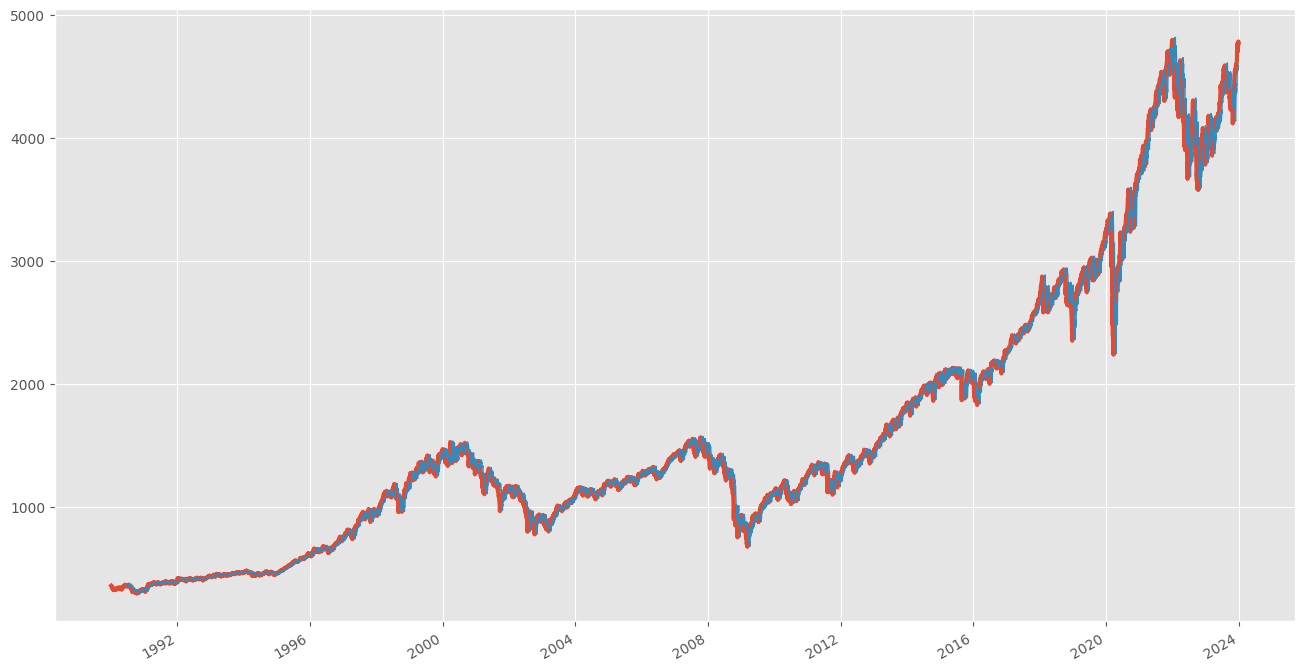

In [16]:
plot_series([data, absolute_predictions_lstm_single])

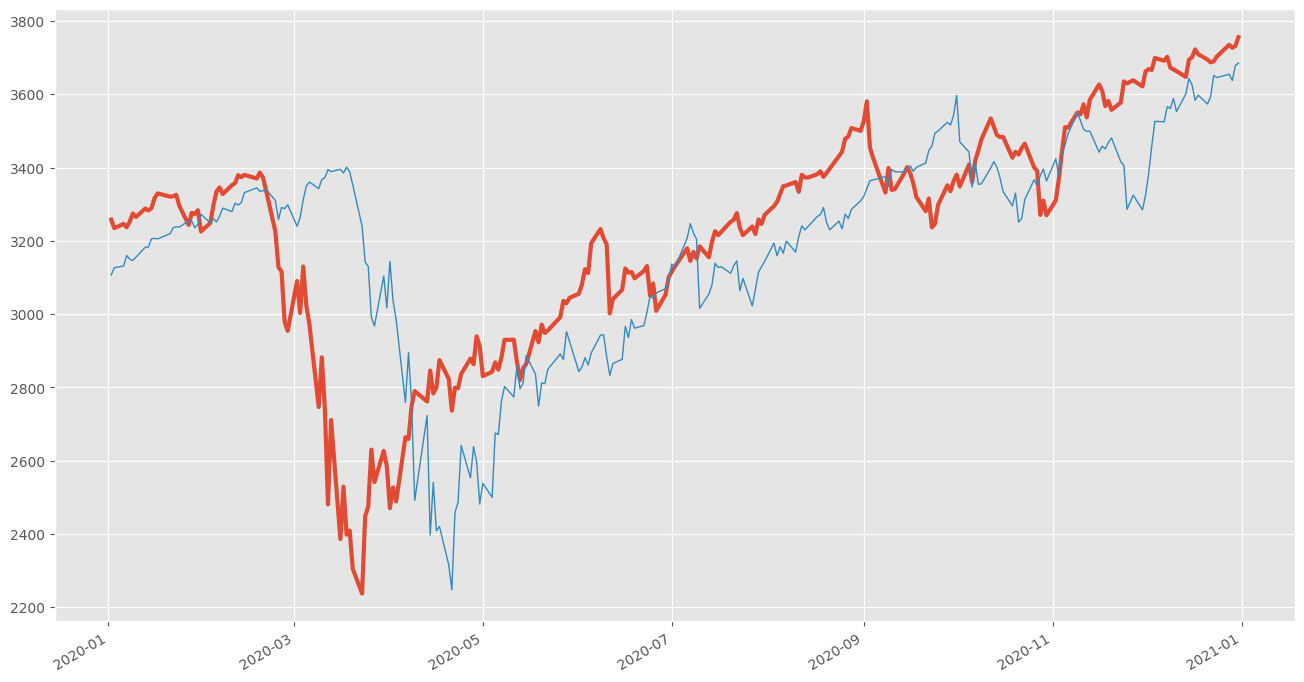

In [17]:
plot_series([data, absolute_predictions_lstm_single], "2020-01-01", "2020-12-31")

In [18]:
print(len(target))
print(experiment_lstm_single.test)
metrics(experiment_lstm_single, absolute_predictions_lstm_single)

8455
lstm_gspc_single.^GSPC.test experiments=9 n=13579
GLOBAL:
n=8455 MSE=7794.8519 RMSE=88.2885 MAE=52.4623 MAPE=0.0324 R² = 0.9934
TRAIN: 
n=62696 MSE=0.0018 RMSE=0.0420 MAE=0.0296 MAPE=1.5072
TEST: 
n=13579 MSE=0.0029 RMSE=0.0536 MAE=0.0379 MAPE=1.8968

Métricas guardadas exitosamente en: /home/manidmt/Universidad/TFG/OTRI/models/keras/lstm_gspc_single_metrics.json


In [19]:
reset_gpu()

In [20]:
config_rnn_single = {
    "mode": "global",  
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": "rnn_gspc_single",
    "start_year": start_date,
    "end_year": end_date,
    "lookahead": 20,
    "horizon": 90,
    "model_params": {
        "architecture": "rnn",
        "topology": {
            "layers": [32, 16],
            "activation": {
                "hidden": "tanh",
                "output": "linear"
            }
        },
        "optimization": {
            "optimizer": "adam",
            "loss": "mean_squared_error",
            "metrics": ["mae"],
            "epochs": 20,
            "batch_size": 32,
            "validation_split": 0.1
        }
    }
}

In [21]:
experiment_rnn_single = ModelExperimentFactory.create_experiment(config_rnn_single)
experiment_rnn_single.run()

X_train before fit: (5959, 90, 1), y_train: (5959, 1)
Number of 5959 samples, 90 timesteps, 1 features
Epoch 1/300


I0000 00:00:1751821048.292508    7926 service.cc:152] XLA service 0x5a965d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751821048.292520    7926 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-07-06 18:57:28.355391: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0063

I0000 00:00:1751821050.292698    7926 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 9.3842e-05 - loss: 0.0039

2025-07-06 18:57:31.811886: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 632 bytes spill stores, 632 bytes spill loads

2025-07-06 18:57:32.219142: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 104 bytes spill stores, 104 bytes spill loads



47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 9.8507e-05 - loss: 0.0038
Epoch 2/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.5699e-04 - loss: 0.0022
Epoch 3/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.8507e-05 - loss: 0.0020
Epoch 4/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.5573e-05 - loss: 0.0022
Epoch 5/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.8171e-04 - loss: 0.0022
Epoch 6/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7561e-04 - loss: 0.0022
Epoch 7/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 7.0378e-05 - loss: 0.0021
Epoch 8/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.4913e-04 - loss: 0.0021
Epoch 9/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.8507e-05 - loss: 0.0021
Epoch 10/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4147e-05 - loss: 0.0021
Epoch 11/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.0825e-04 - loss: 0.0020
Epoch 12/300
47/47 ━

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1632e-05 - loss: 0.0021
Epoch 67/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.8507e-05 - loss: 0.0020
Epoch 68/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.0360e-05 - loss: 0.0022
Epoch 69/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.8507e-05 - loss: 0.0021
Epoch 70/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2077e-04 - loss: 0.0022
Epoch 71/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.3434e-04 - loss: 0.0020
Epoch 72/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.9922e-06 - loss: 0.0021
Epoch 73/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7846e-05 - loss: 0.0020
Epoch 74/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.9477e-05 - loss: 0.0021
Epoch 75/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.8507e-05 - loss: 0.0021
Epoch 76/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4028e-04 - loss: 0.0022
Epoch 77/300

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6603e-04 - loss: 0.0022
Epoch 132/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.8171e-04 - loss: 0.0021
Epoch 133/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5699e-04 - loss: 0.0021
Epoch 134/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.6401e-05 - loss: 0.0020
Epoch 135/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.9663e-04 - loss: 0.0021
Epoch 136/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.8507e-05 - loss: 0.0022
Epoch 137/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7561e-04 - loss: 0.0021
Epoch 138/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2514e-04 - loss: 0.0021
Epoch 139/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.3434e-04 - loss: 0.0022
Epoch 140/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.5422e-04 - loss: 0.0021
Epoch 141/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.5507e-05 - loss: 0.0021
Ep

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.8507e-05 - loss: 0.0021
Epoch 197/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.2479e-05 - loss: 0.0021
Epoch 198/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0530e-05 - loss: 0.0021
Epoch 199/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7846e-05 - loss: 0.0020
Epoch 200/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.5292e-05 - loss: 0.0021
Epoch 201/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1806e-04 - loss: 0.0022
Epoch 202/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.0922e-05 - loss: 0.0023
Epoch 203/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.2479e-05 - loss: 0.0021
Epoch 204/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.9922e-06 - loss: 0.0022
Epoch 205/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0477e-04 - loss: 0.0022
Epoch 206/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.0825e-04 - loss: 0.0020
Ep

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8578e-04 - loss: 0.0021
Epoch 262/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.3546e-05 - loss: 0.0022
Epoch 263/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.3546e-05 - loss: 0.0021
Epoch 264/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4147e-05 - loss: 0.0022
Epoch 265/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.0922e-05 - loss: 0.0022
Epoch 266/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.9922e-06 - loss: 0.0020
Epoch 267/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0530e-05 - loss: 0.0021
Epoch 268/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 7.2585e-04 - loss: 0.0021
Epoch 269/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.8507e-05 - loss: 0.0020
Epoch 270/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4028e-04 - loss: 0.0022
Epoch 271/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7846e-05 - loss: 0.0022
Ep

187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
X_train before fit: (6211, 90, 1), y_train: (6211, 1)
Number of 6211 samples, 90 timesteps, 1 features
Epoch 1/300
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 3.9291e-05 - loss: 0.0066

2025-07-06 19:00:44.609401: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 80 bytes spill stores, 80 bytes spill loads

2025-07-06 19:00:44.920542: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 608 bytes spill stores, 608 bytes spill loads



49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 4.6629e-05 - loss: 0.0065
Epoch 2/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 2.4548e-04 - loss: 0.0022
Epoch 3/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.4548e-04 - loss: 0.0021
Epoch 4/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.4636e-04 - loss: 0.0021
Epoch 5/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.6875e-04 - loss: 0.0021
Epoch 6/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.9889e-05 - loss: 0.0021
Epoch 7/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.0623e-04 - loss: 0.0021
Epoch 8/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.8511e-05 - loss: 0.0020
Epoch 9/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.7761e-04 - loss: 0.0022
Epoch 10/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.0852e-05 - loss: 0.0021
Epoch 11/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5702e-04 - loss: 0.0021
Epoch 12/300
49/49 ━

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.4688e-04 - loss: 0.0020
Epoch 67/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1825e-04 - loss: 0.0021
Epoch 68/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 7.8911e-05 - loss: 0.0020
Epoch 69/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.6110e-04 - loss: 0.0020
Epoch 70/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2644e-04 - loss: 0.0020
Epoch 71/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1964e-04 - loss: 0.0020
Epoch 72/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.1667e-04 - loss: 0.0020
Epoch 73/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.4548e-04 - loss: 0.0020
Epoch 74/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.5087e-05 - loss: 0.0020
Epoch 75/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.3440e-05 - loss: 0.0020
Epoch 76/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7489e-04 - loss: 0.0020
Epoch 77/300

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.3440e-05 - loss: 0.0020
Epoch 132/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8465e-04 - loss: 0.0022
Epoch 133/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.0623e-04 - loss: 0.0021
Epoch 134/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5702e-04 - loss: 0.0021
Epoch 135/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0087e-04 - loss: 0.0021
Epoch 136/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7489e-04 - loss: 0.0021
Epoch 137/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6570e-04 - loss: 0.0019
Epoch 138/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.4605e-05 - loss: 0.0021
Epoch 139/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4098e-04 - loss: 0.0019
Epoch 140/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1313e-04 - loss: 0.0020
Epoch 141/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.1667e-04 - loss: 0.0020
Ep

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.6954e-06 - loss: 0.0021
Epoch 197/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.4636e-04 - loss: 0.0021
Epoch 198/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.7074e-05 - loss: 0.0021
Epoch 199/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 7.3870e-05 - loss: 0.0020
Epoch 200/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.4253e-05 - loss: 0.0020
Epoch 201/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.2518e-05 - loss: 0.0021
Epoch 202/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.4688e-04 - loss: 0.0022
Epoch 203/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.8987e-05 - loss: 0.0022
Epoch 204/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.0623e-04 - loss: 0.0021
Epoch 205/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.5087e-05 - loss: 0.0021
Epoch 206/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.7846e-04 - loss: 0.0020
Ep

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.6110e-04 - loss: 0.0021
Epoch 262/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0087e-04 - loss: 0.0022
Epoch 263/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7489e-04 - loss: 0.0021
Epoch 264/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.0794e-05 - loss: 0.0020
Epoch 265/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4879e-04 - loss: 0.0021
Epoch 266/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1313e-04 - loss: 0.0020
Epoch 267/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.9507e-04 - loss: 0.0020
Epoch 268/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.8987e-05 - loss: 0.0021
Epoch 269/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.1667e-04 - loss: 0.0021
Epoch 270/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.4688e-04 - loss: 0.0021
Epoch 271/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.6629e-05 - loss: 0.0019
Ep

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
X_train before fit: (6463, 90, 1), y_train: (6463, 1)
Number of 6463 samples, 90 timesteps, 1 features
Epoch 1/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 1.7399e-04 - loss: 0.1410
Epoch 2/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.5152e-05 - loss: 0.0131
Epoch 3/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.0413e-04 - loss: 0.0022
Epoch 4/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.5655e-04 - loss: 0.0023
Epoch 5/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1569e-04 - loss: 0.0031
Epoch 6/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.3423e-04 - loss: 0.0023
Epoch 7/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.1382e-04 - loss: 0.0023
Epoch 8/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.9558e-06 - loss: 0.0022
Epoch 9/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8338e-04 - loss: 0.0026
Epoch 1

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.9340e-04 - loss: 0.0021
Epoch 65/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4139e-04 - loss: 0.0021
Epoch 66/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.3886e-04 - loss: 0.0020
Epoch 67/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4139e-04 - loss: 0.0021
Epoch 68/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1615e-05 - loss: 0.0021
Epoch 69/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 4.6712e-05 - loss: 0.0019
Epoch 70/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 7.2163e-05 - loss: 0.0021
Epoch 71/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.1862e-05 - loss: 0.0020
Epoch 72/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1569e-04 - loss: 0.0020
Epoch 73/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1569e-04 - loss: 0.0020
Epoch 74/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.1382e-04 - loss: 0.0019
Epoch 75/300

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4139e-04 - loss: 0.0022
Epoch 130/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 7.6859e-05 - loss: 0.0020
Epoch 131/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5681e-04 - loss: 0.0023
Epoch 132/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.2859e-05 - loss: 0.0021
Epoch 133/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.9103e-05 - loss: 0.0020
Epoch 134/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8349e-05 - loss: 0.0020
Epoch 135/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0282e-04 - loss: 0.0021
Epoch 136/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.4726e-05 - loss: 0.0019
Epoch 137/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2087e-04 - loss: 0.0020
Epoch 138/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2821e-04 - loss: 0.0020
Epoch 139/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4139e-04 - loss: 0.0021
Ep

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2740e-04 - loss: 0.0021
Epoch 195/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.0647e-04 - loss: 0.0022
Epoch 196/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.3192e-05 - loss: 0.0020
Epoch 197/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.1705e-05 - loss: 0.0021
Epoch 198/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4890e-04 - loss: 0.0021
Epoch 199/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.8368e-05 - loss: 0.0020
Epoch 200/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 2.0413e-04 - loss: 0.0020
Epoch 201/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.6713e-05 - loss: 0.0021
Epoch 202/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.0665e-05 - loss: 0.0020
Epoch 203/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.1862e-05 - loss: 0.0020
Epoch 204/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2022e-05 - loss: 0.0020
Ep

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4139e-04 - loss: 0.0020
Epoch 260/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2740e-04 - loss: 0.0022
Epoch 261/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 7.2163e-05 - loss: 0.0020
Epoch 262/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.3192e-05 - loss: 0.0021
Epoch 263/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2740e-04 - loss: 0.0021
Epoch 264/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.0647e-04 - loss: 0.0021
Epoch 265/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.3192e-05 - loss: 0.0020
Epoch 266/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1569e-04 - loss: 0.0021
Epoch 267/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.0647e-04 - loss: 0.0020
Epoch 268/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.7611e-05 - loss: 0.0020
Epoch 269/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.5655e-04 - loss: 0.0020
Ep

202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
X_train before fit: (6715, 90, 1), y_train: (6715, 1)
Number of 6715 samples, 90 timesteps, 1 features
Epoch 1/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 2.6218e-05 - loss: 0.0031
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.4505e-04 - loss: 0.0020
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 7.4895e-05 - loss: 0.0020
Epoch 4/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.3894e-05 - loss: 0.0021
Epoch 5/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.3831e-04 - loss: 0.0020
Epoch 6/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7295e-04 - loss: 0.0019
Epoch 7/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8199e-04 - loss: 0.0021
Epoch 8/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4879e-04 - loss: 0.0021
Epoch 9/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5640e-04 - loss: 0.0019
Epoch 1

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.3467e-04 - loss: 0.0019
Epoch 65/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4879e-04 - loss: 0.0020
Epoch 66/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.9682e-04 - loss: 0.0020
Epoch 67/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1135e-05 - loss: 0.0019
Epoch 68/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.9061e-05 - loss: 0.0020
Epoch 69/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.0197e-04 - loss: 0.0020
Epoch 70/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0442e-04 - loss: 0.0019
Epoch 71/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.3467e-04 - loss: 0.0020
Epoch 72/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.0761e-04 - loss: 0.0020
Epoch 73/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.9433e-05 - loss: 0.0020
Epoch 74/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.3894e-05 - loss: 0.0020
Epoch 75/300

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.6255e-05 - loss: 0.0020
Epoch 130/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.8103e-05 - loss: 0.0021
Epoch 131/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.9682e-04 - loss: 0.0020
Epoch 132/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.2721e-05 - loss: 0.0019
Epoch 133/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.8905e-05 - loss: 0.0020
Epoch 134/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6444e-04 - loss: 0.0019
Epoch 135/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7295e-04 - loss: 0.0020
Epoch 136/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.3059e-05 - loss: 0.0020
Epoch 137/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.6086e-05 - loss: 0.0020
Epoch 138/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 2.6885e-04 - loss: 0.0020
Epoch 139/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2809e-04 - loss: 0.0019
Ep

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8199e-04 - loss: 0.0020
Epoch 195/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.9433e-05 - loss: 0.0020
Epoch 196/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.9433e-05 - loss: 0.0020
Epoch 197/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.9682e-04 - loss: 0.0020
Epoch 198/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 7.9416e-05 - loss: 0.0021
Epoch 199/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.6885e-04 - loss: 0.0020
Epoch 200/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8199e-04 - loss: 0.0021
Epoch 201/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1135e-05 - loss: 0.0020
Epoch 202/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1135e-05 - loss: 0.0021
Epoch 203/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.8103e-05 - loss: 0.0020
Epoch 204/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0442e-04 - loss: 0.0019
Ep

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6981e-05 - loss: 0.0019
Epoch 260/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.8103e-05 - loss: 0.0020
Epoch 261/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.9061e-05 - loss: 0.0019
Epoch 262/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 2.6885e-04 - loss: 0.0020
Epoch 263/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2516e-04 - loss: 0.0020
Epoch 264/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1577e-04 - loss: 0.0020
Epoch 265/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.9061e-05 - loss: 0.0020
Epoch 266/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2516e-04 - loss: 0.0021
Epoch 267/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.2721e-05 - loss: 0.0019
Epoch 268/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.0386e-05 - loss: 0.0021
Epoch 269/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.2122e-05 - loss: 0.0019
Ep

210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
X_train before fit: (6966, 90, 1), y_train: (6966, 1)
Number of 6966 samples, 90 timesteps, 1 features
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 3.0164e-04 - loss: 0.0024
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.8171e-04 - loss: 0.0018
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2854e-04 - loss: 0.0019
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1051e-04 - loss: 0.0019
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.2489e-04 - loss: 0.0019
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.4927e-05 - loss: 0.0019
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6359e-04 - loss: 0.0019
Epoch 8/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4850e-04 - loss: 0.0020
Epoch 9/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4850e-04 - loss: 0.0019
Epoch 1

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7180e-04 - loss: 0.0019
Epoch 65/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.3406e-05 - loss: 0.0020
Epoch 66/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4850e-04 - loss: 0.0021
Epoch 67/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5761e-05 - loss: 0.0020
Epoch 68/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.3418e-04 - loss: 0.0021
Epoch 69/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.8171e-04 - loss: 0.0019
Epoch 70/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0343e-05 - loss: 0.0019
Epoch 71/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1051e-04 - loss: 0.0019
Epoch 72/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.7282e-05 - loss: 0.0019
Epoch 73/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.3482e-04 - loss: 0.0021
Epoch 74/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8982e-04 - loss: 0.0020
Epoch 75/300

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.8913e-05 - loss: 0.0019
Epoch 130/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.3026e-05 - loss: 0.0019
Epoch 131/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.9821e-05 - loss: 0.0019
Epoch 132/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.6428e-04 - loss: 0.0019
Epoch 133/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.5565e-05 - loss: 0.0021
Epoch 134/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.6428e-04 - loss: 0.0019
Epoch 135/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.3610e-05 - loss: 0.0018
Epoch 136/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.0393e-04 - loss: 0.0019
Epoch 137/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.2489e-04 - loss: 0.0019
Epoch 138/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6359e-04 - loss: 0.0020
Epoch 139/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8052e-04 - loss: 0.0018
Ep

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.1604e-05 - loss: 0.0020
Epoch 195/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8982e-04 - loss: 0.0019
Epoch 196/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.6545e-05 - loss: 0.0020
Epoch 197/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.3610e-05 - loss: 0.0020
Epoch 198/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4850e-04 - loss: 0.0019
Epoch 199/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.1269e-06 - loss: 0.0021
Epoch 200/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.9978e-04 - loss: 0.0019
Epoch 201/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.1052e-05 - loss: 0.0020
Epoch 202/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2247e-04 - loss: 0.0021
Epoch 203/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.6428e-04 - loss: 0.0019
Epoch 204/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.3488e-04 - loss: 0.0019
Ep

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1398e-05 - loss: 0.0019
Epoch 260/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.3418e-04 - loss: 0.0018
Epoch 261/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2247e-04 - loss: 0.0019
Epoch 262/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.8913e-05 - loss: 0.0019
Epoch 263/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.9978e-04 - loss: 0.0020
Epoch 264/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.8171e-04 - loss: 0.0019
Epoch 265/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1051e-04 - loss: 0.0020
Epoch 266/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.1052e-05 - loss: 0.0019
Epoch 267/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.0306e-05 - loss: 0.0019
Epoch 268/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8052e-04 - loss: 0.0019
Epoch 269/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5584e-04 - loss: 0.0020
Ep

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
X_train before fit: (7217, 90, 1), y_train: (7217, 1)
Number of 7217 samples, 90 timesteps, 1 features
Epoch 1/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 9.6324e-06 - loss: 0.1277
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 3.4531e-04 - loss: 0.0033
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2594e-05 - loss: 0.0027
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0675e-04 - loss: 0.0024
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.7899e-04 - loss: 0.0024
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4668e-05 - loss: 0.0022
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2879e-04 - loss: 0.0023
Epoch 8/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.3629e-05 - loss: 0.0022
Epoch 9/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1732e-04 - loss: 0.0023
Epoch 1

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2879e-04 - loss: 0.0535
Epoch 65/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1193e-04 - loss: 0.0021
Epoch 66/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.3943e-05 - loss: 0.0020
Epoch 67/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 7.5181e-05 - loss: 0.0020
Epoch 68/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2594e-05 - loss: 0.0020
Epoch 69/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.5984e-04 - loss: 0.0019
Epoch 70/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.7899e-04 - loss: 0.0019
Epoch 71/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.3141e-04 - loss: 0.0019
Epoch 72/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.2389e-04 - loss: 0.0020
Epoch 73/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.4531e-04 - loss: 0.0018
Epoch 74/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7056e-04 - loss: 0.0020
Epoch 75/300

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 9.6324e-06 - loss: 0.0019
Epoch 130/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.3491e-04 - loss: 0.0020
Epoch 131/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.7899e-04 - loss: 0.0019
Epoch 132/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4806e-04 - loss: 0.0020
Epoch 133/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2293e-04 - loss: 0.0018
Epoch 134/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.2307e-05 - loss: 0.0020
Epoch 135/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0675e-04 - loss: 0.0019
Epoch 136/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4133e-04 - loss: 0.0019
Epoch 137/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.7899e-04 - loss: 0.0020
Epoch 138/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.7899e-04 - loss: 0.0019
Epoch 139/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.5343e-05 - loss: 0.0021
Ep

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.9989e-05 - loss: 0.0019
Epoch 195/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1916e-04 - loss: 0.0019
Epoch 196/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7898e-04 - loss: 0.0019
Epoch 197/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4133e-04 - loss: 0.0019
Epoch 198/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.4488e-04 - loss: 0.0019
Epoch 199/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1193e-04 - loss: 0.0020
Epoch 200/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.2307e-05 - loss: 0.0019
Epoch 201/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.7817e-05 - loss: 0.0019
Epoch 202/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2127e-05 - loss: 0.0019
Epoch 203/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.2389e-04 - loss: 0.0019
Epoch 204/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.3943e-05 - loss: 0.0019
Ep

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7259e-05 - loss: 0.0020
Epoch 260/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4668e-05 - loss: 0.0020
Epoch 261/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.8149e-05 - loss: 0.0019
Epoch 262/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.6337e-05 - loss: 0.0019
Epoch 263/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4806e-04 - loss: 0.0209
Epoch 264/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2594e-05 - loss: 0.0028
Epoch 265/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6263e-04 - loss: 0.0019
Epoch 266/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.5343e-05 - loss: 0.0019
Epoch 267/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1193e-04 - loss: 0.0019
Epoch 268/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0675e-04 - loss: 0.0019
Epoch 269/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.9998e-05 - loss: 0.0019
Ep

226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
X_train before fit: (7469, 90, 1), y_train: (7469, 1)
Number of 7469 samples, 90 timesteps, 1 features
Epoch 1/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 1.1317e-05 - loss: 0.0207
Epoch 2/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8553e-05 - loss: 0.0020
Epoch 3/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.4354e-05 - loss: 0.0020
Epoch 4/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1623e-04 - loss: 0.0022
Epoch 5/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4750e-04 - loss: 0.0020
Epoch 6/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.2887e-04 - loss: 0.0018
Epoch 7/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4099e-04 - loss: 0.0020
Epoch 8/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1057e-05 - loss: 0.0019
Epoch 9/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.4109e-04 - loss: 0.0018
Epoch 1

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.2342e-05 - loss: 0.0017
Epoch 65/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.3038e-05 - loss: 0.0022
Epoch 66/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1317e-05 - loss: 0.0019
Epoch 67/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8553e-05 - loss: 0.0018
Epoch 68/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2321e-04 - loss: 0.0017
Epoch 69/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.1213e-04 - loss: 0.0017
Epoch 70/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0757e-04 - loss: 0.0018
Epoch 71/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.5597e-05 - loss: 0.0018
Epoch 72/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8553e-05 - loss: 0.0017
Epoch 73/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6096e-05 - loss: 0.0020
Epoch 74/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.0079e-05 - loss: 0.0020
Epoch 75/300

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.2362e-05 - loss: 0.0020
Epoch 130/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.7073e-04 - loss: 0.0019
Epoch 131/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7738e-04 - loss: 0.0019
Epoch 132/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6924e-04 - loss: 0.0019
Epoch 133/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0757e-04 - loss: 0.0019
Epoch 134/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6096e-05 - loss: 0.0020
Epoch 135/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8553e-05 - loss: 0.0019
Epoch 136/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.8871e-05 - loss: 0.0019
Epoch 137/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.1584e-05 - loss: 0.0019
Epoch 138/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.9536e-04 - loss: 0.0019
Epoch 139/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.6066e-05 - loss: 0.0019
Ep

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6096e-05 - loss: 0.0019
Epoch 195/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.9498e-05 - loss: 0.0019
Epoch 196/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.5597e-05 - loss: 0.0019
Epoch 197/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5435e-04 - loss: 0.0018
Epoch 198/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.8871e-05 - loss: 0.0019
Epoch 199/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1623e-04 - loss: 0.0019
Epoch 200/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7738e-04 - loss: 0.0020
Epoch 201/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6096e-05 - loss: 0.0019
Epoch 202/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.5597e-05 - loss: 0.0021
Epoch 203/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.2362e-05 - loss: 0.0018
Epoch 204/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2807e-04 - loss: 0.0019
Ep

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.1213e-04 - loss: 0.0019
Epoch 260/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.9166e-05 - loss: 0.0018
Epoch 261/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0757e-04 - loss: 0.0018
Epoch 262/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.0944e-04 - loss: 0.0019
Epoch 263/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.7185e-05 - loss: 0.0020
Epoch 264/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1057e-05 - loss: 0.0018
Epoch 265/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.7185e-05 - loss: 0.0019
Epoch 266/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.9166e-05 - loss: 0.0018
Epoch 267/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8553e-05 - loss: 0.0019
Epoch 268/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.6214e-05 - loss: 0.0017
Epoch 269/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.9263e-05 - loss: 0.0019
Ep

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
X_train before fit: (7722, 90, 1), y_train: (7722, 1)
Number of 7722 samples, 90 timesteps, 1 features
Epoch 1/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.0000e+00 - loss: 0.1176
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1304e-04 - loss: 0.0029
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 5.9388e-04 - loss: 0.0027
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1808e-04 - loss: 0.0025
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6047e-04 - loss: 0.0024
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.2476e-05 - loss: 0.0025
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.2776e-06 - loss: 0.0026
Epoch 8/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1304e-04 - loss: 0.0026
Epoch 9/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1808e-04 - loss: 0.0022
Epoch 1

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.9463e-05 - loss: 0.0023
Epoch 65/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.0080e-05 - loss: 0.0022
Epoch 66/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2881e-04 - loss: 0.0020
Epoch 67/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2881e-04 - loss: 0.0021
Epoch 68/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2481e-04 - loss: 0.0023
Epoch 69/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.4748e-05 - loss: 0.0021
Epoch 70/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.2776e-06 - loss: 0.0022
Epoch 71/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2333e-04 - loss: 0.0024
Epoch 72/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.0285e-04 - loss: 0.0022
Epoch 73/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.5141e-04 - loss: 0.0022
Epoch 74/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2481e-04 - loss: 0.0021
Epoch 75/300

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.6716e-04 - loss: 0.0022
Epoch 130/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.2797e-05 - loss: 0.0022
Epoch 131/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.8516e-04 - loss: 0.0022
Epoch 132/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.1129e-05 - loss: 0.0022
Epoch 133/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.6943e-05 - loss: 0.0024
Epoch 134/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.7851e-05 - loss: 0.0022
Epoch 135/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.3741e-04 - loss: 0.0021
Epoch 136/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5047e-05 - loss: 0.0021
Epoch 137/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6788e-04 - loss: 0.0022
Epoch 138/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.1304e-04 - loss: 0.0021
Epoch 139/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0586e-05 - loss: 0.0021
Ep

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4053e-04 - loss: 0.0021
Epoch 195/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.8516e-04 - loss: 0.0022
Epoch 196/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0819e-04 - loss: 0.0022
Epoch 197/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.2880e-05 - loss: 0.0022
Epoch 198/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.4748e-05 - loss: 0.0022
Epoch 199/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.4472e-05 - loss: 0.0020
Epoch 200/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.6286e-04 - loss: 0.0022
Epoch 201/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.4472e-05 - loss: 0.0021
Epoch 202/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.7898e-05 - loss: 0.0021
Epoch 203/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2881e-04 - loss: 0.0022
Epoch 204/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.5141e-04 - loss: 0.0020
Ep

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1335e-04 - loss: 0.0022
Epoch 260/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.2776e-06 - loss: 0.0022
Epoch 261/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.6286e-04 - loss: 0.0022
Epoch 262/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2797e-05 - loss: 0.0022
Epoch 263/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.2034e-05 - loss: 0.0022
Epoch 264/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.7341e-05 - loss: 0.0022
Epoch 265/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.4679e-05 - loss: 0.0021
Epoch 266/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.4133e-06 - loss: 0.0021
Epoch 267/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.6787e-04 - loss: 0.0022
Epoch 268/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.3136e-04 - loss: 0.0022
Epoch 269/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2049e-05 - loss: 0.0022
Ep

242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
X_train before fit: (7974, 90, 1), y_train: (7974, 1)
Number of 7974 samples, 90 timesteps, 1 features
Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 1.1823e-04 - loss: 0.0025
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.2384e-05 - loss: 0.0022
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5251e-04 - loss: 0.0023
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8224e-04 - loss: 0.0021
Epoch 5/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.7916e-04 - loss: 0.0022
Epoch 6/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.8157e-05 - loss: 0.0021
Epoch 7/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.5382e-05 - loss: 0.0022
Epoch 8/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8419e-05 - loss: 0.0020
Epoch 9/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6239e-05 - loss: 0.0020
Epoch 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2332e-04 - loss: 0.0022
Epoch 65/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.5382e-05 - loss: 0.0020
Epoch 66/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1993e-05 - loss: 0.0021
Epoch 67/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.5709e-04 - loss: 0.0021
Epoch 68/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.8157e-05 - loss: 0.0024
Epoch 69/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.4739e-04 - loss: 0.0020
Epoch 70/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.3740e-05 - loss: 0.0020
Epoch 71/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.5537e-04 - loss: 0.0022
Epoch 72/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5251e-04 - loss: 0.0021
Epoch 73/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2162e-04 - loss: 0.0022
Epoch 74/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.9573e-05 - loss: 0.0021
Epoch 75/300

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2862e-04 - loss: 0.0020
Epoch 130/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.3417e-04 - loss: 0.0022
Epoch 131/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.5382e-05 - loss: 0.0021
Epoch 132/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.0035e-04 - loss: 0.0020
Epoch 133/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.5562e-05 - loss: 0.0021
Epoch 134/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2332e-04 - loss: 0.0022
Epoch 135/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 7.8890e-06 - loss: 0.0022
Epoch 136/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.3999e-04 - loss: 0.0021
Epoch 137/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2862e-04 - loss: 0.0021
Epoch 138/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2332e-04 - loss: 0.0020
Epoch 139/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.9190e-06 - loss: 0.0021
Ep

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1335e-04 - loss: 0.0021
Epoch 195/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.3999e-04 - loss: 0.0022
Epoch 196/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.6879e-05 - loss: 0.0022
Epoch 197/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.9190e-06 - loss: 0.0021
Epoch 198/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.3061e-05 - loss: 0.0020
Epoch 199/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.9943e-05 - loss: 0.0021
Epoch 200/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8224e-04 - loss: 0.0020
Epoch 201/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.3061e-05 - loss: 0.0020
Epoch 202/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.5202e-05 - loss: 0.0023
Epoch 203/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.4875e-05 - loss: 0.0020
Epoch 204/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.4739e-04 - loss: 0.0022
Ep

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1335e-04 - loss: 0.0021
Epoch 260/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5251e-04 - loss: 0.0021
Epoch 261/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.9573e-05 - loss: 0.0022
Epoch 262/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.6879e-05 - loss: 0.0021
Epoch 263/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.9931e-05 - loss: 0.0022
Epoch 264/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.0035e-04 - loss: 0.0020
Epoch 265/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.9573e-05 - loss: 0.0022
Epoch 266/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.2384e-05 - loss: 0.0022
Epoch 267/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.1493e-05 - loss: 0.0022
Epoch 268/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.4739e-04 - loss: 0.0021
Epoch 269/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.3999e-04 - loss: 0.0021
Ep

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
X_train before fit: (8475, 90, 1), y_train: (8475, 1)
Number of 8475 samples, 90 timesteps, 1 features
Epoch 1/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 5.2112e-06 - loss: 0.0080
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.2112e-06 - loss: 0.0023
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.9787e-06 - loss: 0.0026
Epoch 4/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2297e-04 - loss: 0.0022
Epoch 5/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.5200e-04 - loss: 0.0021
Epoch 6/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2698e-04 - loss: 0.0021
Epoch 7/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1359e-04 - loss: 0.0021
Epoch 8/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.9548e-04 - loss: 0.0023
Epoch 9/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.1265e-04 - loss: 0.0022
Epoch 

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2698e-04 - loss: 0.0021
Epoch 65/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.7052e-04 - loss: 0.0019
Epoch 66/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.8967e-04 - loss: 0.0022
Epoch 67/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1818e-04 - loss: 0.0020
Epoch 68/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0597e-05 - loss: 0.0023
Epoch 69/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 7.8863e-05 - loss: 0.0022
Epoch 70/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2451e-05 - loss: 0.0020
Epoch 71/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.9548e-04 - loss: 0.0021
Epoch 72/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.2127e-05 - loss: 0.0022
Epoch 73/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6249e-05 - loss: 0.0022
Epoch 74/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.1359e-04 - loss: 0.0021
Epoch 75/300

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.3711e-04 - loss: 0.0021
Epoch 130/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 5.2112e-06 - loss: 0.0023
Epoch 131/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.5724e-05 - loss: 0.0021
Epoch 132/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.7967e-04 - loss: 0.0021
Epoch 133/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.9733e-05 - loss: 0.0022
Epoch 134/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.6261e-05 - loss: 0.0021
Epoch 135/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.6333e-05 - loss: 0.0022
Epoch 136/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.0442e-05 - loss: 0.0022
Epoch 137/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.2451e-05 - loss: 0.0020
Epoch 138/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.7077e-04 - loss: 0.0020
Epoch 139/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.0505e-04 - loss: 0.0022
Ep

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 4.9622e-05 - loss: 0.0021
Epoch 195/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8664e-04 - loss: 0.0022
Epoch 196/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.5683e-04 - loss: 0.0022
Epoch 197/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0917e-04 - loss: 0.0021
Epoch 198/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2698e-04 - loss: 0.0020
Epoch 199/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.1549e-04 - loss: 0.0022
Epoch 200/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4334e-05 - loss: 0.0022
Epoch 201/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.5724e-05 - loss: 0.0021
Epoch 202/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0597e-05 - loss: 0.0022
Epoch 203/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2193e-05 - loss: 0.0021
Epoch 204/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.2127e-05 - loss: 0.0022
Ep

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.6333e-05 - loss: 0.0022
Epoch 260/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 2.2193e-05 - loss: 0.0021
Epoch 261/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 6.3315e-05 - loss: 0.0020
Epoch 262/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0597e-05 - loss: 0.0022
Epoch 263/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.6359e-04 - loss: 0.0023
Epoch 264/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0917e-04 - loss: 0.0021
Epoch 265/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.8196e-05 - loss: 0.0021
Epoch 266/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0491e-04 - loss: 0.0022
Epoch 267/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 9.3020e-05 - loss: 0.0020
Epoch 268/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.3866e-04 - loss: 0.0022
Epoch 269/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 4.4571e-05 - loss: 0.0021
Ep

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [22]:
print(experiment_rnn_single.predictions)
absolute_predictions_rnn_single = experiment_rnn_single.reconstruct_absolute_predictions_from_relative()
print(absolute_predictions_rnn_single)

1990-05-10   -0.005971
1990-05-11   -0.005967
1990-05-14   -0.005969
1990-05-15   -0.005971
1990-05-16   -0.005972
                ...   
2023-12-22   -0.005972
2023-12-26   -0.005971
2023-12-27   -0.005972
2023-12-28   -0.005972
2023-12-29   -0.005973
Length: 8475, dtype: float32
1990-06-08     345.885169
1990-06-11     354.113085
1990-06-12     356.880299
1990-06-13     356.408245
1990-06-14     356.126756
                 ...     
2023-12-22    4586.730284
2023-12-26    4577.768738
2023-12-27    4582.254670
2023-12-28    4577.918992
2023-12-29    4595.238864
Length: 8455, dtype: float64


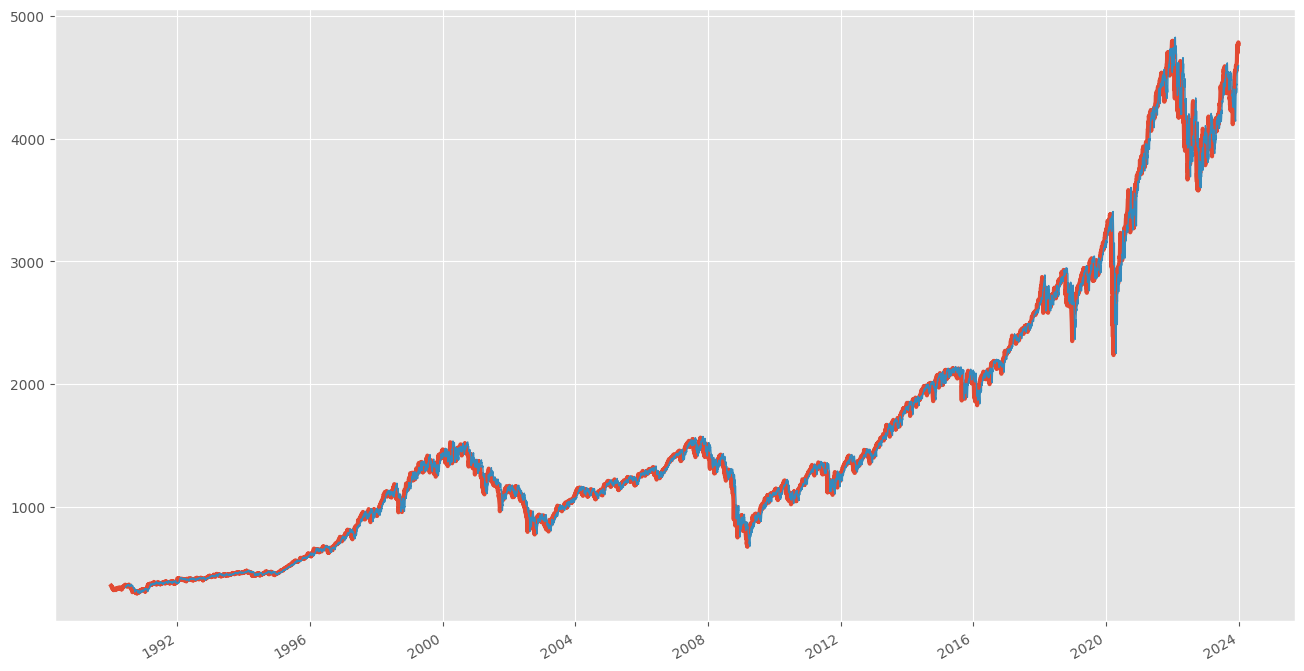

In [23]:
plot_series([data, absolute_predictions_rnn_single])

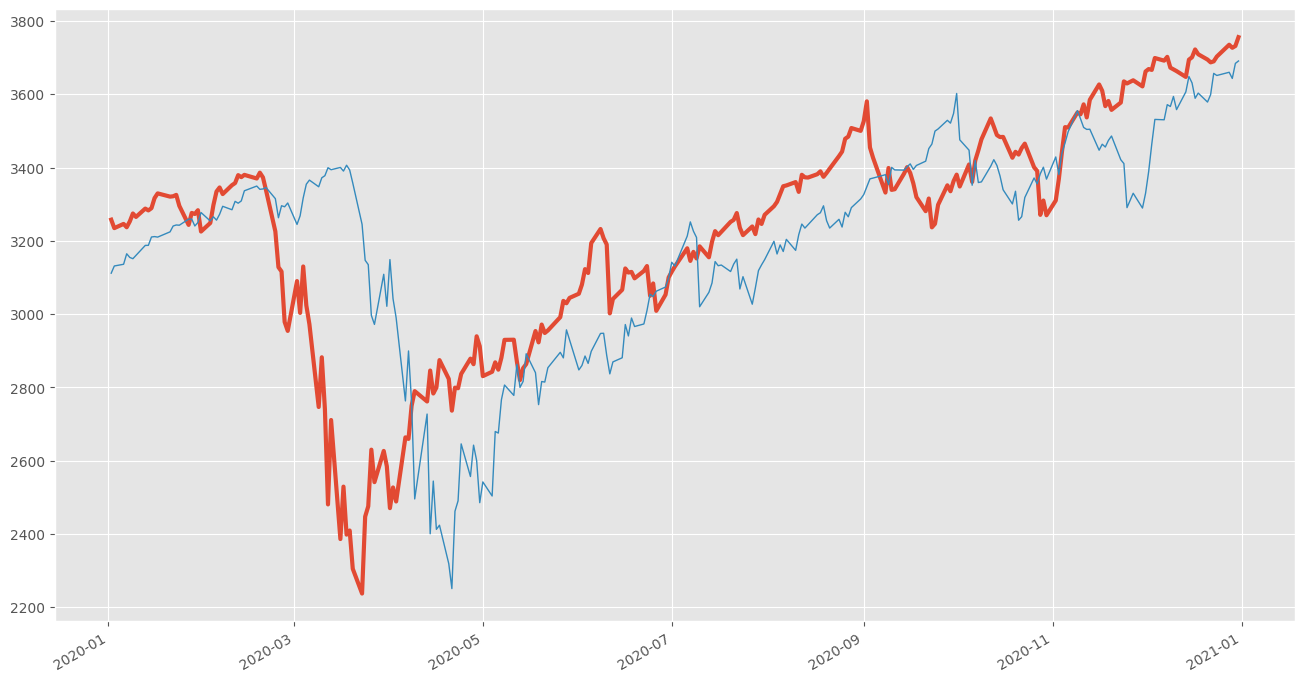

In [24]:
plot_series([data, absolute_predictions_rnn_single], "2020-01-01", "2020-12-31")

In [25]:
metrics(experiment_rnn_single, absolute_predictions_rnn_single)

GLOBAL:
n=8455 MSE=7787.2803 RMSE=88.2456 MAE=52.0940 MAPE=0.0322 R² = 0.9934
TRAIN: 
n=62696 MSE=0.0020 RMSE=0.0450 MAE=0.0316 MAPE=1.4924
TEST: 
n=13579 MSE=0.0028 RMSE=0.0523 MAE=0.0369 MAPE=1.7947

Métricas guardadas exitosamente en: /home/manidmt/Universidad/TFG/OTRI/models/keras/rnn_gspc_single_metrics.json


In [26]:
reset_gpu()

In [27]:
config_cnn_single = {
    "mode": "global",  
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": "cnn_gspc_single",
    "start_year": start_date,
    "end_year": end_date,
    "lookahead": 20,
    "horizon": 90,
    "model_params": {
        "architecture": "cnn",
        "topology": {
            "layers": [32, 16],
            "activation": {
                "hidden": "relu",
                "output": "linear"
            }
        },
        "optimization": {
            "optimizer": "adam",
            "loss": "mean_squared_error",
            "metrics": ["mae"],
            "epochs": 20,
            "batch_size": 32,
            "validation_split": 0.1
        }
    }
}

In [28]:
experiment_cnn_single = ModelExperimentFactory.create_experiment(config_cnn_single)
experiment_cnn_single.run()

Epoch 1/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 8.1054e-05 - loss: 0.2324
Epoch 2/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.8171e-04 - loss: 0.0040
Epoch 3/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6541e-04 - loss: 0.0021 
Epoch 4/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6666e-05 - loss: 0.0022 
Epoch 5/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6309e-04 - loss: 0.0021 
Epoch 6/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7846e-05 - loss: 0.0022 
Epoch 7/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6666e-05 - loss: 0.0023 
Epoch 8/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1806e-04 - loss: 0.0025 
Epoch 9/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3434e-04 - loss: 0.0028 
Epoch 10/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5573e-05 - loss: 0.0025 
Epoch 11/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9477e-05 - loss: 0.0023
Epoch 12/3

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.8171e-04 - loss: 0.0025
Epoch 68/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.1054e-05 - loss: 0.0023
Epoch 69/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1806e-04 - loss: 0.0023
Epoch 70/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6541e-04 - loss: 0.0023
Epoch 71/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7719e-05 - loss: 0.0022
Epoch 72/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5573e-05 - loss: 0.0025
Epoch 73/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.5628e-05 - loss: 0.0023
Epoch 74/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0825e-04 - loss: 0.0027
Epoch 75/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3434e-04 - loss: 0.0021
Epoch 76/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4842e-04 - loss: 0.0022
Epoch 77/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.8171e-04 - loss: 0.0023
Epoch 78/300
47/47 ━━━━

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0922e-05 - loss: 0.0022
Epoch 133/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6603e-04 - loss: 0.0020
Epoch 134/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.2585e-04 - loss: 0.0021
Epoch 135/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.2479e-05 - loss: 0.0022
Epoch 136/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0477e-04 - loss: 0.0023
Epoch 137/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4842e-04 - loss: 0.0023
Epoch 138/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2514e-04 - loss: 0.0021
Epoch 139/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7561e-04 - loss: 0.0022
Epoch 140/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.5292e-05 - loss: 0.0022
Epoch 141/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.7846e-05 - loss: 0.0021
Epoch 142/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3253e-04 - loss: 0.0022
Epoch 143/300

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0477e-04 - loss: 0.0021
Epoch 198/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5573e-05 - loss: 0.0021
Epoch 199/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4147e-05 - loss: 0.0022
Epoch 200/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0825e-04 - loss: 0.0023
Epoch 201/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.8677e-04 - loss: 0.0021
Epoch 202/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.2585e-04 - loss: 0.0021
Epoch 203/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9922e-06 - loss: 0.0022
Epoch 204/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0825e-04 - loss: 0.0020
Epoch 205/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2746e-04 - loss: 0.0020
Epoch 206/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6666e-05 - loss: 0.0023
Epoch 207/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6666e-05 - loss: 0.0021
Epoch 208/300

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4147e-05 - loss: 0.0021
Epoch 263/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5507e-05 - loss: 0.0020
Epoch 264/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6603e-04 - loss: 0.0020
Epoch 265/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4147e-05 - loss: 0.0021
Epoch 266/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0384e-04 - loss: 0.0021
Epoch 267/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5573e-05 - loss: 0.0022
Epoch 268/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8578e-04 - loss: 0.0021
Epoch 269/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5507e-05 - loss: 0.0020
Epoch 270/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4913e-04 - loss: 0.0021
Epoch 271/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6401e-05 - loss: 0.0020
Epoch 272/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2002e-05 - loss: 0.0020
Epoch 273/300

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 8.9507e-05 - loss: 0.3487
Epoch 2/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.9657e-05 - loss: 0.0041 
Epoch 3/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0623e-04 - loss: 0.0022
Epoch 4/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5193e-05 - loss: 0.0022
Epoch 5/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.3870e-05 - loss: 0.0021 
Epoch 6/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6570e-04 - loss: 0.0023
Epoch 7/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5702e-04 - loss: 0.0022
Epoch 8/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2031e-04 - loss: 0.0022 
Epoch 9/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4548e-04 - loss: 0.0023 
Epoch 10/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.4119e-05 - loss: 0.0022
Epoch 11/300
49/49 ━━━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9507e-05 - loss: 0.0026
Epoch 66/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2518e-05 - loss: 0.0030
Epoch 67/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.4402e-06 - loss: 0.0022
Epoch 68/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.4119e-05 - loss: 0.0025
Epoch 69/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.4119e-05 - loss: 0.0026
Epoch 70/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.4605e-05 - loss: 0.0026
Epoch 71/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.9657e-05 - loss: 0.0023
Epoch 72/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4098e-04 - loss: 0.0026
Epoch 73/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3127e-04 - loss: 0.0023
Epoch 74/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6570e-04 - loss: 0.0026
Epoch 75/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6417e-05 - loss: 0.0023
Epoch 76/300
49/49 ━━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.8911e-05 - loss: 0.0021
Epoch 131/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4548e-04 - loss: 0.0021
Epoch 132/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9507e-04 - loss: 0.0022
Epoch 133/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0087e-04 - loss: 0.0021
Epoch 134/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.4119e-05 - loss: 0.0022
Epoch 135/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6417e-05 - loss: 0.0022
Epoch 136/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.8511e-05 - loss: 0.0020
Epoch 137/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0794e-05 - loss: 0.0020
Epoch 138/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.4119e-05 - loss: 0.0023
Epoch 139/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3127e-04 - loss: 0.0022
Epoch 140/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2518e-05 - loss: 0.0021
Epoch 141/300

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.4402e-06 - loss: 0.0021
Epoch 196/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0852e-05 - loss: 0.0021
Epoch 197/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9507e-04 - loss: 0.0020
Epoch 198/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0794e-05 - loss: 0.0021
Epoch 199/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.4119e-05 - loss: 0.0021
Epoch 200/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.8987e-05 - loss: 0.0021
Epoch 201/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.1667e-04 - loss: 0.0020
Epoch 202/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6110e-04 - loss: 0.0021
Epoch 203/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9889e-05 - loss: 0.0021
Epoch 204/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6110e-04 - loss: 0.0021
Epoch 205/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3440e-05 - loss: 0.0020
Epoch 206/300

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7761e-04 - loss: 0.0021
Epoch 261/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.8911e-05 - loss: 0.0021
Epoch 262/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4548e-04 - loss: 0.0021
Epoch 263/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9889e-05 - loss: 0.0020
Epoch 264/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6417e-05 - loss: 0.0020
Epoch 265/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3440e-05 - loss: 0.0020
Epoch 266/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0087e-04 - loss: 0.0020
Epoch 267/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4605e-05 - loss: 0.0021
Epoch 268/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7074e-05 - loss: 0.0020
Epoch 269/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4879e-04 - loss: 0.0020
Epoch 270/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7846e-04 - loss: 0.0021
Epoch 271/300

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.2087e-04 - loss: 0.2678
Epoch 2/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6712e-05 - loss: 0.0029
Epoch 3/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1461e-04 - loss: 0.0020 
Epoch 4/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.5439e-05 - loss: 0.0021 
Epoch 5/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1382e-04 - loss: 0.0021
Epoch 6/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6515e-04 - loss: 0.0022
Epoch 7/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0647e-04 - loss: 0.0021
Epoch 8/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8349e-05 - loss: 0.0022
Epoch 9/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1569e-04 - loss: 0.0027 
Epoch 10/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1382e-04 - loss: 0.0022 
Epoch 11/300
51/51 ━━━━━

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4953e-05 - loss: 0.0028
Epoch 66/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0413e-04 - loss: 0.0033
Epoch 67/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4953e-05 - loss: 0.0024
Epoch 68/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9236e-04 - loss: 0.0025
Epoch 69/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2022e-05 - loss: 0.0028
Epoch 70/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7611e-05 - loss: 0.0022
Epoch 71/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1569e-04 - loss: 0.0024
Epoch 72/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6713e-05 - loss: 0.0024
Epoch 73/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1382e-04 - loss: 0.0024
Epoch 74/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2740e-04 - loss: 0.0025
Epoch 75/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9103e-05 - loss: 0.0024
Epoch 76/300
51/51 ━━━━

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.6859e-05 - loss: 0.0021
Epoch 131/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3192e-05 - loss: 0.0023
Epoch 132/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2821e-04 - loss: 0.0022
Epoch 133/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7611e-05 - loss: 0.0021
Epoch 134/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6515e-04 - loss: 0.0022
Epoch 135/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6515e-04 - loss: 0.0023
Epoch 136/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.9510e-06 - loss: 0.0022
Epoch 137/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.3167e-04 - loss: 0.0020   
Epoch 138/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0665e-05 - loss: 0.0020
Epoch 139/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.3167e-04 - loss: 0.0021
Epoch 140/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4890e-04 - loss: 0.0022
Epoch 141/

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1382e-04 - loss: 0.0020
Epoch 196/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1569e-04 - loss: 0.0019
Epoch 197/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4953e-05 - loss: 0.0021
Epoch 198/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7611e-05 - loss: 0.0020
Epoch 199/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5681e-04 - loss: 0.0020
Epoch 200/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.5655e-04 - loss: 0.0021
Epoch 201/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1615e-05 - loss: 0.0021
Epoch 202/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0647e-04 - loss: 0.0020
Epoch 203/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8338e-04 - loss: 0.0020
Epoch 204/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.3167e-04 - loss: 0.0021
Epoch 205/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.2163e-05 - loss: 0.0020
Epoch 206/300

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6712e-05 - loss: 0.0020
Epoch 261/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3886e-04 - loss: 0.0020
Epoch 262/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0282e-04 - loss: 0.0019
Epoch 263/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1862e-05 - loss: 0.0020
Epoch 264/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7399e-04 - loss: 0.0021
Epoch 265/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7611e-05 - loss: 0.0019
Epoch 266/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.8191e-04 - loss: 0.0019
Epoch 267/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3192e-05 - loss: 0.0020
Epoch 268/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2087e-04 - loss: 0.0020
Epoch 269/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3192e-05 - loss: 0.0021
Epoch 270/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.3167e-04 - loss: 0.0020
Epoch 271/300

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.4155e-04 - loss: 0.2198
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8199e-04 - loss: 0.0026  
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2122e-05 - loss: 0.0020
Epoch 4/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0998e-04 - loss: 0.0019
Epoch 5/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2516e-04 - loss: 0.0021
Epoch 6/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3831e-04 - loss: 0.0020
Epoch 7/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.8905e-05 - loss: 0.0020
Epoch 8/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4155e-04 - loss: 0.0022
Epoch 9/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6065e-04 - loss: 0.0021
Epoch 10/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.0511e-05 - loss: 0.0021
Epoch 11/300
53/53 ━━━━━━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.4505e-04 - loss: 0.0029
Epoch 66/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0998e-04 - loss: 0.0020
Epoch 67/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.9416e-05 - loss: 0.0022
Epoch 68/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0442e-04 - loss: 0.0021
Epoch 69/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.4083e-05 - loss: 0.0020
Epoch 70/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6676e-05 - loss: 0.0021
Epoch 71/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8199e-04 - loss: 0.0021
Epoch 72/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8694e-04 - loss: 0.0025
Epoch 73/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3172e-04 - loss: 0.0020
Epoch 74/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.6255e-05 - loss: 0.0023
Epoch 75/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0442e-04 - loss: 0.0019
Epoch 76/300
53/53 ━━━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2721e-05 - loss: 0.0021
Epoch 131/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6086e-05 - loss: 0.0020
Epoch 132/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.2978e-06 - loss: 0.0020
Epoch 133/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1135e-05 - loss: 0.0021
Epoch 134/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9682e-04 - loss: 0.0019
Epoch 135/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.9416e-05 - loss: 0.0020
Epoch 136/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6885e-04 - loss: 0.0019
Epoch 137/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9682e-04 - loss: 0.0020
Epoch 138/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9995e-05 - loss: 0.0020
Epoch 139/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1310e-04 - loss: 0.0020
Epoch 140/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5156e-06 - loss: 0.0022
Epoch 141/300

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0998e-04 - loss: 0.0019
Epoch 196/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.0511e-05 - loss: 0.0020
Epoch 197/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.3894e-05 - loss: 0.0021
Epoch 198/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5278e-04 - loss: 0.0020
Epoch 199/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 8.2978e-06 - loss: 0.0020
Epoch 200/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3073e-05 - loss: 0.0020
Epoch 201/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6086e-05 - loss: 0.0019
Epoch 202/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7295e-04 - loss: 0.0019
Epoch 203/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2516e-04 - loss: 0.0020
Epoch 204/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8103e-05 - loss: 0.0020
Epoch 205/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4028e-05 - loss: 0.0020
Epoch 206/300

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6444e-04 - loss: 0.0020
Epoch 261/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4155e-04 - loss: 0.0018
Epoch 262/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9682e-04 - loss: 0.0019
Epoch 263/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3073e-05 - loss: 0.0020
Epoch 264/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2721e-05 - loss: 0.0020
Epoch 265/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5278e-04 - loss: 0.0019
Epoch 266/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3831e-04 - loss: 0.0019
Epoch 267/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.3894e-05 - loss: 0.0019
Epoch 268/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3073e-05 - loss: 0.0020
Epoch 269/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2809e-04 - loss: 0.0020
Epoch 270/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2180e-04 - loss: 0.0021
Epoch 271/300

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.1108e-04 - loss: 0.2593
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0033e-05 - loss: 0.0025
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.3016e-05 - loss: 0.0021  
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0393e-04 - loss: 0.0020  
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3482e-04 - loss: 0.0021  
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0164e-04 - loss: 0.0020  
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.3016e-05 - loss: 0.0020
Epoch 8/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2247e-04 - loss: 0.0021  
Epoch 9/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0343e-05 - loss: 0.0022  
Epoch 10/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.7104e-06 - loss: 0.0020
Epoch 11/300
5

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.1604e-05 - loss: 0.0027
Epoch 66/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6359e-04 - loss: 0.0023
Epoch 67/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.2854e-04 - loss: 0.0025
Epoch 68/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3418e-04 - loss: 0.0023
Epoch 69/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3406e-05 - loss: 0.0024
Epoch 70/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6359e-04 - loss: 0.0021
Epoch 71/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2489e-04 - loss: 0.0022
Epoch 72/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0033e-05 - loss: 0.0022
Epoch 73/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1666e-04 - loss: 0.0023
Epoch 74/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2489e-04 - loss: 0.0021
Epoch 75/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8171e-04 - loss: 0.0028
Epoch 76/300
55/55 ━━━━

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0033e-05 - loss: 0.0020
Epoch 131/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.4344e-04 - loss: 0.0020
Epoch 132/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.7244e-05 - loss: 0.0019
Epoch 133/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.7104e-06 - loss: 0.0020
Epoch 134/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9821e-05 - loss: 0.0022
Epoch 135/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6428e-04 - loss: 0.0020
Epoch 136/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3406e-05 - loss: 0.0020
Epoch 137/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.4344e-04 - loss: 0.0020
Epoch 138/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1666e-04 - loss: 0.0021
Epoch 139/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.5280e-04 - loss: 0.0021
Epoch 140/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7180e-04 - loss: 0.0021
Epoch 141/300

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5761e-05 - loss: 0.0020
Epoch 196/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5761e-05 - loss: 0.0020
Epoch 197/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3482e-04 - loss: 0.0020
Epoch 198/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3488e-04 - loss: 0.0020
Epoch 199/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.0754e-05 - loss: 0.0018
Epoch 200/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2214e-04 - loss: 0.0018
Epoch 201/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3418e-04 - loss: 0.0019
Epoch 202/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.1604e-05 - loss: 0.0020
Epoch 203/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.7104e-06 - loss: 0.0019
Epoch 204/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3026e-05 - loss: 0.0019
Epoch 205/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.1604e-05 - loss: 0.0020
Epoch 206/300

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.1604e-05 - loss: 0.0018
Epoch 261/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6104e-05 - loss: 0.0019
Epoch 262/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6545e-05 - loss: 0.0019
Epoch 263/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0033e-05 - loss: 0.0018   
Epoch 264/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.1604e-05 - loss: 0.0019
Epoch 265/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0393e-04 - loss: 0.0019
Epoch 266/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8982e-04 - loss: 0.0017
Epoch 267/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.0754e-05 - loss: 0.0020
Epoch 268/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.4927e-05 - loss: 0.0017
Epoch 269/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.1052e-05 - loss: 0.0018
Epoch 270/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2854e-04 - loss: 0.0019
Epoch 271/

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 5.2990e-05 - loss: 0.2647
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4133e-04 - loss: 0.0026
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7668e-04 - loss: 0.0020
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0794e-04 - loss: 0.0018
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3130e-05 - loss: 0.0019
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6444e-05 - loss: 0.0020
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2389e-04 - loss: 0.0020
Epoch 8/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.3472e-05 - loss: 0.0019
Epoch 9/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.6952e-05 - loss: 0.0020
Epoch 10/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8149e-05 - loss: 0.0020
Epoch 11/300
57/57 ━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2990e-05 - loss: 0.0022
Epoch 66/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2990e-05 - loss: 0.0024
Epoch 67/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0675e-04 - loss: 0.0023
Epoch 68/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1015e-05 - loss: 0.0024
Epoch 69/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1916e-04 - loss: 0.0023
Epoch 70/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7668e-04 - loss: 0.0026
Epoch 71/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4133e-04 - loss: 0.0024
Epoch 72/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8149e-05 - loss: 0.0024
Epoch 73/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3130e-05 - loss: 0.0020
Epoch 74/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1015e-05 - loss: 0.0022
Epoch 75/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1916e-04 - loss: 0.0019
Epoch 76/300
57/57 ━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7899e-04 - loss: 0.0020
Epoch 131/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1732e-04 - loss: 0.0019
Epoch 132/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1193e-04 - loss: 0.0021
Epoch 133/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0794e-04 - loss: 0.0019
Epoch 134/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.1833e-06 - loss: 0.0018
Epoch 135/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1837e-04 - loss: 0.0019
Epoch 136/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6337e-05 - loss: 0.0019
Epoch 137/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9758e-04 - loss: 0.0020
Epoch 138/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.5181e-05 - loss: 0.0019
Epoch 139/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2990e-05 - loss: 0.0019
Epoch 140/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5343e-05 - loss: 0.0019
Epoch 141/300

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.3472e-05 - loss: 0.0019
Epoch 196/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2879e-04 - loss: 0.0019
Epoch 197/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6444e-05 - loss: 0.0019
Epoch 198/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4806e-04 - loss: 0.0018
Epoch 199/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6337e-05 - loss: 0.0019
Epoch 200/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3629e-05 - loss: 0.0020
Epoch 201/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.9989e-05 - loss: 0.0019
Epoch 202/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6263e-04 - loss: 0.0019
Epoch 203/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3943e-05 - loss: 0.0018
Epoch 204/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.1833e-06 - loss: 0.0018
Epoch 205/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3943e-05 - loss: 0.0020
Epoch 206/300

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9758e-04 - loss: 0.0018
Epoch 261/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4668e-05 - loss: 0.0018
Epoch 262/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4806e-04 - loss: 0.0017
Epoch 263/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2990e-05 - loss: 0.0019
Epoch 264/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3629e-05 - loss: 0.0018
Epoch 265/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3491e-04 - loss: 0.0018
Epoch 266/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1732e-04 - loss: 0.0018
Epoch 267/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.9263e-05 - loss: 0.0019
Epoch 268/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.9623e-05 - loss: 0.0019
Epoch 269/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.3472e-05 - loss: 0.0018
Epoch 270/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9998e-05 - loss: 0.0019
Epoch 271/300

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.1778e-04 - loss: 0.1953
Epoch 2/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6214e-05 - loss: 0.0022
Epoch 3/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7185e-05 - loss: 0.0019
Epoch 4/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8871e-05 - loss: 0.0019
Epoch 5/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.9166e-05 - loss: 0.0021
Epoch 6/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8936e-05 - loss: 0.0019  
Epoch 7/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4099e-04 - loss: 0.0019
Epoch 8/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9536e-04 - loss: 0.0021
Epoch 9/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5435e-04 - loss: 0.0022
Epoch 10/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6096e-05 - loss: 0.0019
Epoch 11/300
59/59 ━━━━━━━

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5597e-05 - loss: 0.0023
Epoch 66/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9922e-06 - loss: 0.0021
Epoch 67/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1778e-04 - loss: 0.0023
Epoch 68/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.9166e-05 - loss: 0.0021
Epoch 69/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9498e-05 - loss: 0.0020
Epoch 70/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0274e-04 - loss: 0.0021
Epoch 71/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2342e-05 - loss: 0.0023
Epoch 72/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.5882e-05 - loss: 0.0021
Epoch 73/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2362e-05 - loss: 0.0023
Epoch 74/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2321e-04 - loss: 0.0022
Epoch 75/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2342e-05 - loss: 0.0020
Epoch 76/300
59/59 ━━━━

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2807e-04 - loss: 0.0019
Epoch 131/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5435e-04 - loss: 0.0019
Epoch 132/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9263e-05 - loss: 0.0018
Epoch 133/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4750e-04 - loss: 0.0019
Epoch 134/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.5882e-05 - loss: 0.0020
Epoch 135/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8936e-05 - loss: 0.0019
Epoch 136/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3479e-04 - loss: 0.0019
Epoch 137/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.0944e-04 - loss: 0.0018
Epoch 138/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9498e-05 - loss: 0.0020
Epoch 139/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9263e-05 - loss: 0.0019
Epoch 140/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.1413e-04 - loss: 0.0018
Epoch 141/300

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4099e-04 - loss: 0.0019
Epoch 196/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2342e-05 - loss: 0.0018
Epoch 197/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.0944e-04 - loss: 0.0018
Epoch 198/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1317e-05 - loss: 0.0019
Epoch 199/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8553e-05 - loss: 0.0018
Epoch 200/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8553e-05 - loss: 0.0018
Epoch 201/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4354e-05 - loss: 0.0018
Epoch 202/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0079e-05 - loss: 0.0017
Epoch 203/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2342e-05 - loss: 0.0019
Epoch 204/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.7924e-04 - loss: 0.0019
Epoch 205/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3610e-05 - loss: 0.0018
Epoch 206/300

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1778e-04 - loss: 0.0019
Epoch 261/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8553e-05 - loss: 0.0019
Epoch 262/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6066e-05 - loss: 0.0020
Epoch 263/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9263e-05 - loss: 0.0019
Epoch 264/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.8094e-05 - loss: 0.0018
Epoch 265/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.1413e-04 - loss: 0.0019
Epoch 266/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.3219e-05 - loss: 0.0018
Epoch 267/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2362e-05 - loss: 0.0017
Epoch 268/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9498e-05 - loss: 0.0018
Epoch 269/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4109e-04 - loss: 0.0018
Epoch 270/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8606e-04 - loss: 0.0018
Epoch 271/300

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 2.5141e-04 - loss: 0.1940
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2797e-05 - loss: 0.0024  
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6286e-04 - loss: 0.0023
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0616e-04 - loss: 0.0024  
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4660e-05 - loss: 0.0024
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5141e-04 - loss: 0.0022
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2797e-05 - loss: 0.0024
Epoch 8/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2776e-06 - loss: 0.0022
Epoch 9/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.7898e-05 - loss: 0.0028  
Epoch 10/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0616e-04 - loss: 0.0024
Epoch 11/300
61/61 ━━━

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7576e-04 - loss: 0.0022
Epoch 66/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7576e-04 - loss: 0.0024
Epoch 67/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.4679e-05 - loss: 0.0024
Epoch 68/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2481e-04 - loss: 0.0028
Epoch 69/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0352e-04 - loss: 0.0024
Epoch 70/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2797e-05 - loss: 0.0027
Epoch 71/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3453e-04 - loss: 0.0022
Epoch 72/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.4951e-05 - loss: 0.0024
Epoch 73/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.7898e-05 - loss: 0.0023
Epoch 74/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9463e-05 - loss: 0.0026
Epoch 75/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9463e-05 - loss: 0.0024
Epoch 76/300
61/61 ━━━━

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9316e-04 - loss: 0.0021
Epoch 131/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2333e-04 - loss: 0.0022
Epoch 132/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6788e-04 - loss: 0.0020
Epoch 133/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2881e-04 - loss: 0.0022
Epoch 134/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.4951e-05 - loss: 0.0020
Epoch 135/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2049e-05 - loss: 0.0023
Epoch 136/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0080e-05 - loss: 0.0022
Epoch 137/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7338e-05 - loss: 0.0022
Epoch 138/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6413e-05 - loss: 0.0022
Epoch 139/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.9024e-05 - loss: 0.0022
Epoch 140/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6943e-05 - loss: 0.0023
Epoch 141/300

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4684e-04 - loss: 0.0020
Epoch 196/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2049e-05 - loss: 0.0021
Epoch 197/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2049e-05 - loss: 0.0020
Epoch 198/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.4445e-05 - loss: 0.0020
Epoch 199/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9463e-05 - loss: 0.0021
Epoch 200/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6047e-04 - loss: 0.0019
Epoch 201/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0586e-05 - loss: 0.0023
Epoch 202/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2881e-04 - loss: 0.0023
Epoch 203/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.8674e-05 - loss: 0.0022
Epoch 204/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2481e-04 - loss: 0.0022
Epoch 205/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0819e-04 - loss: 0.0021
Epoch 206/300

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8516e-04 - loss: 0.0022
Epoch 261/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.4748e-05 - loss: 0.0021
Epoch 262/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.7898e-05 - loss: 0.0022
Epoch 263/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4660e-05 - loss: 0.0021
Epoch 264/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1335e-04 - loss: 0.0021
Epoch 265/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2481e-04 - loss: 0.0022
Epoch 266/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2776e-06 - loss: 0.0021
Epoch 267/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6413e-05 - loss: 0.0021
Epoch 268/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9671e-05 - loss: 0.0021
Epoch 269/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9316e-04 - loss: 0.0022
Epoch 270/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.1129e-05 - loss: 0.0022
Epoch 271/300

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 9.9771e-05 - loss: 0.3827
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3383e-04 - loss: 0.0026  
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3417e-04 - loss: 0.0021
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9573e-05 - loss: 0.0023
Epoch 5/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6879e-05 - loss: 0.0024  
Epoch 6/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5202e-05 - loss: 0.0022
Epoch 7/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1052e-04 - loss: 0.0023
Epoch 8/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6265e-04 - loss: 0.0022  
Epoch 9/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6648e-04 - loss: 0.0021
Epoch 10/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2384e-05 - loss: 0.0021
Epoch 11/300
63/63 ━

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.1493e-05 - loss: 0.0021
Epoch 66/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2332e-04 - loss: 0.0023
Epoch 67/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.5709e-04 - loss: 0.0027
Epoch 68/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0035e-04 - loss: 0.0026
Epoch 69/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0016e-05 - loss: 0.0027
Epoch 70/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7549e-05 - loss: 0.0026
Epoch 71/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7411e-04 - loss: 0.0022
Epoch 72/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.9235e-06 - loss: 0.0022
Epoch 73/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.9931e-05 - loss: 0.0030
Epoch 74/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.2963e-05 - loss: 0.0025
Epoch 75/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5202e-05 - loss: 0.0026
Epoch 76/300
63/63 ━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0035e-04 - loss: 0.0022
Epoch 131/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.3740e-05 - loss: 0.0021
Epoch 132/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.6273e-05 - loss: 0.0023
Epoch 133/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3417e-04 - loss: 0.0021
Epoch 134/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.5537e-04 - loss: 0.0022
Epoch 135/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0035e-04 - loss: 0.0021
Epoch 136/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4097e-05 - loss: 0.0021
Epoch 137/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.7555e-05 - loss: 0.0021
Epoch 138/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6265e-04 - loss: 0.0022
Epoch 139/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.6451e-05 - loss: 0.0021
Epoch 140/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2670e-05 - loss: 0.0021
Epoch 141/300

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7411e-04 - loss: 0.0022
Epoch 196/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6265e-04 - loss: 0.0019
Epoch 197/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9943e-05 - loss: 0.0020
Epoch 198/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.3061e-05 - loss: 0.0021
Epoch 199/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9573e-05 - loss: 0.0021
Epoch 200/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.5562e-05 - loss: 0.0021
Epoch 201/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0016e-05 - loss: 0.0021
Epoch 202/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9096e-04 - loss: 0.0021
Epoch 203/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8879e-06 - loss: 0.0019
Epoch 204/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3999e-04 - loss: 0.0021
Epoch 205/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0638e-05 - loss: 0.0021
Epoch 206/300

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.3902e-05 - loss: 0.0019
Epoch 261/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.6273e-05 - loss: 0.0021
Epoch 262/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.1493e-05 - loss: 0.0022
Epoch 263/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3061e-05 - loss: 0.0021
Epoch 264/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8419e-05 - loss: 0.0020
Epoch 265/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1052e-04 - loss: 0.0020
Epoch 266/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6648e-04 - loss: 0.0020
Epoch 267/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.7916e-04 - loss: 0.0020
Epoch 268/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2862e-04 - loss: 0.0021
Epoch 269/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3999e-04 - loss: 0.0022
Epoch 270/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9573e-05 - loss: 0.0020
Epoch 271/300

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.2451e-05 - loss: 0.2440
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5683e-04 - loss: 0.0024
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2193e-05 - loss: 0.0021
Epoch 4/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3315e-05 - loss: 0.0022
Epoch 5/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2838e-05 - loss: 0.0022
Epoch 6/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8967e-04 - loss: 0.0023
Epoch 7/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.6850e-05 - loss: 0.0022
Epoch 8/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9284e-05 - loss: 0.0022
Epoch 9/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.2389e-05 - loss: 0.0027
Epoch 10/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7843e-04 - loss: 0.0024
Epoch 11/300
67/67 ━━━━━━━━━

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.2242e-05 - loss: 0.0023
Epoch 66/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.9622e-05 - loss: 0.0022
Epoch 67/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9314e-05 - loss: 0.0025
Epoch 68/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.6261e-05 - loss: 0.0020
Epoch 69/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.5580e-05 - loss: 0.0022
Epoch 70/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.5091e-05 - loss: 0.0024
Epoch 71/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0628e-05 - loss: 0.0024
Epoch 72/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0491e-04 - loss: 0.0023
Epoch 73/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.5724e-05 - loss: 0.0025
Epoch 74/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6333e-05 - loss: 0.0023
Epoch 75/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4137e-04 - loss: 0.0024
Epoch 76/300
67/67 ━━━━

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3315e-05 - loss: 0.0022
Epoch 131/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.8863e-05 - loss: 0.0022
Epoch 132/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3711e-04 - loss: 0.0022
Epoch 133/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.7640e-05 - loss: 0.0022
Epoch 134/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8196e-05 - loss: 0.0023
Epoch 135/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4244e-05 - loss: 0.0021
Epoch 136/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2698e-04 - loss: 0.0024
Epoch 137/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3319e-04 - loss: 0.0022
Epoch 138/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4137e-04 - loss: 0.0021
Epoch 139/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.5724e-05 - loss: 0.0021
Epoch 140/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3711e-04 - loss: 0.0021
Epoch 141/300

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7077e-04 - loss: 0.0021
Epoch 196/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9284e-05 - loss: 0.0022
Epoch 197/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4244e-05 - loss: 0.0021
Epoch 198/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7388e-05 - loss: 0.0021
Epoch 199/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3711e-04 - loss: 0.0020
Epoch 200/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3866e-04 - loss: 0.0021
Epoch 201/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2127e-05 - loss: 0.0021
Epoch 202/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0628e-05 - loss: 0.0020
Epoch 203/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4334e-05 - loss: 0.0021
Epoch 204/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.5724e-05 - loss: 0.0020
Epoch 205/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6359e-04 - loss: 0.0020
Epoch 206/300

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9733e-05 - loss: 0.0020
Epoch 261/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1549e-04 - loss: 0.0020
Epoch 262/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.4905e-05 - loss: 0.0021
Epoch 263/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2112e-06 - loss: 0.0021
Epoch 264/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0597e-05 - loss: 0.0022
Epoch 265/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0505e-04 - loss: 0.0021
Epoch 266/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0917e-04 - loss: 0.0022
Epoch 267/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.0442e-05 - loss: 0.0020
Epoch 268/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7052e-04 - loss: 0.0020
Epoch 269/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8461e-05 - loss: 0.0021
Epoch 270/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.5724e-05 - loss: 0.0019
Epoch 271/300

265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


In [29]:
print(experiment_cnn_single.predictions)
absolute_predictions_cnn_single = experiment_cnn_single.reconstruct_absolute_predictions_from_relative()
print(absolute_predictions_cnn_single)

1990-05-10   -0.003851
1990-05-11   -0.004250
1990-05-14   -0.004425
1990-05-15   -0.004511
1990-05-16   -0.004652
                ...   
2023-12-22   -0.005223
2023-12-26   -0.005246
2023-12-27   -0.005312
2023-12-28   -0.005354
2023-12-29   -0.005469
Length: 8475, dtype: float32
1990-06-08     345.149031
1990-06-11     353.502360
1990-06-12     356.326657
1990-06-13     355.885547
1990-06-14     355.654598
                 ...     
2023-12-22    4578.277629
2023-12-26    4569.428316
2023-12-27    4574.099909
2023-12-28    4569.968896
2023-12-29    4587.180440
Length: 8455, dtype: float64


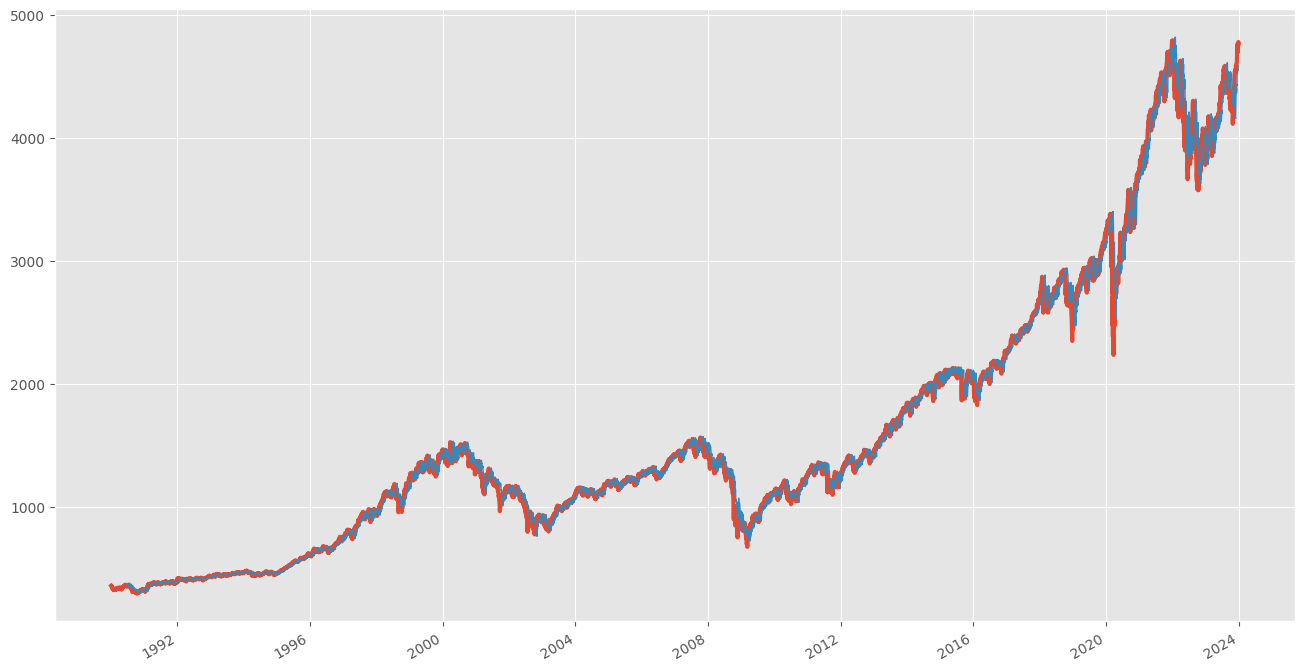

In [30]:
plot_series([data, absolute_predictions_cnn_single])

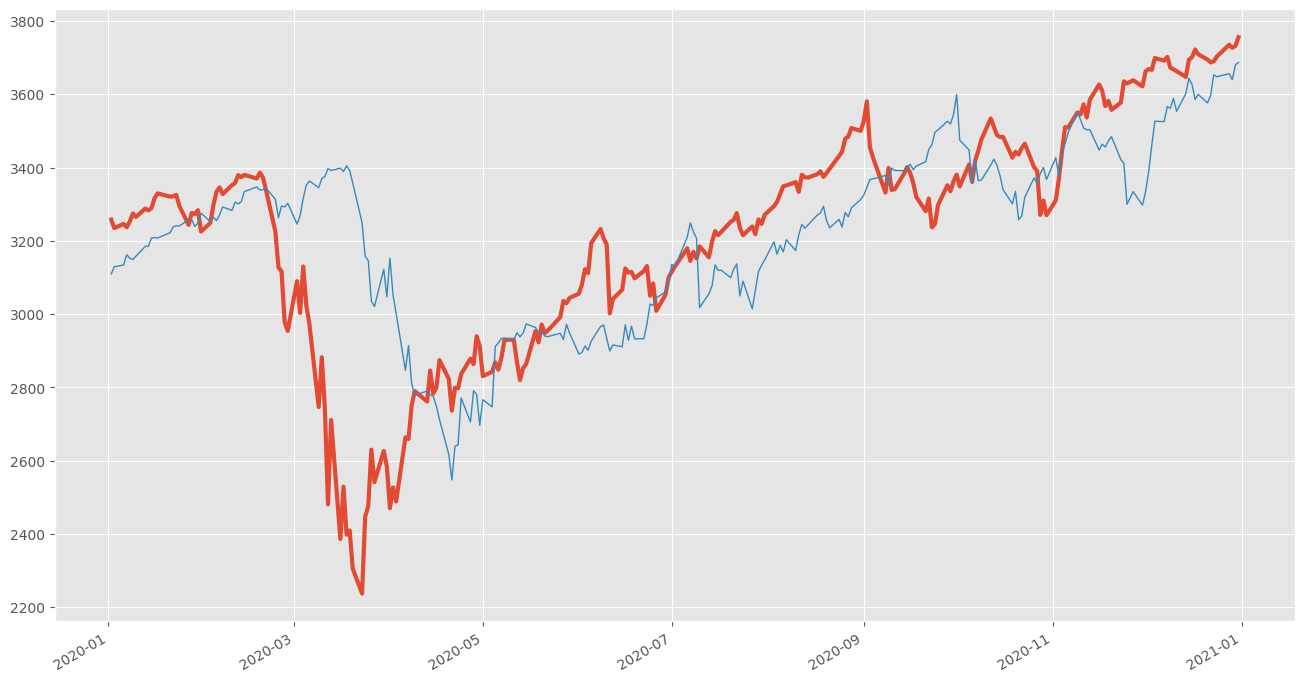

In [31]:
plot_series([data, absolute_predictions_cnn_single], "2020-01-01", "2020-12-31")

In [32]:
metrics(experiment_cnn_single, absolute_predictions_cnn_single)

GLOBAL:
n=8455 MSE=7347.0961 RMSE=85.7152 MAE=51.1376 MAPE=0.0319 R² = 0.9938
TRAIN: 
n=62696 MSE=0.0019 RMSE=0.0440 MAE=0.0312 MAPE=1.5648
TEST: 
n=13579 MSE=0.0028 RMSE=0.0527 MAE=0.0367 MAPE=1.9744

Métricas guardadas exitosamente en: /home/manidmt/Universidad/TFG/OTRI/models/keras/cnn_gspc_single_metrics.json


In [33]:
reset_gpu()

In [34]:
config_cnn2d_single = {
    "mode": "global",  
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": "cnn2d_gspc_single",
    "start_year": start_date,
    "end_year": end_date,
    "lookahead": 20,
    "horizon": 90,
    "model_params": {
        "architecture": "cnn2d",
        "topology": {
            "layers": [8, 8, 8],
            "activation": {
                "output": "linear"
            }
        },
        "optimization": {
            "optimizer": "adam",
            "loss": "mean_squared_error",
            "metrics": ["mae"],
            "epochs": 20,
            "batch_size": 32,
            "validation_split": 0.1
        }
    }
}

In [37]:
experiment_cnn2d_single = ModelExperimentFactory.create_experiment(config_cnn2d_single)
experiment_cnn2d_single.run()

Epoch 1/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 4.2746e-04 - loss: 0.2713
Epoch 2/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.2479e-05 - loss: 0.0035
Epoch 3/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4913e-04 - loss: 0.0021
Epoch 4/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3253e-04 - loss: 0.0022
Epoch 5/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.5628e-05 - loss: 0.0022
Epoch 6/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.6603e-04 - loss: 0.0022
Epoch 7/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6666e-05 - loss: 0.0020
Epoch 8/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0530e-05 - loss: 0.0022
Epoch 9/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0922e-05 - loss: 0.0021
Epoch 10/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1632e-05 - loss: 0.0022
Epoch 11/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6666e-05 - loss: 0.0023
Epoch 12/300
47/47

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.8507e-05 - loss: 0.0026
Epoch 68/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.0384e-04 - loss: 0.0028
Epoch 69/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.8677e-04 - loss: 0.0025
Epoch 70/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 8.1054e-05 - loss: 0.0024
Epoch 71/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.9477e-05 - loss: 0.0027
Epoch 72/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.5628e-05 - loss: 0.0043
Epoch 73/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.6603e-04 - loss: 0.0027
Epoch 74/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.8349e-04 - loss: 0.0023
Epoch 75/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.0384e-04 - loss: 0.0028
Epoch 76/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.4842e-04 - loss: 0.0027
Epoch 77/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.4842e-04 - loss: 0.0025
Epoch 78/300
47/47 ━━━━

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.5422e-04 - loss: 0.0023
Epoch 133/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.3434e-04 - loss: 0.0023
Epoch 134/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.0825e-04 - loss: 0.0021
Epoch 135/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.0825e-04 - loss: 0.0022
Epoch 136/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.7846e-05 - loss: 0.0023
Epoch 137/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.4842e-04 - loss: 0.0024
Epoch 138/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.7561e-04 - loss: 0.0022
Epoch 139/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.0922e-05 - loss: 0.0021
Epoch 140/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.7561e-04 - loss: 0.0023
Epoch 141/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.7846e-05 - loss: 0.0020
Epoch 142/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.3546e-05 - loss: 0.0022
Epoch 143/300

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.8349e-04 - loss: 0.0020
Epoch 198/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.0384e-04 - loss: 0.0023
Epoch 199/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.5573e-05 - loss: 0.0022
Epoch 200/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.5507e-05 - loss: 0.0022
Epoch 201/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.8507e-05 - loss: 0.0021
Epoch 202/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.5507e-05 - loss: 0.0020
Epoch 203/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.2077e-04 - loss: 0.0022
Epoch 204/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.5628e-05 - loss: 0.0020
Epoch 205/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.4028e-04 - loss: 0.0020
Epoch 206/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.8171e-04 - loss: 0.0021
Epoch 207/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.8578e-04 - loss: 0.0022
Epoch 208/300

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.5422e-04 - loss: 0.0021
Epoch 263/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 8.1054e-05 - loss: 0.0021
Epoch 264/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.0360e-05 - loss: 0.0020
Epoch 265/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.8171e-04 - loss: 0.0020
Epoch 266/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.2746e-04 - loss: 0.0020
Epoch 267/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.3434e-04 - loss: 0.0021
Epoch 268/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.9663e-04 - loss: 0.0021
Epoch 269/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.1128e-04 - loss: 0.0021
Epoch 270/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.1632e-05 - loss: 0.0020
Epoch 271/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.2479e-05 - loss: 0.0020
Epoch 272/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0530e-05 - loss: 0.0020
Epoch 273/300

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 4.1667e-04 - loss: 0.2297
Epoch 2/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4548e-04 - loss: 0.0030
Epoch 3/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0688e-04 - loss: 0.0021
Epoch 4/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0688e-04 - loss: 0.0021
Epoch 5/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.0313e-04 - loss: 0.0022
Epoch 6/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4548e-04 - loss: 0.0022
Epoch 7/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.5087e-05 - loss: 0.0019
Epoch 8/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1825e-04 - loss: 0.0022
Epoch 9/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.9657e-05 - loss: 0.0021
Epoch 10/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1825e-04 - loss: 0.0022
Epoch 11/300
49/49 ━━━━━━━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.6110e-04 - loss: 0.0023
Epoch 66/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.1313e-04 - loss: 0.0021
Epoch 67/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.5087e-05 - loss: 0.0024
Epoch 68/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.9799e-04 - loss: 0.0021
Epoch 69/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.3870e-05 - loss: 0.0024
Epoch 70/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9507e-05 - loss: 0.0021
Epoch 71/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.6629e-05 - loss: 0.0023
Epoch 72/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.5087e-05 - loss: 0.0023
Epoch 73/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.5193e-05 - loss: 0.0024
Epoch 74/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.6417e-05 - loss: 0.0024
Epoch 75/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.6629e-05 - loss: 0.0023
Epoch 76/300
49/49 ━━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.0794e-05 - loss: 0.0022
Epoch 131/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.4605e-05 - loss: 0.0021
Epoch 132/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.4605e-05 - loss: 0.0021
Epoch 133/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 8.9507e-05 - loss: 0.0022
Epoch 134/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.6629e-05 - loss: 0.0021
Epoch 135/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.7761e-04 - loss: 0.0020
Epoch 136/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.3127e-04 - loss: 0.0020
Epoch 137/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.4605e-05 - loss: 0.0021
Epoch 138/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.6875e-04 - loss: 0.0022
Epoch 139/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.8465e-04 - loss: 0.0022
Epoch 140/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.5087e-05 - loss: 0.0020
Epoch 141/300

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.2518e-05 - loss: 0.0022
Epoch 196/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.1667e-04 - loss: 0.0021
Epoch 197/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.9657e-05 - loss: 0.0020
Epoch 198/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.6417e-05 - loss: 0.0021
Epoch 199/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.0313e-04 - loss: 0.0021
Epoch 200/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.4605e-05 - loss: 0.0021
Epoch 201/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.0852e-05 - loss: 0.0021
Epoch 202/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0688e-04 - loss: 0.0021
Epoch 203/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.3870e-05 - loss: 0.0020
Epoch 204/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.6629e-05 - loss: 0.0021
Epoch 205/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.5087e-05 - loss: 0.0020
Epoch 206/300

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.7489e-04 - loss: 0.0020
Epoch 261/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.4402e-06 - loss: 0.0021
Epoch 262/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.8911e-05 - loss: 0.0019
Epoch 263/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.0623e-04 - loss: 0.0019
Epoch 264/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.6629e-05 - loss: 0.0020
Epoch 265/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3354e-04 - loss: 0.0019
Epoch 266/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.9799e-04 - loss: 0.0020
Epoch 267/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.5702e-04 - loss: 0.0019
Epoch 268/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.3020e-05 - loss: 0.0020
Epoch 269/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.7846e-04 - loss: 0.0020
Epoch 270/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.6417e-05 - loss: 0.0021
Epoch 271/300

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.1382e-04 - loss: 0.2528
Epoch 2/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7358e-04 - loss: 0.0029
Epoch 3/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1569e-04 - loss: 0.0022
Epoch 4/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8338e-04 - loss: 0.0022
Epoch 5/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7358e-04 - loss: 0.0020
Epoch 6/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8368e-05 - loss: 0.0021
Epoch 7/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5689e-04 - loss: 0.0020
Epoch 8/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3192e-05 - loss: 0.0021
Epoch 9/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2859e-05 - loss: 0.0024
Epoch 10/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5689e-04 - loss: 0.0023
Epoch 11/300
51/51 ━━━━━━━━━

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.4726e-05 - loss: 0.0023
Epoch 66/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.8338e-04 - loss: 0.0022
Epoch 67/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.8191e-04 - loss: 0.0023
Epoch 68/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6712e-05 - loss: 0.0023
Epoch 69/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.0413e-04 - loss: 0.0022
Epoch 70/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.7399e-04 - loss: 0.0022
Epoch 71/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.6859e-05 - loss: 0.0025
Epoch 72/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8368e-05 - loss: 0.0023
Epoch 73/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.1894e-05 - loss: 0.0024
Epoch 74/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0282e-04 - loss: 0.0025
Epoch 75/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.0413e-04 - loss: 0.0025
Epoch 76/300
51/51 ━━━━

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.3886e-04 - loss: 0.0021
Epoch 131/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.0413e-04 - loss: 0.0021
Epoch 132/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 8.1705e-05 - loss: 0.0020
Epoch 133/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.6515e-04 - loss: 0.0021
Epoch 134/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.6891e-04 - loss: 0.0022
Epoch 135/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.6515e-04 - loss: 0.0021
Epoch 136/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.3167e-04 - loss: 0.0020
Epoch 137/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.9236e-04 - loss: 0.0022
Epoch 138/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.3167e-04 - loss: 0.0022
Epoch 139/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.1862e-05 - loss: 0.0020
Epoch 140/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.2163e-05 - loss: 0.0021
Epoch 141/300

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4139e-04 - loss: 0.0020
Epoch 196/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.1569e-04 - loss: 0.0020
Epoch 197/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.8899e-05 - loss: 0.0021
Epoch 198/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.6859e-05 - loss: 0.0021
Epoch 199/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.0413e-04 - loss: 0.0020
Epoch 200/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.1569e-04 - loss: 0.0020
Epoch 201/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.7399e-04 - loss: 0.0021
Epoch 202/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.8191e-04 - loss: 0.0021
Epoch 203/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.8368e-05 - loss: 0.0020
Epoch 204/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.6515e-04 - loss: 0.0021
Epoch 205/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.5689e-04 - loss: 0.0020
Epoch 206/300

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.4890e-04 - loss: 0.0019
Epoch 261/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0282e-04 - loss: 0.0020
Epoch 262/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 8.1705e-05 - loss: 0.0020
Epoch 263/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.5689e-04 - loss: 0.0020
Epoch 264/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.1461e-04 - loss: 0.0019
Epoch 265/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.2163e-05 - loss: 0.0019
Epoch 266/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.5681e-04 - loss: 0.0019
Epoch 267/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.2859e-05 - loss: 0.0019
Epoch 268/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0282e-04 - loss: 0.0019
Epoch 269/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4139e-04 - loss: 0.0020
Epoch 270/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4953e-05 - loss: 0.0020
Epoch 271/300

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 3.9682e-04 - loss: 0.2616
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6885e-04 - loss: 0.0028
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.1739e-04 - loss: 0.0021
Epoch 4/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5640e-04 - loss: 0.0021
Epoch 5/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4028e-05 - loss: 0.0020
Epoch 6/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0998e-04 - loss: 0.0022
Epoch 7/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6065e-04 - loss: 0.0020
Epoch 8/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2122e-05 - loss: 0.0020
Epoch 9/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3059e-05 - loss: 0.0020
Epoch 10/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7295e-04 - loss: 0.0021
Epoch 11/300
53/53 ━━━━━━━━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.9682e-04 - loss: 0.0021
Epoch 66/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.6206e-04 - loss: 0.0023
Epoch 67/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.5278e-04 - loss: 0.0027
Epoch 68/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.4193e-05 - loss: 0.0020
Epoch 69/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.0511e-05 - loss: 0.0025
Epoch 70/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.4895e-05 - loss: 0.0022
Epoch 71/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0442e-04 - loss: 0.0022
Epoch 72/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.3831e-04 - loss: 0.0022
Epoch 73/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9682e-04 - loss: 0.0024
Epoch 74/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.3073e-05 - loss: 0.0024
Epoch 75/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.8199e-04 - loss: 0.0023
Epoch 76/300
53/53 ━━━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.0761e-04 - loss: 0.0020
Epoch 131/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.2721e-05 - loss: 0.0020
Epoch 132/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0761e-04 - loss: 0.0021
Epoch 133/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0998e-04 - loss: 0.0020
Epoch 134/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3831e-04 - loss: 0.0021
Epoch 135/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.8103e-05 - loss: 0.0021
Epoch 136/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8694e-04 - loss: 0.0020
Epoch 137/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.6255e-05 - loss: 0.0021
Epoch 138/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 8.4083e-05 - loss: 0.0020
Epoch 139/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.6086e-05 - loss: 0.0021
Epoch 140/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.2978e-06 - loss: 0.0020
Epoch 141/300

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.6086e-05 - loss: 0.0020
Epoch 196/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7295e-04 - loss: 0.0020
Epoch 197/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2721e-05 - loss: 0.0019
Epoch 198/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2721e-05 - loss: 0.0019
Epoch 199/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.8694e-04 - loss: 0.0019
Epoch 200/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.4895e-05 - loss: 0.0020
Epoch 201/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.9061e-05 - loss: 0.0019
Epoch 202/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.9164e-04 - loss: 0.0019
Epoch 203/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 8.2978e-06 - loss: 0.0018
Epoch 204/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.1739e-04 - loss: 0.0020
Epoch 205/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3059e-05 - loss: 0.0020
Epoch 206/300

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.3467e-04 - loss: 0.0019
Epoch 261/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.8694e-04 - loss: 0.0019
Epoch 262/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6885e-04 - loss: 0.0019
Epoch 263/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.1135e-05 - loss: 0.0020
Epoch 264/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.9995e-05 - loss: 0.0019
Epoch 265/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.8103e-05 - loss: 0.0020
Epoch 266/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9530e-05 - loss: 0.0019
Epoch 267/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 8.4083e-05 - loss: 0.0019
Epoch 268/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.3172e-04 - loss: 0.0020
Epoch 269/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.4193e-05 - loss: 0.0020
Epoch 270/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.4193e-05 - loss: 0.0019
Epoch 271/300

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.4850e-04 - loss: 0.5160
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4850e-04 - loss: 0.0032
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0343e-05 - loss: 0.0021
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.8913e-05 - loss: 0.0019
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6545e-05 - loss: 0.0019
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0343e-05 - loss: 0.0020
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2247e-04 - loss: 0.0020
Epoch 8/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3406e-05 - loss: 0.0021
Epoch 9/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6577e-05 - loss: 0.0021
Epoch 10/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1398e-05 - loss: 0.0020
Epoch 11/300
55/55 ━━━━━━━

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.0754e-05 - loss: 0.0021
Epoch 66/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7273e-05 - loss: 0.0022
Epoch 67/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4305e-05 - loss: 0.0023
Epoch 68/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0055e-04 - loss: 0.0018
Epoch 69/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3406e-05 - loss: 0.0021
Epoch 70/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.1052e-05 - loss: 0.0028
Epoch 71/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6577e-05 - loss: 0.0022
Epoch 72/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.1398e-05 - loss: 0.0019
Epoch 73/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2489e-04 - loss: 0.0023
Epoch 74/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9978e-04 - loss: 0.0022
Epoch 75/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2214e-04 - loss: 0.0021
Epoch 76/300
55/55 ━━━━

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.8982e-04 - loss: 0.0021
Epoch 131/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.5565e-05 - loss: 0.0020
Epoch 132/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.0754e-05 - loss: 0.0020
Epoch 133/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1398e-05 - loss: 0.0021
Epoch 134/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.1052e-05 - loss: 0.0021
Epoch 135/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.3016e-05 - loss: 0.0019
Epoch 136/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.1052e-05 - loss: 0.0019
Epoch 137/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3482e-04 - loss: 0.0021
Epoch 138/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.2247e-04 - loss: 0.0020
Epoch 139/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.3610e-05 - loss: 0.0022
Epoch 140/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.0754e-05 - loss: 0.0020
Epoch 141/300

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.1269e-06 - loss: 0.0019
Epoch 196/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.7282e-05 - loss: 0.0021
Epoch 197/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0393e-04 - loss: 0.0018
Epoch 198/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.2854e-04 - loss: 0.0019
Epoch 199/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4305e-05 - loss: 0.0020
Epoch 200/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0343e-05 - loss: 0.0019
Epoch 201/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.1269e-06 - loss: 0.0020
Epoch 202/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.3016e-05 - loss: 0.0020
Epoch 203/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1108e-04 - loss: 0.0019
Epoch 204/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.4927e-05 - loss: 0.0019
Epoch 205/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8982e-04 - loss: 0.0020
Epoch 206/300

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.6545e-05 - loss: 0.0019
Epoch 261/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.6359e-04 - loss: 0.0018
Epoch 262/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4152e-04 - loss: 0.0019
Epoch 263/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.3016e-05 - loss: 0.0021
Epoch 264/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0164e-04 - loss: 0.0019
Epoch 265/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.7244e-05 - loss: 0.0020
Epoch 266/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4152e-04 - loss: 0.0019
Epoch 267/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2214e-04 - loss: 0.0019
Epoch 268/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.3482e-04 - loss: 0.0018
Epoch 269/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.3026e-05 - loss: 0.0017
Epoch 270/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.3016e-05 - loss: 0.0018
Epoch 271/300

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 8.7817e-05 - loss: 0.4508
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9758e-04 - loss: 0.0031
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.5181e-05 - loss: 0.0019
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7371e-05 - loss: 0.0020
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2990e-05 - loss: 0.0020
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2389e-04 - loss: 0.0020
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0794e-04 - loss: 0.0020
Epoch 8/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2593e-04 - loss: 0.0020
Epoch 9/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9592e-04 - loss: 0.0020
Epoch 10/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3130e-05 - loss: 0.0024
Epoch 11/300
57/57 ━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4806e-04 - loss: 0.0029
Epoch 66/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.6936e-05 - loss: 0.0029
Epoch 67/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5984e-04 - loss: 0.0021
Epoch 68/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.7668e-04 - loss: 0.0023
Epoch 69/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.1219e-05 - loss: 0.0022
Epoch 70/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0675e-04 - loss: 0.0029
Epoch 71/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 8.3472e-05 - loss: 0.0025
Epoch 72/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.9124e-04 - loss: 0.0021
Epoch 73/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.2127e-05 - loss: 0.0023
Epoch 74/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.6952e-05 - loss: 0.0024
Epoch 75/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1015e-05 - loss: 0.0022
Epoch 76/300
57/57 ━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.1219e-05 - loss: 0.0019
Epoch 131/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.7259e-05 - loss: 0.0020
Epoch 132/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.1916e-04 - loss: 0.0020
Epoch 133/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1015e-05 - loss: 0.0020
Epoch 134/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9592e-04 - loss: 0.0019
Epoch 135/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2127e-05 - loss: 0.0021
Epoch 136/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2879e-04 - loss: 0.0018
Epoch 137/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0675e-04 - loss: 0.0020
Epoch 138/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.7668e-04 - loss: 0.0019
Epoch 139/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3130e-05 - loss: 0.0019
Epoch 140/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0675e-04 - loss: 0.0019
Epoch 141/300

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.9124e-04 - loss: 0.0018
Epoch 196/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4806e-04 - loss: 0.0019
Epoch 197/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2879e-04 - loss: 0.0020
Epoch 198/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1916e-04 - loss: 0.0019
Epoch 199/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0176e-04 - loss: 0.0019
Epoch 200/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.9623e-05 - loss: 0.0019
Epoch 201/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.4806e-04 - loss: 0.0018
Epoch 202/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.9900e-05 - loss: 0.0019
Epoch 203/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.2593e-04 - loss: 0.0018
Epoch 204/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.7259e-05 - loss: 0.0018
Epoch 205/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0675e-04 - loss: 0.0018
Epoch 206/300

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.4531e-04 - loss: 0.0019
Epoch 261/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.6263e-04 - loss: 0.0018
Epoch 262/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.1833e-06 - loss: 0.0018
Epoch 263/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7668e-04 - loss: 0.0019
Epoch 264/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.5343e-05 - loss: 0.0018
Epoch 265/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 7.9263e-05 - loss: 0.0019
Epoch 266/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.6337e-05 - loss: 0.0019
Epoch 267/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7371e-05 - loss: 0.0019
Epoch 268/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.9623e-05 - loss: 0.0019
Epoch 269/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.6952e-05 - loss: 0.0020
Epoch 270/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6936e-05 - loss: 0.0020
Epoch 271/300

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.3479e-04 - loss: 0.2329
Epoch 2/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.5882e-05 - loss: 0.0024
Epoch 3/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0274e-04 - loss: 0.0019
Epoch 4/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5435e-04 - loss: 0.0021
Epoch 5/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7183e-04 - loss: 0.0022
Epoch 6/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3685e-05 - loss: 0.0020
Epoch 7/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0538e-04 - loss: 0.0019
Epoch 8/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5556e-04 - loss: 0.0020
Epoch 9/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.0994e-05 - loss: 0.0026
Epoch 10/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3610e-05 - loss: 0.0020
Epoch 11/300
59/59 ━━━━━━━━━

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7185e-05 - loss: 0.0022
Epoch 66/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.4099e-04 - loss: 0.0020
Epoch 67/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.1413e-04 - loss: 0.0020
Epoch 68/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.3685e-05 - loss: 0.0021
Epoch 69/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.9536e-04 - loss: 0.0021
Epoch 70/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.3479e-04 - loss: 0.0022
Epoch 71/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9263e-05 - loss: 0.0034
Epoch 72/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.3604e-05 - loss: 0.0021
Epoch 73/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.5435e-04 - loss: 0.0020
Epoch 74/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.0538e-04 - loss: 0.0022
Epoch 75/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.3685e-05 - loss: 0.0024
Epoch 76/300
59/59 ━━━━

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1257e-04 - loss: 0.0019
Epoch 131/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.3604e-05 - loss: 0.0020
Epoch 132/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2342e-05 - loss: 0.0019
Epoch 133/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6159e-04 - loss: 0.0021
Epoch 134/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0079e-05 - loss: 0.0019
Epoch 135/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8936e-05 - loss: 0.0020
Epoch 136/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5597e-05 - loss: 0.0019
Epoch 137/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.8553e-05 - loss: 0.0020
Epoch 138/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1317e-05 - loss: 0.0020
Epoch 139/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4354e-05 - loss: 0.0020
Epoch 140/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3038e-05 - loss: 0.0020
Epoch 141/300

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9498e-05 - loss: 0.0019
Epoch 196/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7073e-04 - loss: 0.0019
Epoch 197/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.8553e-05 - loss: 0.0018
Epoch 198/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.0944e-04 - loss: 0.0018
Epoch 199/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8936e-05 - loss: 0.0018
Epoch 200/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0538e-04 - loss: 0.0019
Epoch 201/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2362e-05 - loss: 0.0019
Epoch 202/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4099e-04 - loss: 0.0019
Epoch 203/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.4750e-04 - loss: 0.0018
Epoch 204/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.3604e-05 - loss: 0.0018
Epoch 205/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5597e-05 - loss: 0.0019
Epoch 206/300

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1584e-05 - loss: 0.0019
Epoch 261/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8936e-05 - loss: 0.0019
Epoch 262/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7185e-05 - loss: 0.0018
Epoch 263/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.7048e-05 - loss: 0.0018
Epoch 264/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3479e-04 - loss: 0.0018
Epoch 265/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.8094e-05 - loss: 0.0018
Epoch 266/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0079e-05 - loss: 0.0018
Epoch 267/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.5882e-05 - loss: 0.0018
Epoch 268/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5435e-04 - loss: 0.0018
Epoch 269/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2321e-04 - loss: 0.0019
Epoch 270/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7079e-06 - loss: 0.0017
Epoch 271/300

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.7576e-04 - loss: 0.3925
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2797e-05 - loss: 0.0026
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7341e-05 - loss: 0.0024
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.1129e-05 - loss: 0.0023
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0352e-04 - loss: 0.0022
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.2476e-05 - loss: 0.0022
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7338e-05 - loss: 0.0022
Epoch 8/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6716e-04 - loss: 0.0024
Epoch 9/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4660e-05 - loss: 0.0022
Epoch 10/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0819e-04 - loss: 0.0022
Epoch 11/300
61/61 ━━━━━━━━━

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0080e-05 - loss: 0.0025
Epoch 66/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.6943e-05 - loss: 0.0026
Epoch 67/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.8657e-05 - loss: 0.0027
Epoch 68/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4053e-04 - loss: 0.0025
Epoch 69/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7338e-05 - loss: 0.0023
Epoch 70/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6943e-05 - loss: 0.0022
Epoch 71/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.2476e-05 - loss: 0.0024
Epoch 72/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7341e-05 - loss: 0.0026
Epoch 73/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6413e-05 - loss: 0.0030
Epoch 74/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8416e-04 - loss: 0.0025
Epoch 75/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.2797e-05 - loss: 0.0025
Epoch 76/300
61/61 ━━━━

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 4.6787e-04 - loss: 0.0025
Epoch 131/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6943e-05 - loss: 0.0021
Epoch 132/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6943e-05 - loss: 0.0023
Epoch 133/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5047e-05 - loss: 0.0023
Epoch 134/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6413e-05 - loss: 0.0023
Epoch 135/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1304e-04 - loss: 0.0021
Epoch 136/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5347e-04 - loss: 0.0022
Epoch 137/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0586e-05 - loss: 0.0023
Epoch 138/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.1351e-05 - loss: 0.0023
Epoch 139/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.2476e-05 - loss: 0.0022
Epoch 140/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0819e-04 - loss: 0.0021
Epoch 141/300

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4684e-04 - loss: 0.0020
Epoch 196/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4684e-04 - loss: 0.0020
Epoch 197/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.1351e-05 - loss: 0.0021
Epoch 198/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0586e-05 - loss: 0.0021
Epoch 199/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5047e-05 - loss: 0.0021
Epoch 200/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1304e-04 - loss: 0.0020
Epoch 201/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4684e-04 - loss: 0.0022
Epoch 202/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3136e-04 - loss: 0.0023
Epoch 203/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.7898e-05 - loss: 0.0020
Epoch 204/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.1129e-05 - loss: 0.0021
Epoch 205/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.8674e-05 - loss: 0.0022
Epoch 206/300

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.4679e-05 - loss: 0.0021
Epoch 261/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9671e-05 - loss: 0.0021
Epoch 262/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.5744e-05 - loss: 0.0022
Epoch 263/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.1774e-06 - loss: 0.0021
Epoch 264/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.2481e-04 - loss: 0.0019
Epoch 265/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.0478e-05 - loss: 0.0021
Epoch 266/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0616e-04 - loss: 0.0022
Epoch 267/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.0616e-04 - loss: 0.0021
Epoch 268/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6787e-04 - loss: 0.0020
Epoch 269/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.4748e-05 - loss: 0.0022
Epoch 270/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3136e-04 - loss: 0.0020
Epoch 271/300

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0865e-04 - loss: 0.3458
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5202e-05 - loss: 0.0026
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.6273e-05 - loss: 0.0020
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.3740e-05 - loss: 0.0022
Epoch 5/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6879e-05 - loss: 0.0021
Epoch 6/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9606e-04 - loss: 0.0021
Epoch 7/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3999e-04 - loss: 0.0022
Epoch 8/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0413e-04 - loss: 0.0023
Epoch 9/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9606e-04 - loss: 0.0025
Epoch 10/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.5382e-05 - loss: 0.0024
Epoch 11/300
63/63 ━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.5382e-05 - loss: 0.0024
Epoch 66/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2162e-04 - loss: 0.0022
Epoch 67/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0413e-04 - loss: 0.0030
Epoch 68/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9573e-05 - loss: 0.0026
Epoch 69/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3383e-04 - loss: 0.0022
Epoch 70/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9943e-05 - loss: 0.0023
Epoch 71/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6239e-05 - loss: 0.0026
Epoch 72/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2162e-04 - loss: 0.0027
Epoch 73/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7411e-04 - loss: 0.0023
Epoch 74/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 9.9235e-06 - loss: 0.0023
Epoch 75/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.1993e-05 - loss: 0.0021
Epoch 76/300
63/63 ━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4739e-04 - loss: 0.0022
Epoch 131/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0035e-04 - loss: 0.0025
Epoch 132/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1052e-04 - loss: 0.0023
Epoch 133/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.7555e-05 - loss: 0.0021
Epoch 134/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0044e-04 - loss: 0.0021
Epoch 135/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5202e-05 - loss: 0.0022
Epoch 136/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3999e-04 - loss: 0.0021
Epoch 137/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9573e-05 - loss: 0.0020
Epoch 138/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2862e-04 - loss: 0.0020
Epoch 139/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9606e-04 - loss: 0.0020
Epoch 140/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.2862e-04 - loss: 0.0022
Epoch 141/300

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6265e-04 - loss: 0.0022
Epoch 196/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.9235e-06 - loss: 0.0021
Epoch 197/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3061e-05 - loss: 0.0020
Epoch 198/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4609e-04 - loss: 0.0022
Epoch 199/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8224e-04 - loss: 0.0021
Epoch 200/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0638e-05 - loss: 0.0021
Epoch 201/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5251e-04 - loss: 0.0022
Epoch 202/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9943e-05 - loss: 0.0020
Epoch 203/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0413e-04 - loss: 0.0021
Epoch 204/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3417e-04 - loss: 0.0021
Epoch 205/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6239e-05 - loss: 0.0020
Epoch 206/300

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.9573e-05 - loss: 0.0021
Epoch 261/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1052e-04 - loss: 0.0019
Epoch 262/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.8890e-06 - loss: 0.0022
Epoch 263/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.0041e-05 - loss: 0.0019
Epoch 264/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.9573e-05 - loss: 0.0021
Epoch 265/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.1493e-05 - loss: 0.0020
Epoch 266/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.8157e-05 - loss: 0.0019
Epoch 267/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.0041e-05 - loss: 0.0020
Epoch 268/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4875e-05 - loss: 0.0021
Epoch 269/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4875e-05 - loss: 0.0021
Epoch 270/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7549e-05 - loss: 0.0022
Epoch 271/300

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0917e-04 - loss: 0.1870
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9284e-05 - loss: 0.0022
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.2698e-04 - loss: 0.0022
Epoch 4/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4440e-04 - loss: 0.0021
Epoch 5/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2451e-05 - loss: 0.0024
Epoch 6/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.7069e-05 - loss: 0.0025
Epoch 7/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.0442e-05 - loss: 0.0021
Epoch 8/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3315e-05 - loss: 0.0027
Epoch 9/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2193e-05 - loss: 0.0024
Epoch 10/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9548e-04 - loss: 0.0024
Epoch 11/300
67/67 ━━━━━━━━━

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9284e-05 - loss: 0.0023
Epoch 66/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5045e-04 - loss: 0.0024
Epoch 67/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.5411e-04 - loss: 0.0024
Epoch 68/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2451e-05 - loss: 0.0024
Epoch 69/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9733e-05 - loss: 0.0024
Epoch 70/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1818e-04 - loss: 0.0023
Epoch 71/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2297e-04 - loss: 0.0023
Epoch 72/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4244e-05 - loss: 0.0022
Epoch 73/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5200e-04 - loss: 0.0022
Epoch 74/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 2.8461e-05 - loss: 0.0026
Epoch 75/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9314e-05 - loss: 0.0024
Epoch 76/300
67/67 ━━━━

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2127e-05 - loss: 0.0020
Epoch 131/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.4905e-05 - loss: 0.0021
Epoch 132/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7967e-04 - loss: 0.0021
Epoch 133/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.9622e-05 - loss: 0.0021
Epoch 134/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.6261e-05 - loss: 0.0022
Epoch 135/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4704e-06 - loss: 0.0022
Epoch 136/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.7069e-05 - loss: 0.0023
Epoch 137/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9787e-06 - loss: 0.0022
Epoch 138/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7052e-04 - loss: 0.0021
Epoch 139/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7052e-04 - loss: 0.0022
Epoch 140/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.0442e-05 - loss: 0.0020
Epoch 141/300

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2233e-05 - loss: 0.0020
Epoch 196/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0505e-04 - loss: 0.0020
Epoch 197/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2838e-05 - loss: 0.0021
Epoch 198/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.4571e-05 - loss: 0.0020
Epoch 199/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.7069e-05 - loss: 0.0020
Epoch 200/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2297e-04 - loss: 0.0020
Epoch 201/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.7640e-05 - loss: 0.0022
Epoch 202/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2297e-04 - loss: 0.0021
Epoch 203/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5045e-04 - loss: 0.0021
Epoch 204/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0491e-04 - loss: 0.0020
Epoch 205/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8967e-04 - loss: 0.0021
Epoch 206/300

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 5.2112e-06 - loss: 0.0021
Epoch 261/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.3319e-04 - loss: 0.0023
Epoch 262/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.0442e-05 - loss: 0.0021
Epoch 263/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0491e-04 - loss: 0.0020
Epoch 264/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7052e-04 - loss: 0.0021
Epoch 265/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2838e-05 - loss: 0.0022
Epoch 266/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7052e-04 - loss: 0.0020
Epoch 267/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2297e-04 - loss: 0.0020
Epoch 268/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.0442e-05 - loss: 0.0020
Epoch 269/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0597e-05 - loss: 0.0021
Epoch 270/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4334e-05 - loss: 0.0018
Epoch 271/300

265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


In [38]:
print(experiment_cnn2d_single.predictions)
absolute_predictions_cnn2d_single = experiment_cnn2d_single.reconstruct_absolute_predictions_from_relative()
print(absolute_predictions_cnn2d_single)

1990-05-10   -0.003349
1990-05-11   -0.003741
1990-05-14   -0.003959
1990-05-15   -0.004110
1990-05-16   -0.004333
                ...   
2023-12-22   -0.004510
2023-12-26   -0.004511
2023-12-27   -0.004572
2023-12-28   -0.004569
2023-12-29   -0.004616
Length: 8475, dtype: float32
1990-06-08     344.975456
1990-06-11     353.321638
1990-06-12     356.159888
1990-06-13     355.742219
1990-06-14     355.540543
                 ...     
2023-12-22    4580.448349
2023-12-26    4571.185658
2023-12-27    4575.684866
2023-12-28    4571.307778
2023-12-29    4588.013385
Length: 8455, dtype: float64


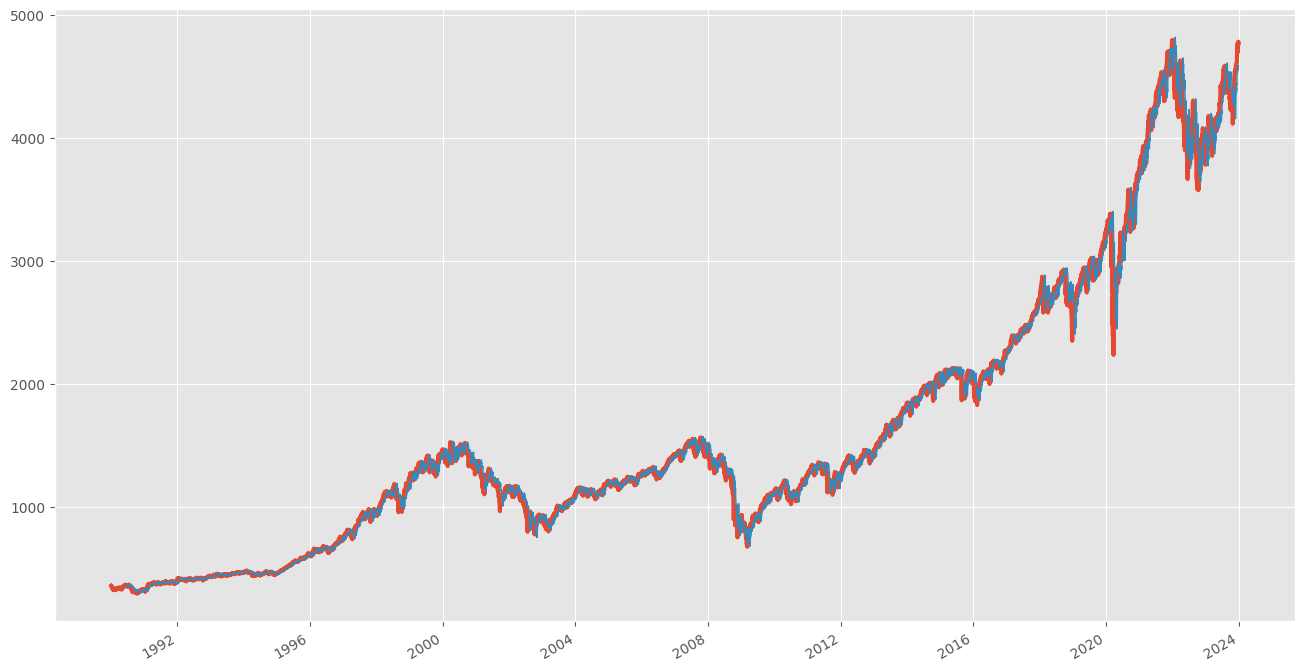

In [39]:
plot_series([data, absolute_predictions_cnn2d_single])

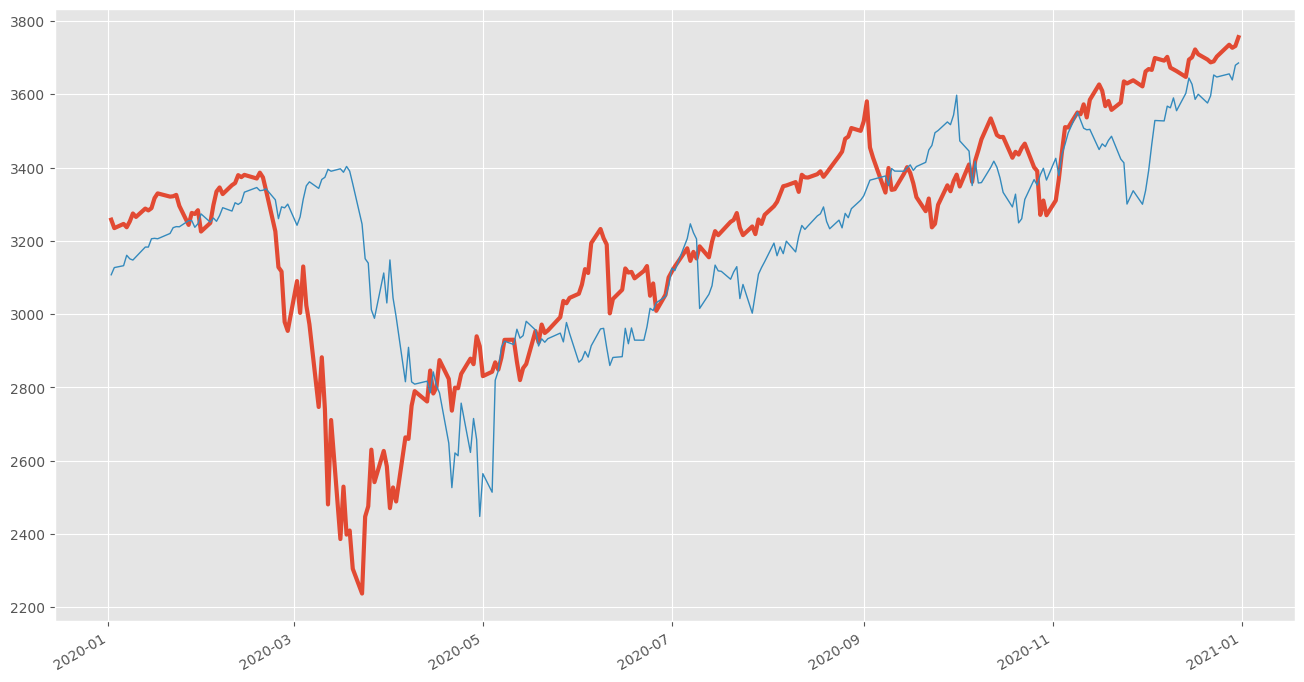

In [40]:
plot_series([data, absolute_predictions_cnn2d_single], "2020-01-01", "2020-12-31")

In [41]:
metrics(experiment_cnn2d_single, absolute_predictions_cnn2d_single)

GLOBAL:
n=8455 MSE=7401.6172 RMSE=86.0327 MAE=51.2035 MAPE=0.0317 R² = 0.9937
TRAIN: 
n=62696 MSE=0.0019 RMSE=0.0438 MAE=0.0313 MAPE=1.5219
TEST: 
n=13579 MSE=0.0029 RMSE=0.0535 MAE=0.0370 MAPE=1.8104

Métricas guardadas exitosamente en: /home/manidmt/Universidad/TFG/OTRI/models/keras/cnn2d_gspc_single_metrics.json


In [42]:
reset_gpu()

In [43]:
config_transformer_single = {
    "mode": "global",  
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": "transfomer_gspc_single",
    "start_year": start_date,
    "end_year": end_date,
    "lookahead": 20,
    "horizon": 90,
    "model_params": {
        "architecture": "transformer",
        "topology": {
            "activation": {
                "output": "linear"
            }
        },
        "num_heads": 2,
        "ff_dim": 64,
        "dropout": 0.1,
        "optimization": {
            "optimizer": "adam",
            "loss": "mean_squared_error",
            "metrics": ["mae"],
            "epochs": 20,
            "batch_size": 32,
            "validation_split": 0.1
        }
    }
}

In [46]:
experiment_transformer_single = ModelExperimentFactory.create_experiment(config_transformer_single)
experiment_transformer_single.run()

Architecture: transformer
Epoch 1/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 1.4028e-04 - loss: 0.0021
Epoch 2/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6541e-04 - loss: 0.0020 
Epoch 3/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.2479e-05 - loss: 0.0021
Epoch 4/300
 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0037

2025-07-06 20:10:33.895239: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_reduce_fusion_1', 140 bytes spill stores, 140 bytes spill loads



47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5699e-04 - loss: 0.0023
Epoch 5/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3253e-04 - loss: 0.0022 
Epoch 6/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7846e-05 - loss: 0.0023 
Epoch 7/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.1054e-05 - loss: 0.0023 
Epoch 8/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1128e-04 - loss: 0.0022
Epoch 9/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3434e-04 - loss: 0.0020 
Epoch 10/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4913e-04 - loss: 0.0021 
Epoch 11/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.0378e-05 - loss: 0.0022
Epoch 12/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2709e-04 - loss: 0.0021
Epoch 13/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1806e-04 - loss: 0.0021
Epoch 14/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7561e-04 - loss: 0.0020
Epoch 15/300
47/47 ━━━━

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.8507e-05 - loss: 0.0022
Epoch 70/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.5292e-05 - loss: 0.0022
Epoch 71/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.5628e-05 - loss: 0.0020 
Epoch 72/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1128e-04 - loss: 0.0022 
Epoch 73/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.0360e-05 - loss: 0.0021 
Epoch 74/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1632e-05 - loss: 0.0020
Epoch 75/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7846e-05 - loss: 0.0020
Epoch 76/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8349e-04 - loss: 0.0021
Epoch 77/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.3546e-05 - loss: 0.0021
Epoch 78/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5507e-05 - loss: 0.0021
Epoch 79/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.7561e-04 - loss: 0.0023
Epoch 80/300
47/47 ━

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9477e-05 - loss: 0.0020
Epoch 135/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7846e-05 - loss: 0.0021
Epoch 136/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2709e-04 - loss: 0.0020
Epoch 137/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6541e-04 - loss: 0.0022
Epoch 138/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0530e-05 - loss: 0.0020
Epoch 139/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4147e-05 - loss: 0.0021
Epoch 140/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0477e-04 - loss: 0.0021
Epoch 141/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 8.1054e-05 - loss: 0.0021
Epoch 142/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5699e-04 - loss: 0.0021
Epoch 143/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4028e-04 - loss: 0.0021
Epoch 144/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9477e-05 - loss: 0.0021
Epoch 145/300

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7561e-04 - loss: 0.0021
Epoch 200/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4028e-04 - loss: 0.0021
Epoch 201/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0825e-04 - loss: 0.0021
Epoch 202/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6309e-04 - loss: 0.0022 
Epoch 203/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.2479e-05 - loss: 0.0021 
Epoch 204/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2746e-04 - loss: 0.0020
Epoch 205/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5699e-04 - loss: 0.0020
Epoch 206/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.8171e-04 - loss: 0.0021 
Epoch 207/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9477e-05 - loss: 0.0022 
Epoch 208/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.5422e-04 - loss: 0.0020
Epoch 209/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4147e-05 - loss: 0.0021
Epoch 210

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6541e-04 - loss: 0.0022 
Epoch 265/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.8507e-05 - loss: 0.0021
Epoch 266/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6666e-05 - loss: 0.0022 
Epoch 267/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3434e-04 - loss: 0.0022
Epoch 268/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6401e-05 - loss: 0.0021 
Epoch 269/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2709e-04 - loss: 0.0022 
Epoch 270/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6309e-04 - loss: 0.0022
Epoch 271/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8349e-04 - loss: 0.0021
Epoch 272/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2002e-05 - loss: 0.0020 
Epoch 273/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2746e-04 - loss: 0.0021 
Epoch 274/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8349e-04 - loss: 0.0021
Epoch 2

187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Architecture: transformer
Epoch 1/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 2.7846e-04 - loss: 0.0019
Epoch 2/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9799e-04 - loss: 0.0024
Epoch 3/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4879e-04 - loss: 0.0020 
Epoch 4/300
 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0012

2025-07-06 20:11:02.890605: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_reduce_fusion_1', 140 bytes spill stores, 140 bytes spill loads



49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1313e-04 - loss: 0.0019
Epoch 5/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6875e-04 - loss: 0.0022 
Epoch 6/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.8911e-05 - loss: 0.0021 
Epoch 7/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0688e-04 - loss: 0.0022
Epoch 8/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9507e-05 - loss: 0.0021
Epoch 9/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0852e-05 - loss: 0.0021
Epoch 10/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.0313e-04 - loss: 0.0021
Epoch 11/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.5087e-05 - loss: 0.0020 
Epoch 12/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6417e-05 - loss: 0.0022
Epoch 13/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7489e-04 - loss: 0.0021
Epoch 14/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6875e-04 - loss: 0.0021
Epoch 15/300
49/49 ━━━━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.3020e-05 - loss: 0.0021
Epoch 71/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.8987e-05 - loss: 0.0021
Epoch 72/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2518e-05 - loss: 0.0019
Epoch 73/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.0313e-04 - loss: 0.0022
Epoch 74/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0794e-05 - loss: 0.0020
Epoch 75/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1825e-04 - loss: 0.0021 
Epoch 76/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0794e-05 - loss: 0.0021
Epoch 77/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.5087e-05 - loss: 0.0020
Epoch 78/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0852e-05 - loss: 0.0020
Epoch 79/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.4688e-04 - loss: 0.0020
Epoch 80/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0087e-04 - loss: 0.0020
Epoch 81/300
49/49 ━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7489e-04 - loss: 0.0021
Epoch 136/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.9657e-05 - loss: 0.0022
Epoch 137/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.8511e-05 - loss: 0.0019
Epoch 138/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1964e-04 - loss: 0.0021
Epoch 139/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9507e-05 - loss: 0.0021
Epoch 140/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.6954e-06 - loss: 0.0021
Epoch 141/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6110e-04 - loss: 0.0021
Epoch 142/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2644e-04 - loss: 0.0021
Epoch 143/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.0313e-04 - loss: 0.0022
Epoch 144/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.5087e-05 - loss: 0.0021
Epoch 145/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.4688e-04 - loss: 0.0020
Epoch 146/300

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9889e-05 - loss: 0.0021
Epoch 201/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0852e-05 - loss: 0.0022
Epoch 202/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.4119e-05 - loss: 0.0020
Epoch 203/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2644e-04 - loss: 0.0020
Epoch 204/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5193e-05 - loss: 0.0020
Epoch 205/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4548e-04 - loss: 0.0022
Epoch 206/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4098e-04 - loss: 0.0020
Epoch 207/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4098e-04 - loss: 0.0019
Epoch 208/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6875e-04 - loss: 0.0021
Epoch 209/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8465e-04 - loss: 0.0022
Epoch 210/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9799e-04 - loss: 0.0022 
Epoch 211/30

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9889e-05 - loss: 0.0021 
Epoch 266/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9507e-04 - loss: 0.0020
Epoch 267/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.4253e-05 - loss: 0.0020
Epoch 268/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.4119e-05 - loss: 0.0021 
Epoch 269/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.6954e-06 - loss: 0.0021
Epoch 270/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2031e-04 - loss: 0.0021
Epoch 271/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6570e-04 - loss: 0.0021
Epoch 272/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0794e-05 - loss: 0.0020
Epoch 273/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2644e-04 - loss: 0.0020
Epoch 274/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4605e-05 - loss: 0.0021
Epoch 275/300
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1825e-04 - loss: 0.0020
Epoch 276/3

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Architecture: transformer
Epoch 1/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 1.5681e-04 - loss: 0.0020
Epoch 2/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0413e-04 - loss: 0.0021
Epoch 3/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.5655e-04 - loss: 0.0021
Epoch 4/300


2025-07-06 20:11:32.216421: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_reduce_fusion_1', 32 bytes spill stores, 32 bytes spill loads



51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7611e-05 - loss: 0.0020
Epoch 5/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0413e-04 - loss: 0.0020
Epoch 6/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.3167e-04 - loss: 0.0020
Epoch 7/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7399e-04 - loss: 0.0020
Epoch 8/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1382e-04 - loss: 0.0020
Epoch 9/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7399e-04 - loss: 0.0020
Epoch 10/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1461e-04 - loss: 0.0021
Epoch 11/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0282e-04 - loss: 0.0020
Epoch 12/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6713e-05 - loss: 0.0021
Epoch 13/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7399e-04 - loss: 0.0020
Epoch 14/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.7259e-05 - loss: 0.0020
Epoch 15/300
51/51 ━━━━━━━━━

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8338e-04 - loss: 0.0020
Epoch 71/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7611e-05 - loss: 0.0021
Epoch 72/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6713e-05 - loss: 0.0020
Epoch 73/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5689e-04 - loss: 0.0020
Epoch 74/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0860e-04 - loss: 0.0021
Epoch 75/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6515e-04 - loss: 0.0019
Epoch 76/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2087e-04 - loss: 0.0020
Epoch 77/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6712e-05 - loss: 0.0021
Epoch 78/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.5655e-04 - loss: 0.0020
Epoch 79/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8899e-05 - loss: 0.0019
Epoch 80/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0282e-04 - loss: 0.0019
Epoch 81/300
51/51 ━━━━

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.5439e-05 - loss: 0.0021
Epoch 136/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9340e-04 - loss: 0.0021
Epoch 137/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4890e-04 - loss: 0.0019
Epoch 138/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9103e-05 - loss: 0.0020
Epoch 139/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0413e-04 - loss: 0.0021
Epoch 140/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2859e-05 - loss: 0.0019
Epoch 141/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8899e-05 - loss: 0.0020
Epoch 142/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2859e-05 - loss: 0.0022
Epoch 143/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7358e-04 - loss: 0.0021
Epoch 144/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9103e-05 - loss: 0.0019
Epoch 145/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.2163e-05 - loss: 0.0020
Epoch 146/300

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1862e-05 - loss: 0.0020
Epoch 201/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2022e-05 - loss: 0.0021
Epoch 202/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7611e-05 - loss: 0.0019
Epoch 203/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2821e-04 - loss: 0.0019
Epoch 204/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4890e-04 - loss: 0.0021
Epoch 205/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0647e-04 - loss: 0.0020
Epoch 206/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2740e-04 - loss: 0.0020
Epoch 207/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1382e-04 - loss: 0.0022
Epoch 208/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1862e-05 - loss: 0.0020
Epoch 209/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2022e-05 - loss: 0.0021
Epoch 210/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.4726e-05 - loss: 0.0020
Epoch 211/300

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9340e-04 - loss: 0.0020
Epoch 266/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9103e-05 - loss: 0.0021
Epoch 267/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8899e-05 - loss: 0.0020
Epoch 268/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7611e-05 - loss: 0.0021
Epoch 269/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1569e-04 - loss: 0.0021
Epoch 270/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.8191e-04 - loss: 0.0021
Epoch 271/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5152e-05 - loss: 0.0020
Epoch 272/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8349e-05 - loss: 0.0022
Epoch 273/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3423e-04 - loss: 0.0019
Epoch 274/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4953e-05 - loss: 0.0021
Epoch 275/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7399e-04 - loss: 0.0021
Epoch 276/300

202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Architecture: transformer
Epoch 1/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 7.9416e-05 - loss: 0.0021
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.3894e-05 - loss: 0.0020
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0998e-04 - loss: 0.0021
Epoch 4/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0761e-04 - loss: 0.0020
Epoch 5/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8199e-04 - loss: 0.0019
Epoch 6/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.4083e-05 - loss: 0.0020
Epoch 7/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2180e-04 - loss: 0.0020
Epoch 8/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3059e-05 - loss: 0.0019
Epoch 9/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8199e-04 - loss: 0.0020
Epoch 10/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2122e-05 - loss: 0.0020
Ep

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1310e-04 - loss: 0.0020
Epoch 66/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.2978e-06 - loss: 0.0019
Epoch 67/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2122e-05 - loss: 0.0020
Epoch 68/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7295e-04 - loss: 0.0021
Epoch 69/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.9416e-05 - loss: 0.0019
Epoch 70/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2122e-05 - loss: 0.0019
Epoch 71/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.9164e-04 - loss: 0.0019
Epoch 72/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2516e-04 - loss: 0.0019
Epoch 73/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.0511e-05 - loss: 0.0020
Epoch 74/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3172e-04 - loss: 0.0020
Epoch 75/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0998e-04 - loss: 0.0019
Epoch 76/300
53/53 ━━━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3073e-05 - loss: 0.0020
Epoch 131/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8103e-05 - loss: 0.0019
Epoch 132/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0442e-04 - loss: 0.0019
Epoch 133/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2516e-04 - loss: 0.0020
Epoch 134/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6086e-05 - loss: 0.0019
Epoch 135/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9164e-04 - loss: 0.0020
Epoch 136/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4028e-05 - loss: 0.0020
Epoch 137/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6218e-05 - loss: 0.0020  
Epoch 138/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2122e-05 - loss: 0.0020
Epoch 139/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9433e-05 - loss: 0.0020
Epoch 140/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9682e-04 - loss: 0.0019
Epoch 141/3

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2516e-04 - loss: 0.0020
Epoch 196/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.2978e-06 - loss: 0.0020
Epoch 197/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8199e-04 - loss: 0.0020
Epoch 198/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.3894e-05 - loss: 0.0020
Epoch 199/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4155e-04 - loss: 0.0020
Epoch 200/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4879e-04 - loss: 0.0020
Epoch 201/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5640e-04 - loss: 0.0020
Epoch 202/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6981e-05 - loss: 0.0021
Epoch 203/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.4895e-05 - loss: 0.0019
Epoch 204/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.1739e-04 - loss: 0.0020
Epoch 205/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.2978e-06 - loss: 0.0019
Epoch 206/300

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3831e-04 - loss: 0.0021
Epoch 261/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6885e-04 - loss: 0.0020
Epoch 262/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0197e-04 - loss: 0.0021
Epoch 263/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9682e-04 - loss: 0.0020
Epoch 264/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1135e-05 - loss: 0.0019
Epoch 265/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4028e-05 - loss: 0.0020
Epoch 266/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9530e-05 - loss: 0.0021
Epoch 267/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.4083e-05 - loss: 0.0021
Epoch 268/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.8905e-05 - loss: 0.0021
Epoch 269/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6981e-05 - loss: 0.0021
Epoch 270/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5640e-04 - loss: 0.0020
Epoch 271/300

210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
Architecture: transformer
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 1.2854e-04 - loss: 0.0019
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.4344e-04 - loss: 0.0019
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2247e-04 - loss: 0.0020
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.8913e-05 - loss: 0.0018
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7273e-05 - loss: 0.0020
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0393e-04 - loss: 0.0020
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1051e-04 - loss: 0.0020
Epoch 8/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3488e-04 - loss: 0.0019
Epoch 9/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7273e-05 - loss: 0.0019
Epoch 10/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.3016e-05 - loss: 0.0020


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4850e-04 - loss: 0.0019
Epoch 66/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.7104e-06 - loss: 0.0019
Epoch 67/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6359e-04 - loss: 0.0020
Epoch 68/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0393e-04 - loss: 0.0019
Epoch 69/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.0754e-05 - loss: 0.0019
Epoch 70/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7273e-05 - loss: 0.0019
Epoch 71/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6577e-05 - loss: 0.0019
Epoch 72/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1666e-04 - loss: 0.0019
Epoch 73/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.1604e-05 - loss: 0.0019
Epoch 74/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3482e-04 - loss: 0.0019
Epoch 75/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.1052e-05 - loss: 0.0021
Epoch 76/300
55/55 ━━━━

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8171e-04 - loss: 0.0019
Epoch 131/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0306e-05 - loss: 0.0020
Epoch 132/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.1052e-05 - loss: 0.0020
Epoch 133/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.5280e-04 - loss: 0.0019
Epoch 134/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1398e-05 - loss: 0.0019
Epoch 135/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.0754e-05 - loss: 0.0019
Epoch 136/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4850e-04 - loss: 0.0019
Epoch 137/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.3610e-05 - loss: 0.0020
Epoch 138/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8551e-05 - loss: 0.0020
Epoch 139/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0055e-04 - loss: 0.0019
Epoch 140/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6428e-04 - loss: 0.0018
Epoch 141/300

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6577e-05 - loss: 0.0019
Epoch 196/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0393e-04 - loss: 0.0020
Epoch 197/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8052e-04 - loss: 0.0019
Epoch 198/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8171e-04 - loss: 0.0018
Epoch 199/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.5565e-05 - loss: 0.0021
Epoch 200/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.5280e-04 - loss: 0.0019
Epoch 201/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1398e-05 - loss: 0.0020
Epoch 202/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.1604e-05 - loss: 0.0019
Epoch 203/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.8913e-05 - loss: 0.0019
Epoch 204/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2854e-04 - loss: 0.0019
Epoch 205/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1666e-04 - loss: 0.0020
Epoch 206/300

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4877e-04 - loss: 0.0020
Epoch 261/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.7104e-06 - loss: 0.0018
Epoch 262/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2247e-04 - loss: 0.0019
Epoch 263/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.3610e-05 - loss: 0.0019
Epoch 264/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0164e-04 - loss: 0.0019
Epoch 265/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3143e-05 - loss: 0.0020
Epoch 266/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4877e-04 - loss: 0.0019
Epoch 267/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6545e-05 - loss: 0.0020
Epoch 268/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2214e-04 - loss: 0.0018
Epoch 269/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0033e-05 - loss: 0.0020
Epoch 270/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5761e-05 - loss: 0.0021
Epoch 271/300

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Architecture: transformer
Epoch 1/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 1.4806e-04 - loss: 0.0020
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7056e-04 - loss: 0.0019
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.9989e-05 - loss: 0.0019
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3491e-04 - loss: 0.0019
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0675e-04 - loss: 0.0019
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3130e-05 - loss: 0.0019
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3491e-04 - loss: 0.0020
Epoch 8/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7371e-05 - loss: 0.0018
Epoch 9/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.1833e-06 - loss: 0.0019
Epoch 10/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.2307e-05 - loss: 0.0019
Ep

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1732e-04 - loss: 0.0020
Epoch 66/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9998e-05 - loss: 0.0020
Epoch 67/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.5181e-05 - loss: 0.0021
Epoch 68/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.9124e-04 - loss: 0.0019
Epoch 69/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7371e-05 - loss: 0.0019
Epoch 70/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6444e-05 - loss: 0.0019
Epoch 71/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.7817e-05 - loss: 0.0019
Epoch 72/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3141e-04 - loss: 0.0019
Epoch 73/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.5181e-05 - loss: 0.0019
Epoch 74/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6444e-05 - loss: 0.0019
Epoch 75/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2879e-04 - loss: 0.0019
Epoch 76/300
57/57 ━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2389e-04 - loss: 0.0020
Epoch 131/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2389e-04 - loss: 0.0019
Epoch 132/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2389e-04 - loss: 0.0019
Epoch 133/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.1219e-05 - loss: 0.0020
Epoch 134/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7056e-04 - loss: 0.0019
Epoch 135/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5984e-04 - loss: 0.0019
Epoch 136/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6263e-04 - loss: 0.0019
Epoch 137/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3141e-04 - loss: 0.0020
Epoch 138/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.2307e-05 - loss: 0.0019
Epoch 139/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2127e-05 - loss: 0.0020
Epoch 140/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.2307e-05 - loss: 0.0019
Epoch 141/300

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6337e-05 - loss: 0.0020
Epoch 196/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.9124e-04 - loss: 0.0019
Epoch 197/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8796e-04 - loss: 0.0019
Epoch 198/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1916e-04 - loss: 0.0020
Epoch 199/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9758e-04 - loss: 0.0018
Epoch 200/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3491e-04 - loss: 0.0019
Epoch 201/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3141e-04 - loss: 0.0019
Epoch 202/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6337e-05 - loss: 0.0020
Epoch 203/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0794e-04 - loss: 0.0020
Epoch 204/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4531e-04 - loss: 0.0020
Epoch 205/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4806e-04 - loss: 0.0020
Epoch 206/300

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.5181e-05 - loss: 0.0019
Epoch 261/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5984e-04 - loss: 0.0019
Epoch 262/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0675e-04 - loss: 0.0019
Epoch 263/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6444e-05 - loss: 0.0020
Epoch 264/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0176e-04 - loss: 0.0019
Epoch 265/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1732e-04 - loss: 0.0019
Epoch 266/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.1833e-06 - loss: 0.0019
Epoch 267/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4806e-04 - loss: 0.0019
Epoch 268/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7259e-05 - loss: 0.0019
Epoch 269/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4668e-05 - loss: 0.0018
Epoch 270/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.6952e-05 - loss: 0.0019
Epoch 271/300

226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Architecture: transformer
Epoch 1/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 6.9498e-05 - loss: 0.0019
Epoch 2/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2342e-05 - loss: 0.0021
Epoch 3/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.1413e-04 - loss: 0.0018
Epoch 4/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8606e-04 - loss: 0.0020
Epoch 5/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.5063e-05 - loss: 0.0018
Epoch 6/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6066e-05 - loss: 0.0019
Epoch 7/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6924e-04 - loss: 0.0018
Epoch 8/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1584e-05 - loss: 0.0018
Epoch 9/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.5597e-05 - loss: 0.0019
Epoch 10/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4099e-04 - loss: 0.0019
E

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7073e-04 - loss: 0.0019
Epoch 66/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3038e-05 - loss: 0.0019
Epoch 67/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3685e-05 - loss: 0.0018
Epoch 68/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4750e-04 - loss: 0.0018
Epoch 69/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1778e-04 - loss: 0.0018
Epoch 70/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.5063e-05 - loss: 0.0019
Epoch 71/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.3038e-05 - loss: 0.0018
Epoch 72/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4099e-04 - loss: 0.0019
Epoch 73/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1623e-04 - loss: 0.0019
Epoch 74/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1257e-04 - loss: 0.0020
Epoch 75/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6924e-04 - loss: 0.0018
Epoch 76/300
59/59 ━━━━

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8936e-05 - loss: 0.0018
Epoch 131/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6924e-04 - loss: 0.0019
Epoch 132/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8871e-05 - loss: 0.0020
Epoch 133/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8871e-05 - loss: 0.0018
Epoch 134/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0274e-04 - loss: 0.0018
Epoch 135/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4099e-04 - loss: 0.0019
Epoch 136/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0274e-04 - loss: 0.0018
Epoch 137/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.5882e-05 - loss: 0.0018
Epoch 138/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4354e-05 - loss: 0.0018
Epoch 139/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.5063e-05 - loss: 0.0019
Epoch 140/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.0994e-05 - loss: 0.0019
Epoch 141/300

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8871e-05 - loss: 0.0018
Epoch 196/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4109e-04 - loss: 0.0019
Epoch 197/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6214e-05 - loss: 0.0019
Epoch 198/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1623e-04 - loss: 0.0019
Epoch 199/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.8936e-05 - loss: 0.0019
Epoch 200/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6924e-04 - loss: 0.0020
Epoch 201/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9263e-05 - loss: 0.0019
Epoch 202/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4109e-04 - loss: 0.0018
Epoch 203/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4099e-04 - loss: 0.0018
Epoch 204/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.2342e-05 - loss: 0.0020
Epoch 205/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.0944e-04 - loss: 0.0020
Epoch 206/300

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1257e-04 - loss: 0.0020
Epoch 261/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4099e-04 - loss: 0.0019
Epoch 262/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.6159e-04 - loss: 0.0019
Epoch 263/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4354e-05 - loss: 0.0018
Epoch 264/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9043e-04 - loss: 0.0019
Epoch 265/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7183e-04 - loss: 0.0019
Epoch 266/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7185e-05 - loss: 0.0019
Epoch 267/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0079e-05 - loss: 0.0019
Epoch 268/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8606e-04 - loss: 0.0019
Epoch 269/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.0994e-05 - loss: 0.0019
Epoch 270/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.5882e-05 - loss: 0.0019
Epoch 271/300

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Architecture: transformer
Epoch 1/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 1.7338e-05 - loss: 0.0022
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0586e-05 - loss: 0.0022
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2776e-06 - loss: 0.0022
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0616e-04 - loss: 0.0023
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3453e-04 - loss: 0.0021
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0352e-04 - loss: 0.0022
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4684e-04 - loss: 0.0020
Epoch 8/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4472e-05 - loss: 0.0024
Epoch 9/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.1129e-05 - loss: 0.0022
Epoch 10/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9463e-05 - loss: 0.0021
E

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6716e-04 - loss: 0.0022
Epoch 66/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.7851e-05 - loss: 0.0020
Epoch 67/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9316e-04 - loss: 0.0022
Epoch 68/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.1129e-05 - loss: 0.0022
Epoch 69/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.1129e-05 - loss: 0.0021
Epoch 70/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2333e-04 - loss: 0.0023
Epoch 71/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2797e-05 - loss: 0.0021
Epoch 72/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0616e-04 - loss: 0.0022
Epoch 73/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2049e-05 - loss: 0.0020
Epoch 74/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3741e-04 - loss: 0.0021
Epoch 75/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.4679e-05 - loss: 0.0022
Epoch 76/300
61/61 ━━━━

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9463e-05 - loss: 0.0022
Epoch 131/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7576e-04 - loss: 0.0021
Epoch 132/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.4951e-05 - loss: 0.0021
Epoch 133/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2034e-05 - loss: 0.0023
Epoch 134/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9671e-05 - loss: 0.0021
Epoch 135/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.0487e-04 - loss: 0.0023
Epoch 136/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2880e-05 - loss: 0.0020
Epoch 137/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7338e-05 - loss: 0.0022
Epoch 138/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.8674e-05 - loss: 0.0022
Epoch 139/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.4679e-05 - loss: 0.0021
Epoch 140/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0616e-04 - loss: 0.0021
Epoch 141/300

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.9388e-04 - loss: 0.0023
Epoch 196/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2481e-04 - loss: 0.0022
Epoch 197/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0352e-04 - loss: 0.0021
Epoch 198/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.3136e-04 - loss: 0.0022
Epoch 199/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.2776e-06 - loss: 0.0021
Epoch 200/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7576e-04 - loss: 0.0022
Epoch 201/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3453e-04 - loss: 0.0022
Epoch 202/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2034e-05 - loss: 0.0021
Epoch 203/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8516e-04 - loss: 0.0023
Epoch 204/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1335e-04 - loss: 0.0020
Epoch 205/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5347e-04 - loss: 0.0022
Epoch 206/300

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9463e-05 - loss: 0.0021
Epoch 261/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.8416e-04 - loss: 0.0021
Epoch 262/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8516e-04 - loss: 0.0024
Epoch 263/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7341e-05 - loss: 0.0021
Epoch 264/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.6286e-04 - loss: 0.0022
Epoch 265/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.5141e-04 - loss: 0.0021
Epoch 266/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.1129e-05 - loss: 0.0023
Epoch 267/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0819e-04 - loss: 0.0022
Epoch 268/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.6413e-05 - loss: 0.0022
Epoch 269/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.6787e-04 - loss: 0.0021
Epoch 270/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.9024e-05 - loss: 0.0021
Epoch 271/300

242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Architecture: transformer
Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 3.2384e-05 - loss: 0.0022
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9943e-05 - loss: 0.0022
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9096e-04 - loss: 0.0022
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.2963e-05 - loss: 0.0022
Epoch 5/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9573e-05 - loss: 0.0021
Epoch 6/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9606e-04 - loss: 0.0022
Epoch 7/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4739e-04 - loss: 0.0021
Epoch 8/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0035e-04 - loss: 0.0022
Epoch 9/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2162e-04 - loss: 0.0022
Epoch 10/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0044e-04 - loss: 0.0021
E

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0865e-04 - loss: 0.0021
Epoch 66/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.5537e-04 - loss: 0.0020
Epoch 67/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0638e-05 - loss: 0.0020
Epoch 68/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.0041e-05 - loss: 0.0021
Epoch 69/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.0995e-05 - loss: 0.0020
Epoch 70/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0638e-05 - loss: 0.0021
Epoch 71/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.1493e-05 - loss: 0.0021
Epoch 72/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9943e-05 - loss: 0.0021
Epoch 73/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9943e-05 - loss: 0.0022
Epoch 74/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5930e-04 - loss: 0.0022
Epoch 75/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.8157e-05 - loss: 0.0023
Epoch 76/300
63/63 ━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.2670e-05 - loss: 0.0020
Epoch 131/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.6273e-05 - loss: 0.0020
Epoch 132/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6265e-04 - loss: 0.0022
Epoch 133/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.0041e-05 - loss: 0.0022
Epoch 134/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3061e-05 - loss: 0.0021
Epoch 135/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4609e-04 - loss: 0.0020
Epoch 136/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.5709e-04 - loss: 0.0022
Epoch 137/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1993e-05 - loss: 0.0020
Epoch 138/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2162e-04 - loss: 0.0021
Epoch 139/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.5537e-04 - loss: 0.0021
Epoch 140/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5251e-04 - loss: 0.0023
Epoch 141/300

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.0035e-04 - loss: 0.0022
Epoch 196/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9573e-05 - loss: 0.0022
Epoch 197/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6879e-05 - loss: 0.0021
Epoch 198/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.4609e-04 - loss: 0.0020
Epoch 199/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.7555e-05 - loss: 0.0021
Epoch 200/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2899e-05 - loss: 0.0021   
Epoch 201/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6879e-05 - loss: 0.0020
Epoch 202/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.8157e-05 - loss: 0.0021
Epoch 203/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.9943e-05 - loss: 0.0022
Epoch 204/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.6879e-05 - loss: 0.0022
Epoch 205/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2899e-05 - loss: 0.0021
Epoch 206/

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1335e-04 - loss: 0.0021
Epoch 261/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8009e-04 - loss: 0.0020
Epoch 262/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6265e-04 - loss: 0.0022
Epoch 263/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4739e-04 - loss: 0.0022
Epoch 264/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1823e-04 - loss: 0.0021
Epoch 265/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.3740e-05 - loss: 0.0021
Epoch 266/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6265e-04 - loss: 0.0020
Epoch 267/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.1493e-05 - loss: 0.0022
Epoch 268/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2162e-04 - loss: 0.0021
Epoch 269/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5930e-04 - loss: 0.0020
Epoch 270/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.7549e-05 - loss: 0.0020
Epoch 271/300

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 1/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 8.9314e-05 - loss: 0.0021
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3315e-05 - loss: 0.0023
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7077e-04 - loss: 0.0022
Epoch 4/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1359e-04 - loss: 0.0020
Epoch 5/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.5091e-05 - loss: 0.0022
Epoch 6/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2698e-04 - loss: 0.0024
Epoch 7/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4137e-04 - loss: 0.0022
Epoch 8/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9733e-05 - loss: 0.0022
Epoch 9/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.9314e-05 - loss: 0.0022
Epoch 10/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 5.7640e-05 - loss: 0.0023
Epoch 11/300
67/67 ━━━━━━━━

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.5580e-05 - loss: 0.0022
Epoch 66/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0491e-04 - loss: 0.0021
Epoch 67/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0597e-05 - loss: 0.0021
Epoch 68/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0597e-05 - loss: 0.0022
Epoch 69/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2451e-05 - loss: 0.0021
Epoch 70/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8461e-05 - loss: 0.0020
Epoch 71/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0917e-04 - loss: 0.0021
Epoch 72/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.7069e-05 - loss: 0.0021
Epoch 73/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.4244e-05 - loss: 0.0021
Epoch 74/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.3319e-04 - loss: 0.0021
Epoch 75/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.1359e-04 - loss: 0.0022
Epoch 76/300
67/67 ━━━━

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.5683e-04 - loss: 0.0020
Epoch 131/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.7077e-04 - loss: 0.0020
Epoch 132/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9733e-05 - loss: 0.0021
Epoch 133/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.6333e-05 - loss: 0.0021
Epoch 134/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9787e-06 - loss: 0.0021
Epoch 135/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.8863e-05 - loss: 0.0022
Epoch 136/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0597e-05 - loss: 0.0021
Epoch 137/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 8.5724e-05 - loss: 0.0023
Epoch 138/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.8967e-04 - loss: 0.0021
Epoch 139/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0597e-05 - loss: 0.0022
Epoch 140/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.1549e-04 - loss: 0.0020
Epoch 141/300

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0628e-05 - loss: 0.0021
Epoch 196/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.2297e-04 - loss: 0.0022
Epoch 197/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 4.7069e-05 - loss: 0.0021
Epoch 198/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.9548e-04 - loss: 0.0022
Epoch 199/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.3315e-05 - loss: 0.0021
Epoch 200/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.0628e-05 - loss: 0.0023
Epoch 201/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.9733e-05 - loss: 0.0021
Epoch 202/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2193e-05 - loss: 0.0023
Epoch 203/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2838e-05 - loss: 0.0021
Epoch 204/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 7.8863e-05 - loss: 0.0023
Epoch 205/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.9787e-06 - loss: 0.0021
Epoch 206/300

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0491e-04 - loss: 0.0022
Epoch 261/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7967e-04 - loss: 0.0021
Epoch 262/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2193e-05 - loss: 0.0022
Epoch 263/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.2698e-04 - loss: 0.0022
Epoch 264/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.7388e-05 - loss: 0.0021
Epoch 265/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.4137e-04 - loss: 0.0022
Epoch 266/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.1265e-04 - loss: 0.0020
Epoch 267/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 6.6261e-05 - loss: 0.0021
Epoch 268/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 2.3975e-04 - loss: 0.0023
Epoch 269/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 9.3020e-05 - loss: 0.0020
Epoch 270/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 3.2838e-05 - loss: 0.0020
Epoch 271/300

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


In [47]:
print(experiment_transformer_single.predictions)
absolute_predictions_transformer_single = experiment_transformer_single.reconstruct_absolute_predictions_from_relative()
print(absolute_predictions_transformer_single)

1990-05-10   -0.006607
1990-05-11   -0.006607
1990-05-14   -0.006607
1990-05-15   -0.006607
1990-05-16   -0.006607
                ...   
2023-12-22   -0.006607
2023-12-26   -0.006607
2023-12-27   -0.006607
2023-12-28   -0.006607
2023-12-29   -0.006607
Length: 8475, dtype: float32
1990-06-08     346.106712
1990-06-11     354.341109
1990-06-12     357.109399
1990-06-13     356.636272
1990-06-14     356.354411
                 ...     
2023-12-22    4589.663459
2023-12-26    4580.694533
2023-12-27    4585.184157
2023-12-28    4580.845433
2023-12-29    4598.179686
Length: 8455, dtype: float64


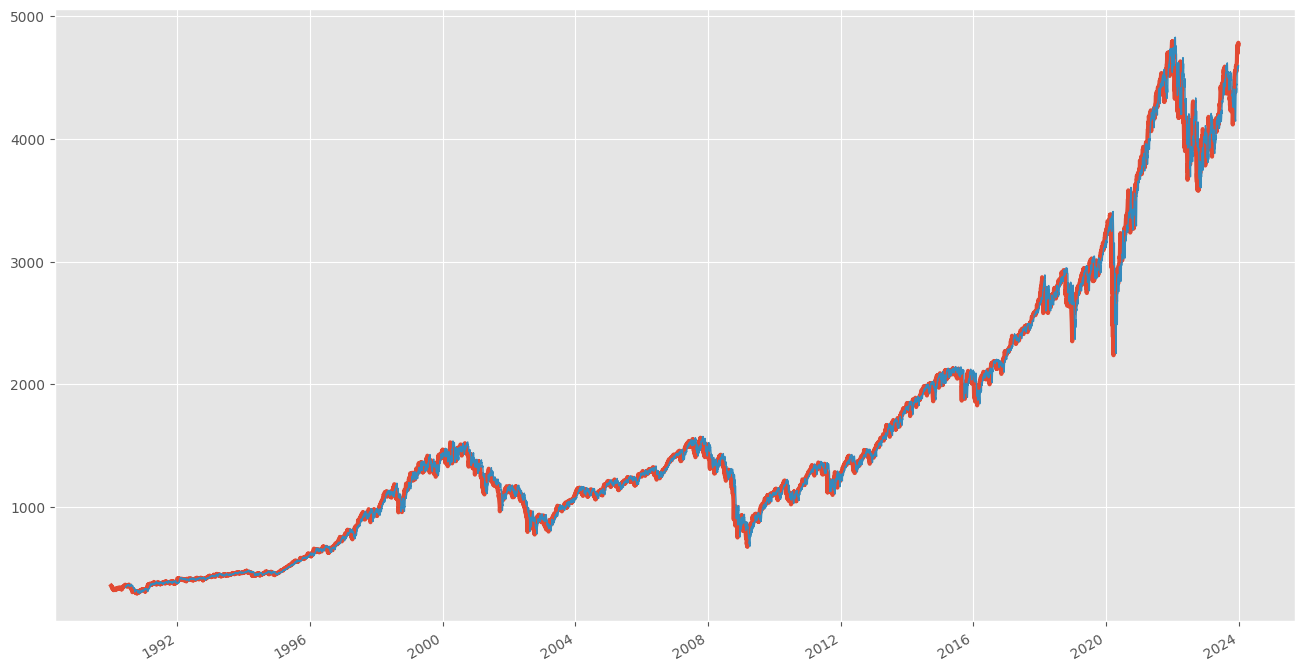

In [48]:
plot_series([data, absolute_predictions_transformer_single])

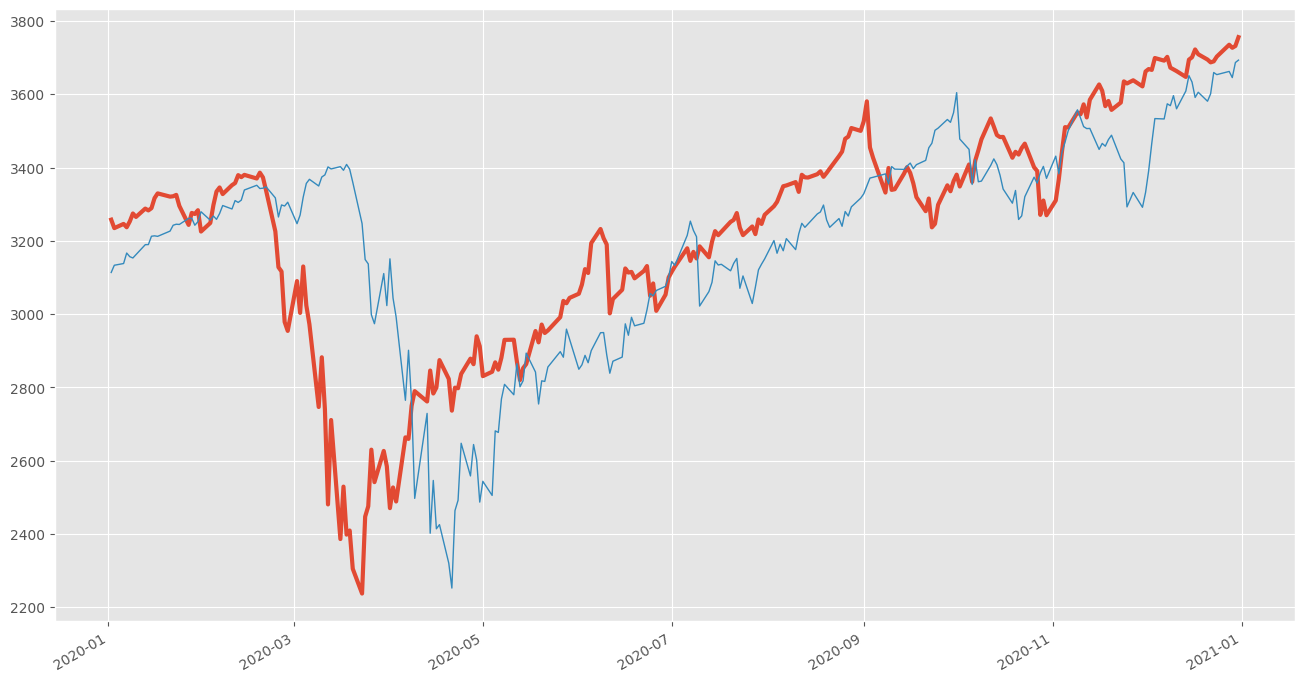

In [49]:
plot_series([data, absolute_predictions_transformer_single], "2020-01-01", "2020-12-31")

In [50]:
metrics(experiment_transformer_single, absolute_predictions_transformer_single)

GLOBAL:
n=8455 MSE=7789.2116 RMSE=88.2565 MAE=51.9611 MAPE=0.0321 R² = 0.9934
TRAIN: 
n=62696 MSE=0.0020 RMSE=0.0450 MAE=0.0316 MAPE=1.4664
TEST: 
n=13579 MSE=0.0028 RMSE=0.0522 MAE=0.0368 MAPE=1.8057

Métricas guardadas exitosamente en: /home/manidmt/Universidad/TFG/OTRI/models/keras/transfomer_gspc_single_metrics.json
